In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import boxcox, jarque_bera, probplot
from scipy.special import inv_boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from pmdarima import auto_arima

from datetime import timedelta
from math import sqrt
import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

import os
print(os.listdir("/Users/yc00027/Documents/air-quality-madrid/"))

import warnings
warnings.filterwarnings("ignore")

['.DS_Store', 'csvs_per_year', 'stations.csv', 'madrid.h5', '.ipynb_checkpoints']


# Air quality Madrid - Rolling predictions

### Extracting the data

In [2]:
# Import full dataframe

df_full = pd.read_csv('full_madrid_air_quality.csv').set_index('date').sort_index()
df_full.index = pd.to_datetime(df_full.index)

# Select data for the time period, particles and stations of interest

first_date = '2012-01-01 00:00:00'
last_date = '2018-04-30 23:00:00'

particles_of_interest = ['CO', 'NO_2', 'O_3', 'SO_2']

stations_of_interest = [28079004, 28079008, 28079011, 28079016, 28079017, 28079018, 
                        28079024, 28079035, 28079036, 28079038, 28079039, 28079040]

df_temp = df_full.loc[first_date:last_date][particles_of_interest + ['station']].sort_index()
df_temp = df_temp.loc[df_temp['station'].isin(stations_of_interest)]

print(f'The time period is from {first_date} to {last_date}')
print('')

# Generate dataframe for one particle and one station of interest

particle_of_interest = 'NO_2'
station_of_interest = 28079004

print(f'The particle of interest is: {particle_of_interest}')
print('')

print(f'The station of interest is: {station_of_interest}')
print('')

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation = oneparticle_onestation.drop(columns = [x for x in particles_of_interest if x is not particle_of_interest], axis=1)
oneparticle_onestation.drop('station', axis=1, inplace=True)

print(f'Missing values for particle and station of interest: {round(oneparticle_onestation[particle_of_interest].isnull().mean()*100, 2)}%')
print('')
oneparticle_onestation.dropna(inplace=True)

oneparticle_onestation['diff_particle'] = oneparticle_onestation[particle_of_interest].diff()
oneparticle_onestation['bc_particle'], lamb = boxcox(oneparticle_onestation[particle_of_interest])
oneparticle_onestation['bc_diff_particle'] = oneparticle_onestation['bc_particle'].diff()
oneparticle_onestation.fillna(0, inplace=True)

oneparticle_onestation['quarter'] = oneparticle_onestation.index.quarter
oneparticle_onestation['dayofyear'] = oneparticle_onestation.index.dayofyear
oneparticle_onestation['dayofmonth'] = oneparticle_onestation.index.day
oneparticle_onestation['weekyear'] = oneparticle_onestation.index.weekofyear
oneparticle_onestation['weekday'] = oneparticle_onestation.index.weekday
oneparticle_onestation['hour'] = oneparticle_onestation.index.hour
oneparticle_onestation['year'] = oneparticle_onestation.index.year
oneparticle_onestation['month'] = oneparticle_onestation.index.month
oneparticle_onestation.fillna(0, inplace=True)

print(f'One particle, one station DF shape: {oneparticle_onestation.shape}')
oneparticle_onestation.head()

The time period is from 2012-01-01 00:00:00 to 2018-04-30 23:00:00

The particle of interest is: NO_2

The station of interest is: 28079004

Missing values for particle and station of interest: 0.34%

One particle, one station DF shape: (55302, 12)


NO_2  diff_particle  bc_particle  bc_diff_particle  quarter  dayofyear  dayofmonth  weekyear  weekday  hour  year  month
date                                                                                                                                         
2012-01-01 00:00:00  80.0            0.0     9.662568          0.000000        1          1           1        52        6     0  2012      1
2012-01-01 01:00:00  58.0          -22.0     8.402874         -1.259694        1          1           1        52        6     1  2012      1
2012-01-01 02:00:00  61.0            3.0     8.591863          0.188990        1          1           1        52        6     2  2012      1
2012-01-01 03:00:00  55.0           -6.0     8.207148         -0.384715        1          1           1        52        6     3  2012      1
2012-01-01 04:00:00  49.0           -6.0     7.792879         -0.414269        1          1           1        52        6     4  2012      1

## Rolling predictions

In [3]:
# Define functions to fit an auto ARIMA model and generate predictions

def fit_autoARIMA(train):
    model = auto_arima(train.rename(None), trace=True, error_action='ignore', suppress_warnings=True) 
    model_fit = model.fit(train, transparams=False, disp=-1)
    return model_fit

def predict_autoARIMA(model_fit, test):
    predictions = model_fit.predict(n_periods=len(test))
    return predictions[0]

# Define function to plot actuals vs predictions

def plot_actuals_predictions(target, predictions_final):
    fig, ax = plt.subplots(figsize=(21,7))
    actuals = plt.plot(target, label='Actuals')
    predictions = plt.plot(predictions_final, label='Predictions')
    error = results_over_time['rmse'].mean()
    plt.legend(loc='best')
    plt.title('RMSE: %.2f'% error)
    plt.show()

# Define model evaluation function

def evaluate_forecast(target, predictions_final, model_name):
    results = {'models': model_name}
    results['r2_score'] = r2_score(target, predictions_final)
    results['mean_abs_error'] = mean_absolute_error(target, predictions_final)
    results['median_abs_error'] = median_absolute_error(target, predictions_final)
    results['mse'] = mean_squared_error(target, predictions_final)
    results['rmse'] = np.sqrt(results['mse'])
    return results

### Rolling autoARIMA: target = particle_of_interest

In [4]:
# Generate rolling predictions and results for particle of interest

data = oneparticle_onestation.sort_index().copy()
target = particle_of_interest

fit_func = fit_autoARIMA
predict_func = predict_autoARIMA

min_train_date = '2018-01-01'

week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    models = train_set.groupby(['weekday', 'hour'])[target].apply(fit_func)
    predictions = test_set.apply(lambda x: predict_func(models.loc[tuple(x[['weekday', 'hour']])], x), axis=1)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time = pd.DataFrame(results_over_time).drop('models', axis=1).set_index('date').sort_index()
predictions_over_time = pd.concat(predictions_over_time)

2018-01-07 00:00:00
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3058.997, BIC=3081.493, Time=0.544 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3058.599, BIC=3066.098, Time=0.028 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3057.261, BIC=3068.509, Time=0.056 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3056.681, BIC=3067.929, Time=0.328 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3470.587, BIC=3474.337, Time=0.086 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3055.122, BIC=3070.120, Time=0.691 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3059.711, BIC=3078.458, Time=0.467 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3057.119, BIC=3075.866, Time=1.226 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3056.910, BIC=3071.907, Time=0.386 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2711.164, BIC=2722.402, Time=0.219 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3366.849, BIC=3370.595, Time=0.013 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2711.895, BIC=2726.880, Time=0.190 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2711.876, BIC=2726.860, Time=0.475 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2713.891, BIC=2732.622, Time=0.286 seconds
Total fit time: 2.206 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2835.684, BIC=2858.162, Time=0.893 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2853.040, BIC=2860.532, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2834.430, BIC=2845.668, Time=0.110 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2838.818, BIC=2850.056, Time=0.191 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2544.748, BIC=2559.629, Time=0.366 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2546.653, BIC=2565.254, Time=0.704 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2554.558, BIC=2569.439, Time=0.268 seconds
Total fit time: 3.408 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2604.145, BIC=2626.622, Time=0.904 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2680.752, BIC=2688.244, Time=0.029 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2615.080, BIC=2626.318, Time=0.090 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2636.090, BIC=2647.329, Time=0.140 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3182.762, BIC=3186.508, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2602.196, BIC=2620.927, Time=0.411 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3098.662, BIC=3121.158, Time=0.710 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3105.694, BIC=3113.193, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3103.699, BIC=3114.948, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3104.188, BIC=3115.436, Time=0.105 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3571.543, BIC=3575.292, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3104.043, BIC=3122.790, Time=0.644 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3104.301, BIC=3123.048, Time=0.462 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3100.199, BIC=3126.444, Time=0.795 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3099.477, BIC=3125.722, Time=0.877 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3102.766, BIC=3117.763, Time=0.483 seconds
Fit ARIMA: (1, 0, 3

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2624.630, BIC=2647.127, Time=0.802 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2619.528, BIC=2627.027, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2619.712, BIC=2630.960, Time=0.099 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2619.575, BIC=2630.823, Time=0.229 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3160.409, BIC=3164.158, Time=0.013 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2620.779, BIC=2635.777, Time=0.686 seconds
Total fit time: 1.854 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2731.259, BIC=2753.755, Time=0.807 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2727.670, BIC=2735.169, Time=0.024 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2725.801, BIC=2737.049, Time=0.139 seconds
F

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2647.609, BIC=2658.838, Time=0.327 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3252.961, BIC=3256.704, Time=0.013 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2608.723, BIC=2627.438, Time=0.685 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2636.261, BIC=2651.233, Time=0.425 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2606.851, BIC=2621.823, Time=0.535 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2608.753, BIC=2627.468, Time=0.730 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2616.876, BIC=2631.848, Time=0.092 seconds
Total fit time: 3.805 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2623.220, BIC=2645.697, Time=0.663 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2692.286, BIC=2699.779, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3123.323, BIC=3138.321, Time=0.261 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3112.648, BIC=3127.646, Time=0.540 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3114.049, BIC=3132.796, Time=0.768 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3119.215, BIC=3134.213, Time=0.067 seconds
Total fit time: 3.440 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3101.871, BIC=3124.348, Time=0.558 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3297.488, BIC=3304.980, Time=0.024 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3210.195, BIC=3221.434, Time=0.126 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3098.924, BIC=3110.163, Time=0.256 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3295.489, BIC=3299.235, Time=0.029 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2911.547, BIC=2941.516, Time=0.922 seconds
Total fit time: 6.583 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2823.043, BIC=2845.540, Time=0.650 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2831.936, BIC=2839.435, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2828.422, BIC=2839.671, Time=0.037 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2828.286, BIC=2839.534, Time=0.099 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3219.890, BIC=3223.639, Time=0.018 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2826.458, BIC=2845.205, Time=0.594 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2832.263, BIC=2851.010, Time=0.221 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2827.784, BIC=2854.030, Time=0.739 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2891.939, BIC=2903.178, Time=0.153 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3547.481, BIC=3551.227, Time=0.014 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2884.826, BIC=2903.557, Time=0.703 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2887.212, BIC=2902.197, Time=0.410 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2884.816, BIC=2899.801, Time=0.365 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2884.915, BIC=2903.646, Time=0.619 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2884.599, BIC=2899.583, Time=0.136 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2885.484, BIC=2904.215, Time=0.187 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2887.464, BIC=2909.941, Time=0.312 seconds
Total fit time: 3.723 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3229.253, BIC=3232.996, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2621.243, BIC=2639.958, Time=0.247 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2648.659, BIC=2663.631, Time=0.180 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2619.302, BIC=2634.274, Time=0.196 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2621.253, BIC=2639.968, Time=0.304 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2628.852, BIC=2643.824, Time=0.095 seconds
Total fit time: 1.773 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2727.479, BIC=2749.937, Time=0.356 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2827.815, BIC=2835.301, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2745.594, BIC=2756.823, Time=0.075 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3131.358, BIC=3142.596, Time=0.235 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3594.189, BIC=3597.935, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3132.695, BIC=3147.680, Time=0.162 seconds
Total fit time: 1.167 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3068.898, BIC=3091.375, Time=1.023 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3070.871, BIC=3078.363, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3072.545, BIC=3083.783, Time=0.035 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3072.612, BIC=3083.851, Time=0.134 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3518.223, BIC=3521.969, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3067.959, BIC=3086.690, Time=0.344 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2666.387, BIC=2692.611, Time=0.850 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2667.155, BIC=2693.378, Time=0.953 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2674.770, BIC=2708.486, Time=1.531 seconds
Near non-invertible roots for order (4, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Total fit time: 9.989 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2611.963, BIC=2634.441, Time=0.753 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2613.795, BIC=2621.287, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2614.519, BIC=2625.758, Time=0.134 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2614.662, BIC=2625.901, Time=0.152 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3025.174, BIC=3028.920, Tim

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2908.561, BIC=2931.000, Time=1.411 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3076.295, BIC=3083.775, Time=0.017 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2987.163, BIC=2998.383, Time=0.084 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2913.354, BIC=2924.574, Time=0.111 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3074.300, BIC=3078.039, Time=0.015 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2916.590, BIC=2935.289, Time=1.069 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2910.901, BIC=2929.600, Time=0.755 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2912.975, BIC=2939.154, Time=2.538 seconds
Near non-inver

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2896.376, BIC=2907.624, Time=0.206 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3439.472, BIC=3443.222, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2832.406, BIC=2851.153, Time=0.415 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2877.075, BIC=2892.072, Time=0.334 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2830.849, BIC=2845.847, Time=0.333 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2832.484, BIC=2851.231, Time=0.466 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2845.547, BIC=2860.544, Time=0.345 seconds
Total fit time: 2.960 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3049.541, BIC=3072.037, Time=0.851 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3122.381, BIC=3129.880, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2721.507, BIC=2744.004, Time=0.661 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2717.464, BIC=2724.962, Time=0.029 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2719.393, BIC=2730.641, Time=0.119 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2719.402, BIC=2730.650, Time=0.149 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3107.745, BIC=3111.494, Time=0.012 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2721.462, BIC=2736.459, Time=0.118 seconds
Total fit time: 1.092 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2625.614, BIC=2648.110, Time=0.438 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2618.820, BIC=2626.319, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2620.751, BIC=2631.999, Time=0.092 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2886.880, BIC=2909.299, Time=0.594 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2888.077, BIC=2910.496, Time=0.714 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2885.936, BIC=2915.829, Time=0.708 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 5.803 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2856.638, BIC=2879.077, Time=0.828 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3029.6

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2710.354, BIC=2725.338, Time=0.150 seconds
Total fit time: 3.561 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2690.022, BIC=2712.519, Time=0.590 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2749.099, BIC=2756.598, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2703.879, BIC=2715.127, Time=0.123 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2718.998, BIC=2730.246, Time=0.116 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3279.044, BIC=3282.793, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2688.292, BIC=2707.039, Time=0.408 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2704.637, BIC=2719.634, Time=0.217 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2686.313, BIC=2701.311, Time=0.243 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3166.397, BIC=3181.394, Time=0.305 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3167.386, BIC=3186.133, Time=0.247 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3163.549, BIC=3186.046, Time=0.962 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3164.433, BIC=3190.678, Time=0.862 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3165.511, BIC=3191.757, Time=0.362 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3165.495, BIC=3187.991, Time=0.575 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3166.636, BIC=3196.631, Time=1.227 seconds
Total fit time: 6.546 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3174.169, BIC=3196.665, Time=0.791 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3170.593, BIC=3178.092, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2606.450, BIC=2625.197, Time=0.288 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2606.615, BIC=2625.362, Time=0.209 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2604.911, BIC=2619.909, Time=0.627 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2608.443, BIC=2630.939, Time=0.433 seconds
Total fit time: 2.524 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2631.441, BIC=2653.938, Time=0.753 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2629.224, BIC=2636.722, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2627.352, BIC=2638.600, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2627.614, BIC=2638.863, Time=0.080 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3187.028, BIC=3190.777, Time=0.010 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2598.145, BIC=2609.393, Time=0.122 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3059.338, BIC=3063.088, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2545.366, BIC=2564.113, Time=0.255 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2545.366, BIC=2564.113, Time=0.293 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2546.201, BIC=2572.447, Time=0.943 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2546.233, BIC=2572.479, Time=0.486 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2543.370, BIC=2558.367, Time=0.188 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2578.177, BIC=2593.175, Time=0.194 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2550.722, BIC=2565.720, Time=0.116 seconds
Total fit time: 3.164 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3123.599, BIC=3161.093, Time=1.459 seconds
Total fit time: 10.989 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3167.600, BIC=3190.096, Time=0.621 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3176.805, BIC=3184.304, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3167.261, BIC=3178.510, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3167.752, BIC=3179.000, Time=0.156 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3661.054, BIC=3664.803, Time=0.019 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3169.102, BIC=3184.100, Time=0.118 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3169.060, BIC=3184.058, Time=0.066 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3170.980, BIC=3189.727, Time=0.218 seconds
Total fit time: 1.243 seconds
Performing st

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2687.814, BIC=2710.310, Time=0.752 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2684.592, BIC=2692.091, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2684.873, BIC=2696.121, Time=0.083 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2684.976, BIC=2696.224, Time=0.177 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3110.962, BIC=3114.712, Time=0.011 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2686.618, BIC=2701.615, Time=0.070 seconds
Total fit time: 1.113 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2622.709, BIC=2645.205, Time=0.742 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2623.962, BIC=2631.460, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2625.358, BIC=2636.606, Time=0.075 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2576.709, BIC=2595.456, Time=0.482 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2604.999, BIC=2619.996, Time=0.200 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2576.320, BIC=2591.317, Time=0.245 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2576.774, BIC=2595.521, Time=0.306 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2587.702, BIC=2602.700, Time=0.072 seconds
Total fit time: 2.432 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2559.294, BIC=2581.790, Time=0.602 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2649.859, BIC=2657.357, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2590.695, BIC=2601.943, Time=0.130 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2613.458, BIC=2624.706, Time=0.150 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2996.696, BIC=3011.693, Time=0.326 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2969.360, BIC=2984.358, Time=0.251 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2970.769, BIC=2989.516, Time=0.373 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2975.806, BIC=2990.804, Time=0.129 seconds
Total fit time: 2.085 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3000.683, BIC=3023.179, Time=0.566 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3062.180, BIC=3069.679, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3013.461, BIC=3024.709, Time=0.077 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3026.454, BIC=3037.702, Time=0.141 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3507.562, BIC=3511.311, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2818.492, BIC=2829.750, Time=0.138 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3170.912, BIC=3174.664, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2820.184, BIC=2835.195, Time=0.220 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2820.180, BIC=2835.191, Time=0.189 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2822.257, BIC=2841.020, Time=0.249 seconds
Total fit time: 1.302 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2708.186, BIC=2730.701, Time=0.715 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2705.918, BIC=2713.423, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2705.717, BIC=2716.975, Time=0.106 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2705.531, BIC=2716.788, Time=0.121 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2856.475, BIC=2871.396, Time=0.732 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2858.582, BIC=2877.233, Time=0.214 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2858.364, BIC=2877.014, Time=0.456 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2858.321, BIC=2873.241, Time=0.436 seconds
Total fit time: 2.627 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2740.212, BIC=2762.474, Time=1.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2749.675, BIC=2757.096, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2739.507, BIC=2750.639, Time=0.098 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2741.435, BIC=2752.566, Time=0.135 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3288.442, BIC=3292.153, Time=0.010 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2971.880, BIC=2983.128, Time=0.294 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3444.459, BIC=3448.208, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2914.885, BIC=2933.632, Time=0.552 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2915.126, BIC=2933.873, Time=0.620 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2918.546, BIC=2944.792, Time=0.817 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2915.406, BIC=2941.651, Time=0.937 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2914.958, BIC=2929.955, Time=0.286 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2916.730, BIC=2939.226, Time=0.471 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2916.612, BIC=2939.108, Time=0.487 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2920.042, BIC=2950.037, Time=0.850 seconds
Total fit time: 6.3

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2925.398, BIC=2944.161, Time=0.197 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2923.724, BIC=2938.734, Time=0.249 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2927.349, BIC=2949.864, Time=0.258 seconds
Total fit time: 1.533 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2841.733, BIC=2864.248, Time=0.353 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2838.008, BIC=2845.513, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2837.598, BIC=2848.856, Time=0.037 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2837.885, BIC=2849.143, Time=0.118 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3203.561, BIC=3207.314, Time=0.010 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2838.174, BIC=2853.184, Time=0.110 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2918.130, BIC=2929.349, Time=0.169 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3509.941, BIC=3513.681, Time=0.010 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2919.714, BIC=2934.674, Time=0.067 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2917.940, BIC=2932.899, Time=0.384 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2918.954, BIC=2937.653, Time=0.528 seconds
Total fit time: 1.937 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2878.446, BIC=2900.905, Time=0.735 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2890.915, BIC=2898.401, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2879.985, BIC=2891.214, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2881.343, BIC=2892.572, Time=0.147 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2787.537, BIC=2806.300, Time=0.300 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2763.510, BIC=2782.273, Time=0.297 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2765.443, BIC=2791.711, Time=0.655 seconds
Total fit time: 4.155 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2875.721, BIC=2898.237, Time=0.445 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2980.852, BIC=2988.357, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2903.619, BIC=2914.876, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2933.679, BIC=2944.937, Time=0.131 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3457.089, BIC=3460.842, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2875.915, BIC=2894.678, Time=0.297 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3084.978, BIC=3114.974, Time=1.054 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 6.437 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3003.215, BIC=3025.711, Time=0.641 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3241.670, BIC=3249.169, Time=0.017 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3132.398, BIC=3143.646, Time=0.068 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3004.152, BIC=3015.400, Time=0.233 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3239.670, BIC=3243.419, Time=0.015 seconds
Fit ARIMA: (1, 1, 2)x(

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2660.620, BIC=2686.888, Time=0.647 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2663.357, BIC=2678.367, Time=0.173 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2659.001, BIC=2681.516, Time=0.238 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2656.995, BIC=2675.758, Time=0.335 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2663.267, BIC=2678.277, Time=0.281 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2658.995, BIC=2681.510, Time=0.403 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2660.994, BIC=2687.262, Time=0.290 seconds
Total fit time: 5.058 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2620.114, BIC=2642.629, Time=1.271 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2621.734, BIC=2629.240, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2851.071, BIC=2862.290, Time=0.230 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3021.318, BIC=3025.058, Time=0.016 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2850.266, BIC=2865.225, Time=0.514 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2850.368, BIC=2865.328, Time=0.390 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2847.758, BIC=2866.457, Time=0.597 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 3.160 seconds
Perfo

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3036.805, BIC=3048.053, Time=0.946 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3557.100, BIC=3560.849, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3008.390, BIC=3027.137, Time=0.415 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3034.142, BIC=3049.140, Time=0.435 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3006.472, BIC=3021.470, Time=0.310 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3008.422, BIC=3027.169, Time=0.587 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3019.764, BIC=3034.761, Time=0.279 seconds
Total fit time: 3.723 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3091.782, BIC=3114.259, Time=1.096 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3119.929, BIC=3127.422, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2945.597, BIC=2960.594, Time=0.116 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2939.005, BIC=2961.502, Time=0.256 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2941.005, BIC=2967.251, Time=0.297 seconds
Total fit time: 3.973 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2854.880, BIC=2877.377, Time=0.607 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2857.480, BIC=2864.979, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2859.285, BIC=2870.533, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2859.305, BIC=2870.553, Time=0.126 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3240.487, BIC=3244.236, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2860.416, BIC=2879.163, Time=0.292 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2732.619, BIC=2758.865, Time=0.600 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2732.535, BIC=2758.780, Time=0.533 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2733.878, BIC=2748.875, Time=0.307 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2731.880, BIC=2754.377, Time=0.381 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2733.188, BIC=2755.684, Time=0.179 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2734.581, BIC=2764.576, Time=0.798 seconds
Total fit time: 5.111 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2868.526, BIC=2891.023, Time=0.350 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2878.547, BIC=2886.046, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2872.266, BIC=2883.514, Time=0.052 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2744.126, BIC=2766.603, Time=0.558 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2781.725, BIC=2789.217, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2753.390, BIC=2764.629, Time=0.080 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2758.004, BIC=2769.242, Time=0.136 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3284.376, BIC=3288.123, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2743.224, BIC=2761.955, Time=0.416 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2757.593, BIC=2772.578, Time=0.221 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2742.323, BIC=2757.308, Time=0.335 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2743.554, BIC=2762.285, Time=0.527 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2753.276, BIC=2768.261, Time=0.132 seconds
Total fit time: 2.4

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3169.736, BIC=3192.251, Time=0.733 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3168.837, BIC=3176.342, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3169.263, BIC=3180.521, Time=0.080 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3169.491, BIC=3180.748, Time=0.088 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3624.431, BIC=3628.184, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3170.918, BIC=3185.929, Time=0.149 seconds
Total fit time: 1.079 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3114.052, BIC=3136.567, Time=0.550 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3107.492, BIC=3114.997, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3108.998, BIC=3120.256, Time=0.087 seconds
F

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2935.318, BIC=2946.547, Time=0.293 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3122.916, BIC=3126.659, Time=0.014 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2938.970, BIC=2957.685, Time=0.654 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2931.562, BIC=2950.277, Time=0.871 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2935.529, BIC=2961.730, Time=0.766 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2935.086, BIC=2961.287, Time=1.437 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one i

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2775.766, BIC=2794.512, Time=0.536 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2775.513, BIC=2794.260, Time=0.509 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2775.341, BIC=2801.587, Time=0.939 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2774.996, BIC=2801.242, Time=0.878 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2774.825, BIC=2789.822, Time=0.370 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2776.310, BIC=2798.806, Time=0.941 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2775.903, BIC=2798.399, Time=1.091 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2772.782, BIC=2802.777, Time=1.530 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2774.824, BIC=2808.569, Time=1.144 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2774.865, BIC=2808.609, Time=1.005 seconds
Fit ARIMA: (2, 0, 4)

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3047.079, BIC=3062.089, Time=0.436 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3043.202, BIC=3065.717, Time=0.678 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3056.176, BIC=3074.939, Time=0.350 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3043.378, BIC=3062.141, Time=0.831 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3045.169, BIC=3071.437, Time=1.360 seconds
Total fit time: 6.329 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3103.903, BIC=3126.419, Time=1.720 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3141.123, BIC=3148.628, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3110.012, BIC=3121.270, Time=0.032 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3111.147, BIC=3122.404, Time=0.345 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2759.293, BIC=2781.808, Time=0.978 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2757.055, BIC=2764.560, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2754.660, BIC=2765.918, Time=0.081 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2755.029, BIC=2766.286, Time=0.265 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3178.952, BIC=3182.705, Time=0.013 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2756.043, BIC=2771.053, Time=0.170 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2754.639, BIC=2769.649, Time=0.832 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2756.544, BIC=2775.307, Time=0.711 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2757.991, BIC=2776.754, Time=0.411 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2756.275, BIC=2771.285, Time=0.186 seconds
Total fit time: 3.6

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2684.948, BIC=2703.711, Time=0.407 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2696.570, BIC=2711.580, Time=0.209 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2684.560, BIC=2699.571, Time=0.331 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2684.922, BIC=2703.685, Time=0.488 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2690.240, BIC=2705.250, Time=0.143 seconds
Total fit time: 2.482 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2645.294, BIC=2667.809, Time=0.683 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2714.516, BIC=2722.021, Time=0.025 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2655.105, BIC=2666.362, Time=0.077 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2673.235, BIC=2684.492, Time=0.137 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2835.869, BIC=2862.137, Time=0.620 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2833.169, BIC=2848.179, Time=0.243 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2877.635, BIC=2892.645, Time=0.232 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2844.405, BIC=2859.416, Time=0.113 seconds
Total fit time: 3.418 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3033.795, BIC=3056.310, Time=0.537 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3102.573, BIC=3110.078, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3056.461, BIC=3067.719, Time=0.093 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3071.320, BIC=3082.578, Time=0.156 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3513.858, BIC=3517.611, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3053.711, BIC=3064.969, Time=0.339 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3495.143, BIC=3498.895, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3055.726, BIC=3070.736, Time=0.145 seconds
Total fit time: 1.032 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2970.736, BIC=2993.252, Time=0.480 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2963.082, BIC=2970.587, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2964.952, BIC=2976.210, Time=0.034 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2964.950, BIC=2976.208, Time=0.130 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3437.765, BIC=3441.518, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2966.951, BIC=2981.962, Time=0.143 seconds
Total fit time: 0.817 seconds
Performing st

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2636.197, BIC=2647.455, Time=0.144 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3143.788, BIC=3147.541, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2622.303, BIC=2641.066, Time=0.452 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2622.310, BIC=2641.073, Time=0.440 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2623.978, BIC=2650.246, Time=0.795 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2623.979, BIC=2650.247, Time=0.790 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2620.375, BIC=2635.385, Time=0.408 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2633.389, BIC=2648.399, Time=0.215 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2628.496, BIC=2643.506, Time=0.237 seconds
Total fit time: 4.384 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2609.395, BIC=2628.158, Time=0.316 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2609.470, BIC=2628.232, Time=0.328 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2608.597, BIC=2634.865, Time=1.111 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2609.089, BIC=2635.357, Time=0.630 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2610.230, BIC=2625.240, Time=0.282 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2611.337, BIC=2633.852, Time=0.429 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2611.454, BIC=2633.970, Time=0.546 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2609.802, BIC=2639.822, Time=0.954 seconds
Total fit time: 5.960 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2758.736, BIC=2781.252, Time=0.678 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3078.578, BIC=3108.599, Time=0.849 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3075.390, BIC=3112.915, Time=1.307 seconds
Near non-invertible roots for order (4, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Total fit time: 12.312 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3076.460, BIC=3098.994, Time=0.770 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3076.111, BIC=3083.623, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3074.826, BIC=3086.093, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3074.265, BIC=3085.532, Time=0.137 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3492.141, BIC=3495.896, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3072.594, BIC=3087.617, Ti

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2596.585, BIC=2615.348, Time=1.605 seconds
Total fit time: 13.942 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2729.443, BIC=2751.958, Time=4.875 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2734.723, BIC=2742.228, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2726.487, BIC=2737.745, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2727.375, BIC=2738.633, Time=0.819 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3387.826, BIC=3391.579, Time=0.013 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2728.078, BIC=2743.089, Time=0.671 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2728.335, BIC=2743.345, Time=1.799 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2730.072, BIC=2748.834, Time=1.943 seconds
Total fit time: 10.225 seconds
Performing s

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2560.375, BIC=2575.283, Time=0.229 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2562.267, BIC=2580.902, Time=0.409 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2571.115, BIC=2586.023, Time=0.137 seconds
Total fit time: 2.020 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2620.000, BIC=2642.515, Time=0.491 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2696.264, BIC=2703.769, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2631.881, BIC=2643.138, Time=0.198 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2652.458, BIC=2663.716, Time=0.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3203.244, BIC=3206.996, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2617.965, BIC=2636.727, Time=0.431 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3071.679, BIC=3097.969, Time=0.829 seconds
Fit ARIMA: (0, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3071.373, BIC=3097.663, Time=0.488 seconds
Fit ARIMA: (1, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3074.210, BIC=3104.256, Time=0.371 seconds
Total fit time: 4.899 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3116.691, BIC=3139.226, Time=0.506 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3123.603, BIC=3131.115, Time=0.021 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3121.695, BIC=3132.962, Time=0.066 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3122.176, BIC=3133.444, Time=0.104 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3593.857, BIC=3597.613, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3121.932, BIC=3140.711, Time=0.461 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2588.159, BIC=2606.938, Time=0.477 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2588.146, BIC=2606.924, Time=0.416 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2591.851, BIC=2606.874, Time=0.168 seconds
Total fit time: 2.457 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2639.620, BIC=2662.155, Time=0.359 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2634.539, BIC=2642.050, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2634.671, BIC=2645.938, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2634.522, BIC=2645.789, Time=0.132 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3180.328, BIC=3184.084, Time=0.013 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2635.749, BIC=2650.772, Time=0.300 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 1, 4)x(0, 0, 0, 0) (constant=True); AIC=2818.033, BIC=2851.691, Time=1.576 seconds
Near non-invertible roots for order (3, 1, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Total fit time: 9.589 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2680.438, BIC=2702.799, Time=0.687 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2801.111, BIC=2808.565, Time=0.016 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2739.563, BIC=2750.744, Time=0.077 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2676.384, BIC=2687.565, Time=0.205 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2799.111, BIC=2802.838, Time=0.015 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2676.608, BIC=2691.516, Time=0.175 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2676.577, BIC=2691.484, Tim

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3114.180, BIC=3125.447, Time=0.170 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3631.037, BIC=3634.793, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3084.288, BIC=3103.067, Time=0.367 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3107.737, BIC=3122.760, Time=0.299 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3082.514, BIC=3097.537, Time=0.322 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3084.353, BIC=3103.132, Time=0.474 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3091.731, BIC=3106.754, Time=0.151 seconds
Total fit time: 2.591 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3134.156, BIC=3156.691, Time=0.884 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3148.685, BIC=3156.197, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2927.246, BIC=2949.761, Time=0.608 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2932.222, BIC=2939.728, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2931.233, BIC=2942.491, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2931.427, BIC=2942.685, Time=0.101 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3319.262, BIC=3323.014, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2929.262, BIC=2948.025, Time=0.593 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2930.259, BIC=2949.022, Time=0.585 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2930.167, BIC=2956.435, Time=0.377 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2930.936, BIC=2957.204, Time=0.672 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2933.210, BIC=2948.

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2638.357, BIC=2660.891, Time=1.190 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2637.856, BIC=2667.902, Time=3.106 seconds
Total fit time: 11.624 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2763.360, BIC=2785.876, Time=0.783 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2758.249, BIC=2765.754, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2759.961, BIC=2771.219, Time=0.035 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2760.001, BIC=2771.258, Time=0.231 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3415.571, BIC=3419.323, Time=0.014 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2761.805, BIC=2776.816, Time=0.161 seconds
Total fit time: 1.244 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2905.827, BIC

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2647.677, BIC=2670.154, Time=0.478 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2715.389, BIC=2722.882, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2668.774, BIC=2680.012, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2685.375, BIC=2696.613, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3233.313, BIC=3237.059, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2647.795, BIC=2666.526, Time=0.303 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2647.795, BIC=2666.526, Time=0.306 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2649.256, BIC=2675.480, Time=0.627 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2649.152, BIC=2675.375, Time=0.845 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2645.802, BIC=2660.787, Time=0.347 seconds
Fit ARIMA: (0, 0, 2

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3164.564, BIC=3183.326, Time=0.657 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3163.958, BIC=3190.226, Time=1.074 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3155.213, BIC=3181.481, Time=0.847 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3161.545, BIC=3184.060, Time=0.760 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3157.218, BIC=3187.238, Time=2.299 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3163.910, BIC=3193.931, Time=2.851 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3163.529, BIC=3189.797, Time=0.627 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3165.056, BIC=3198.829, Time=2.080 seconds
Total fit time: 12.773 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3151.376, BIC=3173.891, Time=0.237 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2683.745, BIC=2706.261, Time=0.628 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2689.257, BIC=2696.762, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2688.185, BIC=2699.443, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2688.548, BIC=2699.806, Time=0.125 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3055.059, BIC=3058.812, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2688.482, BIC=2707.244, Time=0.327 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2689.090, BIC=2707.853, Time=0.304 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2682.639, BIC=2708.907, Time=0.704 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2685.706, BIC=2708.222, Time=0.441 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2684.685, BIC=2714.

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2994.185, BIC=3005.433, Time=0.169 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3149.744, BIC=3153.493, Time=0.014 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2995.161, BIC=3013.908, Time=0.467 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2990.791, BIC=3009.538, Time=0.589 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2991.507, BIC=3017.753, Time=0.588 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2998.874, BIC=3025.119, Time=0.936 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2991.764, BIC=3006.762, Time=0.346 secon

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2708.131, BIC=2726.909, Time=0.288 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2744.613, BIC=2759.636, Time=0.189 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2706.678, BIC=2721.701, Time=0.400 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2708.293, BIC=2727.072, Time=0.367 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2724.134, BIC=2739.157, Time=0.081 seconds
Total fit time: 2.239 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2756.677, BIC=2779.212, Time=0.627 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2857.331, BIC=2864.842, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2787.387, BIC=2798.654, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2811.805, BIC=2823.072, Time=0.141 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2963.746, BIC=2978.769, Time=0.203 seconds
Total fit time: 1.160 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2882.089, BIC=2904.623, Time=0.755 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2879.138, BIC=2886.650, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2880.295, BIC=2891.563, Time=0.132 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2880.340, BIC=2891.607, Time=0.081 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3289.793, BIC=3293.549, Time=0.011 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2882.415, BIC=2897.438, Time=0.136 seconds
Total fit time: 1.136 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2811.383, BIC=2833.917, Time=0.760 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2808.156, BIC=

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2915.596, BIC=2934.311, Time=0.559 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2908.667, BIC=2927.382, Time=0.787 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2911.587, BIC=2937.788, Time=1.159 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2910.951, BIC=2937.152, Time=0.788 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2911.355, BIC=2926.327, Time=0.653 seconds
Near non-invertible roots for order 

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2724.552, BIC=2739.563, Time=0.650 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2742.344, BIC=2757.354, Time=0.650 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2732.429, BIC=2747.440, Time=0.258 seconds
Total fit time: 7.170 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2707.712, BIC=2730.247, Time=1.209 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2768.767, BIC=2776.278, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2723.010, BIC=2734.277, Time=0.186 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2737.998, BIC=2749.266, Time=0.170 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3302.550, BIC=3306.305, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2705.966, BIC=2724.745, Time=0.692 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3187.523, BIC=3206.302, Time=0.536 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3187.778, BIC=3206.556, Time=0.530 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3186.046, BIC=3201.069, Time=0.332 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3187.125, BIC=3205.904, Time=0.289 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3182.826, BIC=3205.360, Time=0.806 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3183.975, BIC=3210.265, Time=1.100 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3183.853, BIC=3210.143, Time=1.810 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3184.682, BIC=3207.216, Time=0.729 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3185.929, BIC=3215.975, Time=1.312 seconds
Total fit time: 8.549 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2649.550, BIC=2664.573, Time=0.306 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2649.076, BIC=2664.099, Time=0.733 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2651.075, BIC=2669.854, Time=0.667 seconds
Total fit time: 2.954 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2627.254, BIC=2649.789, Time=0.720 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2625.780, BIC=2633.291, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2623.088, BIC=2634.355, Time=0.095 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2623.709, BIC=2634.976, Time=0.280 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3171.265, BIC=3175.021, Time=0.012 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2623.459, BIC=2638.482, Time=0.273 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2614.818, BIC=2633.596, Time=0.403 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2615.462, BIC=2641.752, Time=0.950 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2615.459, BIC=2641.750, Time=1.188 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2612.917, BIC=2627.940, Time=0.309 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2642.768, BIC=2657.791, Time=0.267 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2621.305, BIC=2636.328, Time=0.099 seconds
Total fit time: 4.865 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3623.864, BIC=3627.619, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3139.733, BIC=3158.512, Time=0.440 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3139.766, BIC=3158.544, Time=0.445 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3139.135, BIC=3165.425, Time=0.709 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3139.091, BIC=3165.381, Time=0.600 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3137.981, BIC=3153.004, Time=0.314 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3141.194, BIC=3163.729, Time=0.561 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3142.531, BIC=3165.065, Time=0.145 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3135.766, BIC=3165.812, Time=0.868 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3142.516, BIC=3176.317, Time=0.849 seconds
Fit ARIMA: (3, 0, 4

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2847.579, BIC=2862.602, Time=0.109 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2846.799, BIC=2861.822, Time=0.469 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2848.469, BIC=2867.248, Time=0.494 seconds
Total fit time: 1.522 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2763.194, BIC=2785.728, Time=0.508 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2766.178, BIC=2773.689, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2763.014, BIC=2774.282, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2763.268, BIC=2774.535, Time=0.120 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3187.428, BIC=3191.184, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2764.723, BIC=2779.746, Time=0.089 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2630.105, BIC=2648.884, Time=0.281 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2659.686, BIC=2674.709, Time=0.350 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2628.975, BIC=2643.998, Time=0.298 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2630.294, BIC=2649.073, Time=0.365 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2647.367, BIC=2662.390, Time=0.093 seconds
Total fit time: 2.212 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2594.693, BIC=2617.227, Time=0.501 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2662.626, BIC=2670.137, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2624.689, BIC=2635.956, Time=0.092 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2638.980, BIC=2650.247, Time=0.111 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2945.652, BIC=2956.919, Time=0.134 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3357.337, BIC=3361.093, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2897.428, BIC=2916.207, Time=0.292 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2924.790, BIC=2939.813, Time=0.186 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2896.124, BIC=2911.147, Time=0.191 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2897.461, BIC=2916.240, Time=0.287 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2904.014, BIC=2919.037, Time=0.118 seconds
Total fit time: 1.997 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2989.699, BIC=3012.233, Time=0.451 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3090.073, BIC=3097.584, Time=0.023 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3011.944, BIC=3030.739, Time=0.466 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3011.577, BIC=3026.613, Time=0.135 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3012.111, BIC=3027.146, Time=0.079 seconds
Total fit time: 1.911 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2939.514, BIC=2962.068, Time=0.154 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2940.073, BIC=2947.590, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2935.625, BIC=2946.901, Time=0.064 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2934.590, BIC=2945.867, Time=0.096 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3311.404, BIC=3315.163, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2935.515, BIC=2950.551, Time=0.204 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2860.723, BIC=2887.013, Time=0.506 seconds
Total fit time: 2.302 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2883.612, BIC=2906.050, Time=0.262 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2903.985, BIC=2911.465, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2883.495, BIC=2894.714, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2889.029, BIC=2900.249, Time=0.110 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3519.114, BIC=3522.854, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2879.613, BIC=2894.572, Time=0.052 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2881.599, BIC=2900.298, Time=0.067 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2881.607, BIC=2900.306, Time=0.157 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2648.523, BIC=2663.546, Time=0.312 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2628.249, BIC=2643.272, Time=0.197 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2629.023, BIC=2647.802, Time=0.375 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2630.994, BIC=2646.017, Time=0.210 seconds
Total fit time: 2.578 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2773.884, BIC=2796.399, Time=0.467 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2868.685, BIC=2876.190, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2791.219, BIC=2802.477, Time=0.085 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2819.255, BIC=2830.513, Time=0.153 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3330.531, BIC=3334.284, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3113.944, BIC=3132.739, Time=0.240 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3114.222, BIC=3133.017, Time=0.359 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3114.047, BIC=3140.359, Time=0.577 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3114.078, BIC=3140.390, Time=0.232 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3113.004, BIC=3128.039, Time=0.304 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3113.669, BIC=3136.222, Time=0.181 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3114.478, BIC=3137.032, Time=0.415 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3116.085, BIC=3146.156, Time=0.366 seconds
Total fit time: 3.378 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3010.969, BIC=3033.523, Time=0.277 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2872.642, BIC=2891.421, Time=0.072 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2873.023, BIC=2891.801, Time=0.074 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2870.889, BIC=2885.912, Time=0.237 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2873.198, BIC=2891.976, Time=0.147 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2872.040, BIC=2887.063, Time=0.125 seconds
Total fit time: 1.345 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2962.518, BIC=2985.015, Time=0.156 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2973.649, BIC=2981.148, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2958.715, BIC=2969.963, Time=0.034 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2960.628, BIC=2971.876, Time=0.111 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2646.961, BIC=2665.740, Time=0.303 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2671.837, BIC=2686.860, Time=0.177 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2644.967, BIC=2659.990, Time=0.181 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2646.962, BIC=2665.741, Time=0.288 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2653.794, BIC=2668.817, Time=0.100 seconds
Total fit time: 1.717 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2693.701, BIC=2716.254, Time=0.626 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2779.997, BIC=2787.514, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2715.932, BIC=2727.209, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2738.346, BIC=2749.623, Time=0.088 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3103.466, BIC=3122.245, Time=0.338 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3104.680, BIC=3123.459, Time=0.188 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3105.645, BIC=3131.935, Time=0.559 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3102.454, BIC=3128.744, Time=0.704 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2748.149, BIC=2774.462, Time=0.536 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2747.486, BIC=2773.799, Time=0.236 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2752.330, BIC=2767.365, Time=0.111 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2745.556, BIC=2768.110, Time=0.299 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2743.898, BIC=2762.692, Time=0.163 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2752.254, BIC=2767.290, Time=0.113 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2745.496, BIC=2768.050, Time=0.233 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2747.502, BIC=2773.814, Time=0.214 seconds
Total fit time: 2.987 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2676.781, BIC=2699.334, Time=0.458 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2989.327, BIC=3000.566, Time=0.165 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3541.706, BIC=3545.452, Time=0.011 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2991.191, BIC=3006.176, Time=0.188 seconds
Total fit time: 1.230 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2925.721, BIC=2948.179, Time=0.413 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3134.327, BIC=3141.813, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3032.299, BIC=3043.528, Time=0.054 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2920.694, BIC=2931.923, Time=0.106 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3132.329, BIC=3136.072, Time=0.011 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2921.991, BIC=2936.964, Time=0.216 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2751.870, BIC=2781.890, Time=1.124 seconds
Fit ARIMA: (5, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2751.291, BIC=2781.311, Time=0.951 seconds
Fit ARIMA: (5, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2746.026, BIC=2783.552, Time=1.598 seconds
Total fit time: 10.559 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2882.618, BIC=2905.134, Time=0.580 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2975.014, BIC=2982.519, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2905.301, BIC=2916.559, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2926.869, BIC=2938.126, Time=0.169 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3472.822, BIC=3476.575, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2882.513, BIC=2901.276, Time=0.285 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3008.831, BIC=3031.365, Time=0.450 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3009.638, BIC=3032.172, Time=0.453 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3011.876, BIC=3041.922, Time=0.669 seconds
Total fit time: 5.641 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2956.732, BIC=2979.266, Time=0.624 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2959.568, BIC=2967.080, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2961.490, BIC=2972.757, Time=0.024 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2961.496, BIC=2972.764, Time=0.085 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3360.230, BIC=3363.986, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2959.477, BIC=2978.256, Time=0.378 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2640.292, BIC=2659.071, Time=0.427 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2640.544, BIC=2659.323, Time=0.327 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2641.260, BIC=2667.550, Time=0.577 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2639.790, BIC=2666.080, Time=0.590 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2639.946, BIC=2654.969, Time=0.050 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2638.997, BIC=2661.532, Time=0.417 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2640.198, BIC=2662.732, Time=0.470 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2640.643, BIC=2670.689, Time=1.043 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Total fit time: 4.602 seconds
Performing stepwise search t

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2897.443, BIC=2919.959, Time=0.412 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3056.134, BIC=3063.639, Time=0.022 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2965.437, BIC=2976.695, Time=0.063 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2892.103, BIC=2903.361, Time=0.065 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3054.134, BIC=3057.886, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2894.063, BIC=2909.073, Time=0.148 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2894.067, BIC=2909.078, Time=0.103 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2896.025, BIC=2914.788, Time=0.426 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3201.641, BIC=3224.195, Time=0.643 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3240.304, BIC=3247.821, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3215.365, BIC=3226.641, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3223.006, BIC=3234.282, Time=0.153 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3695.587, BIC=3699.345, Time=0.031 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3199.587, BIC=3218.381, Time=1.318 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3213.580, BIC=3228.615, Time=0.237 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3197.831, BIC=3212.867, Time=0.309 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3199.592, BIC=3218.387, Time=0.475 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3204.859, BIC=3219.

Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2805.546, BIC=2828.081, Time=0.455 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3004.273, BIC=3011.785, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2902.546, BIC=2913.813, Time=0.058 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2801.690, BIC=2812.957, Time=0.097 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3002.274, BIC=3006.030, Time=0.010 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2803.619, BIC=2818.642, Time=0.159 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2803.629, BIC=2818.652, Time=0.173 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2805.595, BIC=2824.374, Time=0.396 seconds
Total fit time: 1.366 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2889.295, BIC=2911.830, Time=0.457 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2890.897, BIC=2917.142, Time=0.532 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2888.489, BIC=2914.734, Time=0.571 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2899.836, BIC=2914.834, Time=0.103 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2894.840, BIC=2917.337, Time=0.216 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2892.177, BIC=2914.674, Time=0.435 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (c

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2816.960, BIC=2831.970, Time=0.172 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2816.500, BIC=2839.016, Time=0.286 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2829.578, BIC=2848.340, Time=0.184 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2814.991, BIC=2833.754, Time=0.242 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2818.069, BIC=2844.337, Time=0.484 seconds
Total fit time: 2.285 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2931.344, BIC=2953.897, Time=0.412 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3039.386, BIC=3046.904, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2941.982, BIC=2953.259, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2972.103, BIC=2983.380, Time=0.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2979.676, BIC=3002.229, Time=0.480 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2975.516, BIC=2983.034, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2975.702, BIC=2986.979, Time=0.025 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2975.775, BIC=2987.052, Time=0.110 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3429.073, BIC=3432.832, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2977.656, BIC=2992.692, Time=0.119 seconds
Total fit time: 0.757 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2923.900, BIC=2946.454, Time=0.564 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2920.069, BIC=2927.587, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2920.908, BIC=2932.184, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2730.230, BIC=2752.783, Time=0.430 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2770.149, BIC=2777.666, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2735.606, BIC=2746.883, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2743.331, BIC=2754.607, Time=0.085 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3271.465, BIC=3275.224, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2727.070, BIC=2745.864, Time=0.293 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2738.118, BIC=2753.153, Time=0.163 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2727.508, BIC=2742.544, Time=0.180 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2728.955, BIC=2751.508, Time=0.412 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2739.271, BIC=2758.

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2681.247, BIC=2707.559, Time=0.766 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2681.242, BIC=2707.554, Time=0.687 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2685.184, BIC=2700.219, Time=0.197 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2682.668, BIC=2705.222, Time=0.331 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2684.055, BIC=2706.609, Time=0.379 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2686.487, BIC=2716.558, Time=0.732 seconds
Total fit time: 4.639 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0

Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3200.431, BIC=3222.966, Time=0.220 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3198.961, BIC=3229.007, Time=0.725 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 4.052 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3135.159, BIC=3157.713, Time=0.295 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3133.163, BIC=3140.681, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3134.043, BIC=3145.320, Time=0.031 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3133.962, BIC=3145.238, Time=0.094 seconds
Fit ARIMA: (0, 0, 0)x(0

Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2632.724, BIC=2655.277, Time=0.125 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2632.802, BIC=2655.356, Time=0.140 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2632.070, BIC=2650.864, Time=0.339 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2634.724, BIC=2661.036, Time=0.203 seconds
Total fit time: 1.764 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2621.896, BIC=2644.450, Time=0.425 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2630.114, BIC=2637.632, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2624.298, BIC=2635.575, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2625.581, BIC=2636.858, Time=0.095 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3142.020, BIC=3145.779, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2537.039, BIC=2555.818, Time=0.200 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2581.495, BIC=2596.518, Time=0.148 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2537.287, BIC=2552.310, Time=0.151 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2537.299, BIC=2559.833, Time=0.243 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2572.793, BIC=2591.572, Time=0.188 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2537.404, BIC=2556.183, Time=0.200 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2536.764, BIC=2563.054, Time=0.296 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2523.856, BIC=2553.902, Time=0.713 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=253

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3084.776, BIC=3111.088, Time=0.323 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3082.618, BIC=3097.654, Time=0.271 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3085.497, BIC=3108.051, Time=0.501 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3086.304, BIC=3108.858, Time=0.260 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3085.653, BIC=3115.724, Time=0.647 seconds
Total fit time: 4.088 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3091.440, BIC=3113.993, Time=0.530 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3103.097, BIC=3110.615, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3093.695, BIC=3104.972, Time=0.060 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3093.412, BIC=3104.688, Time=0.122 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2592.374, BIC=2603.660, Time=0.209 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2995.899, BIC=2999.661, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2593.467, BIC=2612.277, Time=0.364 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2593.668, BIC=2612.478, Time=0.371 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2590.556, BIC=2616.890, Time=0.758 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2590.404, BIC=2616.738, Time=0.559 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2592.043, BIC=2607.092, Time=0.596 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2589.280, BIC=2611.853, Time=0.673 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2589.573, BIC=2608.383, Time=0.211 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2590.987, BIC=2617.322, Time=0.602 seconds
Fit ARIMA: (0, 0, 2

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2636.327, BIC=2651.142, Time=0.367 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2638.138, BIC=2656.657, Time=0.459 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2643.509, BIC=2658.324, Time=0.127 seconds
Total fit time: 3.154 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2599.730, BIC=2621.973, Time=1.230 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2649.041, BIC=2656.456, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2615.373, BIC=2626.494, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2625.782, BIC=2636.903, Time=0.276 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3175.146, BIC=3178.853, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2598.980, BIC=2617.515, Time=0.428 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3090.317, BIC=3101.603, Time=0.134 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3619.007, BIC=3622.769, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3066.314, BIC=3085.124, Time=0.653 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3066.320, BIC=3085.130, Time=0.514 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3069.435, BIC=3095.769, Time=0.766 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3066.648, BIC=3092.982, Time=0.751 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3064.350, BIC=3079.399, Time=0.359 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3084.242, BIC=3099.291, Time=0.248 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3073.777, BIC=3088.825, Time=0.165 seconds
Total fit time: 4.505 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2708.288, BIC=2723.337, Time=0.369 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2709.932, BIC=2728.742, Time=0.560 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2709.912, BIC=2728.722, Time=0.567 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2711.431, BIC=2726.479, Time=0.174 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2710.830, BIC=2725.878, Time=0.101 seconds
Total fit time: 2.569 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2605.339, BIC=2627.912, Time=0.704 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2607.435, BIC=2614.959, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2605.123, BIC=2616.410, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2605.561, BIC=2616.847, Time=0.107 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2832.747, BIC=2858.971, Time=1.358 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2836.628, BIC=2859.106, Time=0.907 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2832.641, BIC=2862.611, Time=0.875 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 4)x(0, 0, 0, 0) (constant=True); AIC=2834.229, BIC=2864.199, Time=1.541 seconds
Fit ARIMA: (1, 1, 4)x(0, 0, 0, 0) (constant=True); AIC=2835.860, BIC=2862.084, Time=1.015 seconds
Near non-invertible roots for order (1, 1, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 4)x(0, 0, 0, 0) (c

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2903.528, BIC=2922.338, Time=0.267 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2910.743, BIC=2925.791, Time=0.160 seconds
Total fit time: 1.835 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3038.810, BIC=3061.382, Time=0.464 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3136.167, BIC=3143.691, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3060.045, BIC=3071.331, Time=0.077 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3088.013, BIC=3099.300, Time=0.158 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3600.735, BIC=3604.497, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3038.697, BIC=3057.507, Time=0.296 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3067.837, BIC=3082.885, Time=0.221 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3030.628, BIC=3056.940, Time=0.671 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3028.054, BIC=3054.367, Time=0.726 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3031.568, BIC=3046.604, Time=0.386 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3031.673, BIC=3054.226, Time=0.641 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2643.177, BIC=2665.749, Time=0.446 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2642.687, BIC=2665.259, Time=0.321 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2645.188, BIC=2675.284, Time=0.411 seconds
Total fit time: 3.126 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2649.082, BIC=2671.654, Time=0.561 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2651.973, BIC=2659.497, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2653.300, BIC=2664.586, Time=0.024 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2653.311, BIC=2664.598, Time=0.060 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3191.252, BIC=3195.014, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2654.857, BIC=2673.667, Time=0.406 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2768.472, BIC=2783.482, Time=0.242 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2769.992, BIC=2788.754, Time=0.389 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2779.880, BIC=2794.890, Time=0.079 seconds
Total fit time: 1.779 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2692.671, BIC=2715.186, Time=0.476 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2751.183, BIC=2758.688, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2706.379, BIC=2717.637, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2719.186, BIC=2730.444, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3302.700, BIC=3306.453, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2690.383, BIC=2709.146, Time=0.277 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3118.606, BIC=3137.385, Time=0.309 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3138.372, BIC=3153.395, Time=0.177 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3119.311, BIC=3134.334, Time=0.210 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3114.512, BIC=3137.046, Time=0.345 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3118.221, BIC=3137.000, Time=0.183 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3115.077, BIC=3141.367, Time=0.509 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3115.052, BIC=3141.343, Time=0.482 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3118.739, BIC=3141.273, Time=0.308 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3116.716, BIC=3146.762, Time=0.628 seconds
Total fit time: 3.786 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2884.236, BIC=2914.307, Time=0.452 seconds
Total fit time: 3.680 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2800.770, BIC=2823.324, Time=0.659 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2803.418, BIC=2810.936, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2802.948, BIC=2814.225, Time=0.030 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2803.185, BIC=2814.461, Time=0.160 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3173.540, BIC=3177.299, Time=0.015 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2805.386, BIC=2824.180, Time=0.290 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2805.616, BIC=2824.410, Time=0.244 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2803.163, BIC=2829.475, Time=0.584 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3009.860, BIC=3032.413, Time=0.473 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3023.867, BIC=3031.385, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3008.800, BIC=3020.077, Time=0.057 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3011.949, BIC=3023.226, Time=0.099 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3625.410, BIC=3629.168, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3007.261, BIC=3022.296, Time=0.095 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3007.587, BIC=3026.381, Time=0.147 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3008.921, BIC=3027.716, Time=0.073 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3005.911, BIC=3020.947, Time=0.260 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3007.881, BIC=3026.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2715.908, BIC=2734.719, Time=0.275 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2739.173, BIC=2754.221, Time=0.191 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2713.957, BIC=2729.005, Time=0.223 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2715.920, BIC=2734.730, Time=0.281 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2728.009, BIC=2743.057, Time=0.080 seconds
Total fit time: 1.889 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2725.599, BIC=2748.171, Time=0.437 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2805.301, BIC=2812.825, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2754.273, BIC=2765.559, Time=0.098 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2770.969, BIC=2782.255, Time=0.105 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3051.023, BIC=3073.596, Time=0.452 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3047.161, BIC=3054.685, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3048.739, BIC=3060.025, Time=0.106 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3048.715, BIC=3060.002, Time=0.048 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3494.938, BIC=3498.700, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3050.703, BIC=3065.751, Time=0.093 seconds
Total fit time: 0.722 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2986.216, BIC=3008.789, Time=0.306 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2980.117, BIC=2987.641, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2981.544, BIC=2992.830, Time=0.082 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2957.368, BIC=2979.883, Time=0.496 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2957.868, BIC=2980.384, Time=0.574 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2960.941, BIC=2990.962, Time=0.694 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 4.294 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2927.267, BIC=2949.763, Time=0.596 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3111.7

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2807.920, BIC=2830.473, Time=0.476 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2805.513, BIC=2835.585, Time=0.534 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2805.647, BIC=2839.477, Time=0.765 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2805.773, BIC=2839.603, Time=0.633 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2805.241, BIC=2835.312, Time=0.751 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2804.111, BIC=2830.423, Time=0.580 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2811.486, BIC=2834.039, Time=0.279 seconds
Fit ARIMA: (1, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=2805.689, BIC=2835.760, Time=0.634 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2818.562, BIC=2837.356, Time=0.202 seconds
Fit ARIMA: (0, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=2812.364, BIC=2838.676, Time=0.328 seconds
Fit ARIMA: (2, 0, 5)

Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3083.508, BIC=3102.318, Time=0.215 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3070.435, BIC=3089.245, Time=0.405 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3072.192, BIC=3098.526, Time=0.805 seconds
Total fit time: 3.620 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3132.280, BIC=3154.853, Time=0.583 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3169.785, BIC=3177.309, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3138.522, BIC=3149.808, Time=0.025 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3139.560, BIC=3150.846, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3653.826, BIC=3657.588, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3132.568, BIC=3151.379, Time=0.452 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2783.944, BIC=2798.993, Time=0.115 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2782.241, BIC=2797.290, Time=0.429 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2784.009, BIC=2802.819, Time=0.594 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2785.882, BIC=2804.692, Time=0.147 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2784.168, BIC=2799.216, Time=0.159 seconds
Total fit time: 2.415 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2723.987, BIC=2746.559, Time=0.736 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2726.311, BIC=2733.836, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2721.491, BIC=2732.777, Time=0.077 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2721.764, BIC=2733.050, Time=0.194 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2670.722, BIC=2693.294, Time=0.551 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2739.547, BIC=2747.071, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2679.624, BIC=2690.910, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2697.615, BIC=2708.901, Time=0.154 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3215.198, BIC=3218.960, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2668.374, BIC=2687.184, Time=0.425 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2684.156, BIC=2699.204, Time=0.169 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2667.994, BIC=2683.042, Time=0.245 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2668.378, BIC=2687.189, Time=0.534 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2673.804, BIC=2688.

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3061.300, BIC=3083.872, Time=1.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3130.142, BIC=3137.667, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3083.742, BIC=3095.028, Time=0.094 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3098.555, BIC=3109.841, Time=0.205 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3546.607, BIC=3550.369, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3063.231, BIC=3082.042, Time=0.484 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3063.232, BIC=3082.042, Time=0.432 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3062.967, BIC=3089.301, Time=1.075 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3062.993, BIC=3089.327, Time=0.764 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3061.234, BIC=3076.

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2864.472, BIC=2875.759, Time=1.433 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3299.322, BIC=3303.084, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2865.560, BIC=2880.608, Time=1.307 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2864.652, BIC=2879.701, Time=5.041 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2866.391, BIC=2885.201, Time=7.863 seconds
Total fit time: 16.942 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2780.477, BIC=2803.050, Time=9.399 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2783.584, BIC=2791.108, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2780.607, BIC=2791.894, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2780.892, BIC=2792.179, Time=1.679 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2680.156, BIC=2695.204, Time=0.346 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2681.692, BIC=2700.502, Time=0.491 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2694.252, BIC=2709.300, Time=0.131 seconds
Total fit time: 2.354 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2649.557, BIC=2672.129, Time=0.644 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2704.302, BIC=2711.826, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2676.297, BIC=2687.583, Time=0.119 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2684.736, BIC=2696.022, Time=0.151 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3169.193, BIC=3172.955, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2647.477, BIC=2666.288, Time=0.349 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2632.876, BIC=2662.972, Time=0.868 seconds
Total fit time: 4.186 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2783.296, BIC=2805.868, Time=0.435 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2879.581, BIC=2887.105, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2809.632, BIC=2820.919, Time=0.075 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2836.783, BIC=2848.070, Time=0.131 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3236.227, BIC=3239.989, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2781.052, BIC=2799.862, Time=0.298 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2809.155, BIC=2824.203, Time=0.182 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2779.452, BIC=2794.500, Time=0.185 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3100.245, BIC=3115.305, Time=0.293 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3104.992, BIC=3123.818, Time=0.161 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3102.233, BIC=3121.059, Time=0.391 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3102.217, BIC=3117.277, Time=0.153 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3102.855, BIC=3117.916, Time=0.094 seconds
Total fit time: 1.657 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3032.009, BIC=3054.600, Time=0.369 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3031.401, BIC=3038.931, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3029.882, BIC=3041.177, Time=0.084 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3029.272, BIC=3040.568, Time=0.125 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2879.580, BIC=2902.152, Time=0.492 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2896.144, BIC=2903.668, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2877.987, BIC=2889.273, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2882.096, BIC=2893.382, Time=0.102 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3567.177, BIC=3570.939, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2877.390, BIC=2892.439, Time=0.092 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2877.659, BIC=2896.469, Time=0.080 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2875.203, BIC=2894.013, Time=0.385 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2878.423, BIC=2893.471, Time=0.158 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2879.657, BIC=2902.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2643.880, BIC=2662.691, Time=0.257 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2665.649, BIC=2680.697, Time=0.159 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2642.081, BIC=2657.130, Time=0.189 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2643.871, BIC=2662.681, Time=0.298 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2647.251, BIC=2662.299, Time=0.088 seconds
Total fit time: 1.463 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2646.166, BIC=2668.738, Time=0.546 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2741.312, BIC=2748.836, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2651.168, BIC=2662.454, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2678.336, BIC=2689.622, Time=0.101 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3150.352, BIC=3165.413, Time=0.290 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3149.421, BIC=3172.012, Time=0.328 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3151.163, BIC=3173.754, Time=0.111 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3149.930, BIC=3180.051, Time=0.600 seconds
Total fit time: 3.664 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3132.428, BIC=3155.019, Time=0.538 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3132.397, BIC=3139.927, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3133.085, BIC=3144.381, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3133.236, BIC=3144.531, Time=0.114 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3561.653, BIC=3565.418, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2767.897, BIC=2786.723, Time=0.150 seconds
Total fit time: 0.846 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2891.307, BIC=2913.879, Time=0.580 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2894.492, BIC=2902.016, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2887.873, BIC=2899.159, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2889.172, BIC=2900.458, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3592.456, BIC=3596.218, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2887.666, BIC=2902.714, Time=0.059 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2889.192, BIC=2908.003, Time=0.075 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2889.581, BIC=2908.391, Time=0.083 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2663.576, BIC=2686.149, Time=0.509 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2736.474, BIC=2743.998, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2679.987, BIC=2691.273, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2698.230, BIC=2709.516, Time=0.106 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3278.405, BIC=3282.167, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2661.939, BIC=2680.750, Time=0.299 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2686.988, BIC=2702.036, Time=0.170 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2659.948, BIC=2674.996, Time=0.190 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2661.940, BIC=2680.751, Time=0.327 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2668.728, BIC=2683.

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3147.759, BIC=3166.569, Time=0.284 seconds
Total fit time: 1.400 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3122.894, BIC=3145.467, Time=0.554 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3339.913, BIC=3347.437, Time=0.023 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3251.383, BIC=3262.669, Time=0.080 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3119.830, BIC=3131.117, Time=0.243 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3337.914, BIC=3341.676, Time=0.013 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3122.337, BIC=3141.148, Time=0.458 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (a

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2871.106, BIC=2901.227, Time=1.101 seconds
Total fit time: 5.406 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2761.353, BIC=2783.944, Time=2.482 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2766.256, BIC=2773.787, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2765.875, BIC=2777.170, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2765.696, BIC=2776.992, Time=0.334 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3164.204, BIC=3167.969, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2769.680, BIC=2788.506, Time=0.416 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2769.598, BIC=2788.424, Time=0.586 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2763.394, BIC=2789.751, Time=0.924 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3005.115, BIC=3027.612, Time=0.283 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3200.646, BIC=3208.145, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3118.250, BIC=3129.498, Time=0.062 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3000.609, BIC=3011.857, Time=0.151 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3198.646, BIC=3202.396, Time=0.011 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3002.480, BIC=3017.477, Time=0.177 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3002.477, BIC=3017.474, Time=0.164 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3003.514, BIC=3022.261, Time=0.289 seconds
Total fit time: 1.159 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2944.260, BIC=2966.756, Time=0.293 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2770.086, BIC=2792.640, Time=0.283 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2765.164, BIC=2795.236, Time=0.553 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2771.745, BIC=2798.057, Time=0.342 seconds
Fit ARIMA: (5, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2760.596, BIC=2794.426, Time=0.778 seconds
Near non-invertible roots for order (5, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2771.267, BIC=2805.098, Time=0.586 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2773.320, BIC=2803.391, Time=0.605 seconds
Fit ARIMA: (5, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2772.496, BIC=2802.567, Time=0.649 seconds
Fit ARIMA: (5, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2764.753, BIC=2802.342, Time=0.861 seconds
Fit ARIMA: (5, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=276

Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3113.871, BIC=3132.681, Time=0.169 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3115.868, BIC=3138.441, Time=0.216 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3117.841, BIC=3144.175, Time=0.229 seconds
Total fit time: 1.988 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3031.658, BIC=3054.231, Time=0.415 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3033.108, BIC=3040.632, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3035.073, BIC=3046.359, Time=0.052 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3035.079, BIC=3046.365, Time=0.071 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3478.312, BIC=3482.074, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3031.931, BIC=3050.741, Time=0.262 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2653.629, BIC=2676.202, Time=0.292 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2651.057, BIC=2681.153, Time=0.537 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 3.314 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2652.892, BIC=2675.464, Time=0.438 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2653.390, BIC=2660.914, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2653.414, BIC=2664.700, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2653.623, BIC=2664.909, Time=0.083 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3196.159, BIC=3199.921, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2655.397, BIC=2674.208, Tim

Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2962.813, BIC=2992.859, Time=0.586 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 4.029 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2915.357, BIC=2937.911, Time=0.323 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3074.871, BIC=3082.389, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2982.942, BIC=2994.219, Time=0.055 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2910.146, BIC=2921.423, Time=0.068 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3072.871, BIC=3076.630, Time=0.010 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2912.087, BIC=2927.123, Time=0.387 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2912.095, BIC=2927.130, Tim

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3220.404, BIC=3242.995, Time=0.476 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3259.238, BIC=3266.769, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3233.820, BIC=3245.115, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3241.465, BIC=3252.761, Time=0.107 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3717.871, BIC=3721.636, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3218.372, BIC=3237.198, Time=0.317 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3232.722, BIC=3247.783, Time=0.176 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3216.551, BIC=3231.612, Time=0.219 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3218.379, BIC=3237.205, Time=0.275 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3223.992, BIC=3239.

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2819.922, BIC=2834.971, Time=0.154 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2819.930, BIC=2834.978, Time=0.327 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2821.881, BIC=2840.691, Time=0.526 seconds
Total fit time: 1.739 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2906.016, BIC=2928.589, Time=0.547 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3105.040, BIC=3112.564, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2995.682, BIC=3006.968, Time=0.061 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2906.610, BIC=2917.896, Time=0.117 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3103.041, BIC=3106.803, Time=0.012 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2909.406, BIC=2928.216, Time=0.492 seconds
Near non-invertible roots for order (1, 1, 2

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2910.225, BIC=2932.760, Time=0.535 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2917.218, BIC=2939.752, Time=0.268 seconds
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2904.293, BIC=2934.339, Time=0.719 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 3.938 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2854.084, BIC=2876.656, Time=0.439 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2878.620, BIC=2886.144, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2869.378, BIC=2880.664, Time=0.057 seconds
Fit ARIMA: (0, 0, 1)x(0

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2988.920, BIC=3000.215, Time=0.119 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3492.493, BIC=3496.258, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2946.673, BIC=2965.499, Time=0.279 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2971.266, BIC=2986.327, Time=0.174 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2949.164, BIC=2964.225, Time=0.211 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2948.672, BIC=2971.263, Time=0.326 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2966.598, BIC=2985.424, Time=0.248 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2947.114, BIC=2965.940, Time=0.238 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2950.568, BIC=2976.924, Time=0.728 seconds
Total fit time: 2.883 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2999.520, BIC=3022.111, Time=0.632 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2995.175, BIC=3002.705, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2995.735, BIC=3007.030, Time=0.032 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2995.806, BIC=3007.102, Time=0.106 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3451.136, BIC=3454.902, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2997.675, BIC=3012.736, Time=0.106 seconds
Total fit time: 0.904 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2943.134, BIC=2965.725, Time=0.536 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2939.680, BIC=2947.210, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2940.848, BIC=2952.144, Time=0.029 seconds
F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2746.925, BIC=2769.516, Time=0.447 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2787.021, BIC=2794.551, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2752.616, BIC=2763.911, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2759.938, BIC=2771.234, Time=0.109 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3292.019, BIC=3295.784, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2744.079, BIC=2762.905, Time=0.371 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2755.468, BIC=2770.529, Time=0.132 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2744.807, BIC=2759.867, Time=0.285 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2745.834, BIC=2768.425, Time=0.431 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2756.646, BIC=2775.

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2696.923, BIC=2723.279, Time=0.620 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2696.926, BIC=2723.282, Time=0.587 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2701.178, BIC=2716.238, Time=0.161 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2698.513, BIC=2721.104, Time=0.275 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2700.011, BIC=2722.602, Time=0.323 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2696.708, BIC=2726.829, Time=0.719 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one in

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3155.768, BIC=3170.829, Time=0.121 seconds
Total fit time: 0.639 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3094.131, BIC=3116.722, Time=0.327 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3090.100, BIC=3097.630, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3091.757, BIC=3103.052, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3091.709, BIC=3103.004, Time=0.113 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3536.294, BIC=3540.059, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3093.760, BIC=3108.821, Time=0.107 seconds
Total fit time: 0.643 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3007.031, BIC=3029.623, Time=0.595 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2999.710, BIC=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2639.461, BIC=2658.287, Time=0.345 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2642.837, BIC=2657.898, Time=0.136 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2637.584, BIC=2652.645, Time=0.463 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2639.476, BIC=2658.302, Time=0.394 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2640.785, BIC=2655.846, Time=0.082 seconds
Total fit time: 2.044 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2653.728, BIC=2676.319, Time=0.526 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2682.564, BIC=2690.095, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2664.045, BIC=2675.341, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2668.277, BIC=2679.573, Time=0.119 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2627.843, BIC=2650.434, Time=0.679 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2738.660, BIC=2746.190, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2681.728, BIC=2693.024, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2704.843, BIC=2716.138, Time=0.109 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3097.222, BIC=3100.988, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2640.437, BIC=2659.263, Time=0.229 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2640.534, BIC=2659.360, Time=0.219 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2640.192, BIC=2666.548, Time=0.583 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2640.584, BIC=2666.941, Time=0.379 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2641.279, BIC=2656.

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3116.473, BIC=3139.065, Time=0.271 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3117.432, BIC=3140.024, Time=0.223 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3105.763, BIC=3135.885, Time=0.717 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3112.955, BIC=3146.842, Time=0.834 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3114.580, BIC=3148.467, Time=0.917 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3114.202, BIC=3144.324, Time=0.750 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3115.009, BIC=3145.130, Time=0.680 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3111.808, BIC=3149.460, Time=1.046 seconds
Total fit time: 7.935 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3114.211, BIC=3136.821, Time=0.284 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2627.790, BIC=2650.382, Time=0.474 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2625.634, BIC=2633.164, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2623.804, BIC=2635.099, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2623.811, BIC=2635.107, Time=0.067 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3156.858, BIC=3160.624, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2625.789, BIC=2640.850, Time=0.097 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2625.738, BIC=2640.799, Time=0.065 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2626.995, BIC=2645.821, Time=0.426 seconds
Total fit time: 1.224 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2766.696, BIC=2789.287, Time=0.184 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2613.941, BIC=2628.796, Time=0.213 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2615.903, BIC=2634.471, Time=0.362 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2621.877, BIC=2636.732, Time=0.093 seconds
Total fit time: 1.658 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2598.069, BIC=2620.508, Time=0.331 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2678.985, BIC=2686.465, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2614.340, BIC=2625.559, Time=0.056 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2633.954, BIC=2645.174, Time=0.104 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3213.946, BIC=3217.686, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2596.328, BIC=2615.027, Time=0.288 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3112.515, BIC=3135.125, Time=0.513 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3124.916, BIC=3132.453, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3119.225, BIC=3130.530, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3120.855, BIC=3132.160, Time=0.094 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3662.043, BIC=3665.811, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3111.983, BIC=3130.825, Time=0.325 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3118.489, BIC=3133.562, Time=0.160 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3112.025, BIC=3127.099, Time=0.343 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3110.812, BIC=3133.422, Time=0.204 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3109.998, BIC=3128.839, Time=0.180 seconds
Fit ARIMA: (0, 0, 4

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2620.141, BIC=2638.982, Time=0.392 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2623.899, BIC=2638.972, Time=0.134 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2618.298, BIC=2633.371, Time=0.291 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2620.171, BIC=2639.012, Time=0.406 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2622.929, BIC=2638.002, Time=0.091 seconds
Total fit time: 2.029 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2671.861, BIC=2694.471, Time=0.376 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2666.474, BIC=2674.011, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2666.761, BIC=2678.066, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2666.634, BIC=2677.939, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2849.449, BIC=2879.469, Time=1.340 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 6.754 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2713.558, BIC=2735.997, Time=0.554 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2835.194, BIC=2842.673, Time=0.017 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2772.812, BIC=2784.031, Time=0.078 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2709.447, BIC=2720.666, Time=0.090 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2833.199, BIC=2836.938, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2709.735, BIC=2724.694, Time=0.127 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2709.696, BIC=2724.655, Tim

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3126.854, BIC=3141.927, Time=0.223 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3128.853, BIC=3147.694, Time=0.371 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3136.027, BIC=3151.100, Time=0.112 seconds
Total fit time: 2.248 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3173.990, BIC=3196.600, Time=0.875 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3188.603, BIC=3196.140, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3180.113, BIC=3191.418, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3181.947, BIC=3193.252, Time=0.138 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3693.228, BIC=3696.996, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3172.453, BIC=3191.295, Time=0.666 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2964.650, BIC=2983.476, Time=0.458 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2970.475, BIC=2989.301, Time=0.176 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2964.030, BIC=2990.386, Time=0.638 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2966.150, BIC=2992.506, Time=0.500 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2968.881, BIC=2983.942, Time=0.389 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2964.825, BIC=2987.416, Time=0.664 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2965.117, BIC=2987.708, Time=0.347 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2966.597, BIC=2996.719, Time=0.746 seconds
Total fit time: 4.626 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2875.160, BIC=2897.770, Time=0.715 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2793.572, BIC=2808.633, Time=0.061 seconds
Total fit time: 0.605 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2939.514, BIC=2962.105, Time=0.515 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2946.514, BIC=2954.044, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2942.743, BIC=2954.038, Time=0.037 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2944.096, BIC=2955.391, Time=0.065 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3615.364, BIC=3619.129, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2937.527, BIC=2956.353, Time=0.521 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2939.698, BIC=2954.759, Time=0.155 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2937.315, BIC=2952.375, Time=0.410 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2682.370, BIC=2701.164, Time=0.358 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2689.996, BIC=2705.032, Time=0.097 seconds
Total fit time: 2.019 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2677.764, BIC=2700.336, Time=0.521 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2774.677, BIC=2782.201, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2695.659, BIC=2706.945, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2723.741, BIC=2735.027, Time=0.179 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3295.050, BIC=3298.812, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2676.204, BIC=2695.014, Time=0.245 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2702.132, BIC=2717.180, Time=0.200 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3126.234, BIC=3148.825, Time=0.473 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3126.756, BIC=3134.287, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3128.346, BIC=3139.641, Time=0.036 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3128.429, BIC=3139.725, Time=0.113 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3583.975, BIC=3587.740, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3124.513, BIC=3143.339, Time=0.251 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3124.932, BIC=3139.993, Time=0.137 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3126.245, BIC=3141.306, Time=0.321 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3126.114, BIC=3148.705, Time=0.159 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3124.101, BIC=3142.927, Time=0.211 seconds
Fit ARIMA: (0, 0, 4

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2660.194, BIC=2682.785, Time=0.728 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2660.733, BIC=2668.263, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2660.749, BIC=2672.044, Time=0.082 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2660.959, BIC=2672.255, Time=0.134 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3206.112, BIC=3209.877, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2662.717, BIC=2681.543, Time=0.294 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2662.972, BIC=2681.798, Time=0.270 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2663.072, BIC=2689.428, Time=0.599 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2662.327, BIC=2688.683, Time=0.465 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2662.322, BIC=2677.383, Time=0.056 seconds
Fit ARIMA: (1, 0, 3

Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2971.451, BIC=3001.522, Time=0.926 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 5.448 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2923.759, BIC=2946.332, Time=0.344 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3083.941, BIC=3091.465, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2992.305, BIC=3003.591, Time=0.061 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2918.488, BIC=2929.774, Time=0.070 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3081.941, BIC=3085.703, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2920.430, BIC=2935.478, Time=0.229 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2920.437, BIC=2935.485, Tim

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3229.528, BIC=3252.138, Time=0.440 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3268.476, BIC=3276.013, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3242.982, BIC=3254.287, Time=0.032 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3250.642, BIC=3261.947, Time=0.104 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3729.450, BIC=3733.219, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3227.542, BIC=3246.384, Time=0.312 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3241.903, BIC=3256.976, Time=0.138 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3225.710, BIC=3240.783, Time=0.211 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3227.550, BIC=3246.391, Time=0.255 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3233.201, BIC=3248.

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2830.279, BIC=2845.339, Time=0.235 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2830.291, BIC=2845.352, Time=0.134 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2832.283, BIC=2851.109, Time=0.345 seconds
Total fit time: 1.410 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2916.282, BIC=2938.873, Time=0.469 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3115.227, BIC=3122.757, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3006.683, BIC=3017.978, Time=0.052 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2916.871, BIC=2928.167, Time=0.069 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3113.228, BIC=3116.993, Time=0.009 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2919.655, BIC=2938.481, Time=0.435 seconds
Near non-invertible roots for order (1, 1, 2

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2925.531, BIC=2944.326, Time=0.202 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2918.248, BIC=2937.043, Time=0.474 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2918.498, BIC=2944.810, Time=0.612 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2916.423, BIC=2942.735, Time=0.746 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2927.487, BIC=2942.523, Time=0.089 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (c

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2841.041, BIC=2863.613, Time=0.362 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2947.227, BIC=2954.751, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2847.915, BIC=2859.202, Time=0.051 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2876.280, BIC=2887.566, Time=0.092 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3388.639, BIC=3392.401, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2839.046, BIC=2857.856, Time=0.336 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2861.641, BIC=2876.689, Time=0.165 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2841.734, BIC=2856.782, Time=0.181 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2841.038, BIC=2863.610, Time=0.266 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2854.418, BIC=2873.

Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3227.531, BIC=3261.445, Time=0.468 seconds
Total fit time: 4.413 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3166.189, BIC=3188.799, Time=0.456 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3162.646, BIC=3170.182, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3163.378, BIC=3174.683, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3163.398, BIC=3174.703, Time=0.091 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3612.768, BIC=3616.536, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3165.343, BIC=3180.416, Time=0.042 seconds
Total fit time: 0.647 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3085.565, BIC=3108.175, Time=0.494 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3079.804, BIC=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2767.036, BIC=2782.109, Time=0.080 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2767.023, BIC=2782.096, Time=0.049 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2769.005, BIC=2787.847, Time=0.130 seconds
Total fit time: 0.902 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2804.612, BIC=2827.222, Time=0.427 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2825.650, BIC=2833.186, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2808.074, BIC=2819.379, Time=0.066 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2810.658, BIC=2821.963, Time=0.090 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3341.946, BIC=3345.714, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2804.018, BIC=2822.860, Time=0.312 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2616.157, BIC=2642.513, Time=0.342 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2616.117, BIC=2642.473, Time=0.352 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2615.604, BIC=2630.665, Time=0.142 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2617.494, BIC=2640.085, Time=0.253 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2617.685, BIC=2640.276, Time=0.291 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2618.836, BIC=2648.958, Time=0.643 seconds
Total fit time: 2.956 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2703.558, BIC=2726.168, Time=0.428 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2827.371, BIC=2834.908, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2733.290, BIC=2744.595, Time=0.160 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3237.818, BIC=3256.660, Time=0.419 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3242.068, BIC=3260.909, Time=0.139 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3232.710, BIC=3259.088, Time=0.283 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3232.887, BIC=3259.265, Time=0.269 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3240.281, BIC=3255.354, Time=0.047 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3235.251, BIC=3257.861, Time=0.154 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3236.307, BIC=3258.917, Time=0.165 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3234.428, BIC=3264.574, Time=0.202 seconds
Total fit time: 2.226 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3164.029, BIC=3186.639, Time=0.305 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2659.269, BIC=2681.879, Time=0.505 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2660.022, BIC=2667.559, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2660.160, BIC=2671.465, Time=0.051 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2660.405, BIC=2671.710, Time=0.091 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3159.235, BIC=3163.003, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2659.012, BIC=2677.854, Time=0.315 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2660.853, BIC=2675.926, Time=0.122 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2658.041, BIC=2673.114, Time=0.297 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2659.230, BIC=2678.071, Time=0.343 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2660.040, BIC=2675.

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2560.449, BIC=2575.510, Time=0.175 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2562.055, BIC=2580.881, Time=0.265 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2574.977, BIC=2590.038, Time=0.071 seconds
Total fit time: 1.523 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2544.558, BIC=2567.149, Time=0.682 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2668.769, BIC=2676.300, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2606.449, BIC=2617.745, Time=0.085 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2630.848, BIC=2642.144, Time=0.110 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3074.974, BIC=3078.739, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2561.729, BIC=2580.555, Time=0.217 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3111.425, BIC=3137.803, Time=0.745 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3111.965, BIC=3138.344, Time=0.406 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3109.940, BIC=3125.013, Time=0.364 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3112.727, BIC=3135.336, Time=0.577 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3113.683, BIC=3136.292, Time=0.147 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3113.053, BIC=3143.200, Time=0.488 seconds
Total fit time: 4.417 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3119.871, BIC=3142.481, Time=0.820 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3132.374, BIC=3139.910, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3122.423, BIC=3133.728, Time=0.084 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3022.271, BIC=3026.042, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2617.436, BIC=2636.294, Time=0.400 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2617.654, BIC=2636.511, Time=0.403 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2614.050, BIC=2640.450, Time=0.708 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2614.817, BIC=2637.446, Time=0.498 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2616.049, BIC=2646.221, Time=0.837 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2615.756, BIC=2645.928, Time=0.873 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2613.903, BIC=2640.303, Time=0.568 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2612.749, BIC=2635.377, Time=0.486 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2613.289, BIC=2632.146, Time=0.231 seconds
Fit ARIMA: (1, 0, 4

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2661.590, BIC=2680.159, Time=0.646 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2673.881, BIC=2688.736, Time=0.144 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2659.746, BIC=2674.601, Time=0.417 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2661.583, BIC=2680.151, Time=0.536 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2667.087, BIC=2681.942, Time=0.161 seconds
Total fit time: 2.867 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2625.328, BIC=2647.630, Time=0.532 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2673.626, BIC=2681.060, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2640.014, BIC=2651.165, Time=0.110 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2650.580, BIC=2661.731, Time=0.169 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3092.472, BIC=3115.101, Time=0.601 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3139.044, BIC=3146.587, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3109.877, BIC=3121.191, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3118.244, BIC=3129.558, Time=0.102 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3651.902, BIC=3655.674, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3094.186, BIC=3113.043, Time=0.535 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3094.197, BIC=3113.054, Time=0.562 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3097.404, BIC=3123.804, Time=0.702 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3094.264, BIC=3120.664, Time=0.780 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3092.260, BIC=3107.345, Time=0.251 seconds
Fit ARIMA: (0, 0, 2

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2805.759, BIC=2820.832, Time=0.442 seconds
Total fit time: 1.228 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2736.520, BIC=2759.149, Time=0.714 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2733.430, BIC=2740.973, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2734.166, BIC=2745.481, Time=0.037 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2734.331, BIC=2745.645, Time=0.073 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3101.941, BIC=3105.713, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2731.714, BIC=2746.800, Time=0.470 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2733.301, BIC=2752.158, Time=0.569 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2733.277, BIC=2752.134, Time=0.631 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2862.028, BIC=2873.295, Time=0.085 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2999.905, BIC=3003.661, Time=0.020 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2851.776, BIC=2870.555, Time=1.070 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2856.999, BIC=2875.777, Time=0.550 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2858.192, BIC=2884.482, Time=0.912 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3066.727, BIC=3089.356, Time=0.275 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3163.557, BIC=3171.100, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3086.971, BIC=3098.286, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3114.782, BIC=3126.096, Time=0.119 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3632.908, BIC=3636.679, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3066.617, BIC=3085.474, Time=0.294 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3094.865, BIC=3109.951, Time=0.188 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3064.621, BIC=3079.707, Time=0.199 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3066.617, BIC=3085.475, Time=0.262 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3071.895, BIC=3086.

Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3059.528, BIC=3085.907, Time=0.757 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3057.068, BIC=3083.446, Time=0.800 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3060.608, BIC=3075.681, Time=0.166 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3060.588, BIC=3083.198, Time=0.721 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2673.852, BIC=2696.481, Time=0.752 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2676.592, BIC=2684.135, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2677.857, BIC=2689.171, Time=0.032 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2677.868, BIC=2689.183, Time=0.070 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3220.436, BIC=3224.207, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2679.383, BIC=2698.240, Time=0.618 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2681.762, BIC=2700.619, Time=0.232 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2678.193, BIC=2704.593, Time=0.356 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2677.460, BIC=2703.860, Time=0.718 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2679.957, BIC=2695.043, Time=0.154 seconds
Fit ARIMA: (1, 0, 3

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2715.584, BIC=2734.394, Time=0.340 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2731.890, BIC=2746.938, Time=0.172 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2714.657, BIC=2729.705, Time=0.228 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2715.728, BIC=2734.538, Time=0.357 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2725.850, BIC=2740.898, Time=0.094 seconds
Total fit time: 1.851 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2690.541, BIC=2713.113, Time=0.361 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2759.224, BIC=2766.748, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2710.563, BIC=2721.849, Time=0.036 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2727.758, BIC=2739.044, Time=0.092 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3144.823, BIC=3171.179, Time=0.536 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3144.865, BIC=3171.222, Time=0.542 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3148.566, BIC=3171.157, Time=0.316 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3146.461, BIC=3176.583, Time=0.670 seconds
Total fit time: 4.082 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3219.182, BIC=3241.792, Time=0.503 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3215.924, BIC=3223.460, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3216.900, BIC=3228.205, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3216.982, BIC=3228.287, Time=0.078 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3720.160, BIC=3723.928, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2725.506, BIC=2751.884, Time=0.622 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2727.208, BIC=2761.123, Time=0.829 seconds
Total fit time: 6.176 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2665.359, BIC=2687.969, Time=0.653 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2667.806, BIC=2675.343, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2668.242, BIC=2679.547, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2668.428, BIC=2679.733, Time=0.105 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3090.295, BIC=3094.064, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2669.150, BIC=2687.992, Time=0.377 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2669.570, BIC=2688.411, Time=0.350 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2971.041, BIC=2993.613, Time=0.529 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3142.392, BIC=3149.916, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3052.903, BIC=3064.189, Time=0.063 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2975.546, BIC=2986.832, Time=0.072 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3140.392, BIC=3144.154, Time=0.011 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2969.243, BIC=2988.053, Time=0.471 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2973.128, BIC=2991.938, Time=0.392 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too c

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2897.119, BIC=2919.748, Time=0.400 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3008.250, BIC=3015.793, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2931.270, BIC=2942.584, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2959.785, BIC=2971.099, Time=0.114 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3516.271, BIC=3520.043, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2895.410, BIC=2914.267, Time=0.253 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2941.480, BIC=2956.566, Time=0.174 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2893.921, BIC=2909.007, Time=0.206 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2895.508, BIC=2914.366, Time=0.292 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2910.175, BIC=2925.

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2853.601, BIC=2868.687, Time=0.154 seconds
Total fit time: 0.897 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2777.233, BIC=2799.861, Time=0.430 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2773.347, BIC=2780.890, Time=0.022 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2775.244, BIC=2786.558, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2775.259, BIC=2786.573, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3175.116, BIC=3178.887, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2777.338, BIC=2792.423, Time=0.109 seconds
Total fit time: 0.757 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2679.226, BIC=2701.854, Time=0.607 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2672.717, BIC=

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2956.746, BIC=2968.022, Time=0.273 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3142.369, BIC=3146.128, Time=0.013 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2959.668, BIC=2978.462, Time=0.598 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2954.242, BIC=2973.036, Time=0.637 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2956.396, BIC=2982.708, Time=0.877 seconds
Near non-invertible roots for order

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2766.591, BIC=2781.664, Time=0.302 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2785.776, BIC=2800.849, Time=0.163 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2775.783, BIC=2790.856, Time=0.099 seconds
Total fit time: 3.331 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2748.563, BIC=2771.191, Time=0.567 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2809.544, BIC=2817.087, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2763.568, BIC=2774.882, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2778.213, BIC=2789.527, Time=0.096 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3355.414, BIC=3359.185, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2746.761, BIC=2765.619, Time=0.326 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3232.798, BIC=3247.883, Time=0.236 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3234.110, BIC=3252.967, Time=0.385 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3234.368, BIC=3253.225, Time=0.413 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3232.678, BIC=3247.763, Time=0.181 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3233.629, BIC=3252.486, Time=0.170 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3229.263, BIC=3251.891, Time=0.586 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3230.379, BIC=3256.779, Time=0.722 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3231.139, BIC=3257.539, Time=0.334 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3231.152, BIC=3253.781, Time=0.350 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3232.619, BIC=3262.791, Time=0.807 seconds
Total fit time: 4.73

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2662.401, BIC=2677.487, Time=0.138 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2664.255, BIC=2683.112, Time=0.131 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2664.385, BIC=2683.242, Time=0.157 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2662.725, BIC=2677.811, Time=0.231 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2666.246, BIC=2688.875, Time=0.188 seconds
Total fit time: 1.372 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2692.361, BIC=2714.990, Time=0.295 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2688.874, BIC=2696.417, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2687.030, BIC=2698.345, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2687.236, BIC=2698.551, Time=0.102 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2599.688, BIC=2622.317, Time=0.372 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2707.995, BIC=2715.537, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2622.290, BIC=2633.605, Time=0.098 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2652.516, BIC=2663.830, Time=0.100 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3129.694, BIC=3133.466, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2600.925, BIC=2619.782, Time=0.223 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2600.928, BIC=2619.785, Time=0.253 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2601.664, BIC=2628.064, Time=0.612 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2601.667, BIC=2628.067, Time=0.547 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2599.067, BIC=2614.

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3182.748, BIC=3212.919, Time=0.751 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3189.378, BIC=3223.321, Time=0.827 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3188.711, BIC=3222.654, Time=1.008 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3187.902, BIC=3218.073, Time=0.801 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3188.286, BIC=3218.458, Time=0.976 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3189.470, BIC=3227.184, Time=1.043 seconds
Total fit time: 8.916 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3237.866, BIC=3260.495, Time=0.307 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3246.272, BIC=3253.815, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3237.260, BIC=3248.575, Time=0.025 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2807.009, BIC=2822.095, Time=0.096 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2805.516, BIC=2820.602, Time=0.319 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2807.264, BIC=2826.121, Time=0.433 seconds
Total fit time: 1.426 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2746.430, BIC=2769.059, Time=0.537 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2744.050, BIC=2751.593, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2743.809, BIC=2755.124, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2743.954, BIC=2755.269, Time=0.096 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3177.289, BIC=3181.061, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2745.309, BIC=2760.395, Time=0.098 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2635.828, BIC=2658.456, Time=0.408 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2703.604, BIC=2711.147, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2666.010, BIC=2677.324, Time=0.089 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2679.855, BIC=2691.169, Time=0.108 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3179.074, BIC=3182.846, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2632.419, BIC=2651.276, Time=0.209 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2662.485, BIC=2677.571, Time=0.151 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2631.971, BIC=2647.057, Time=0.186 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2632.526, BIC=2651.383, Time=0.283 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2644.899, BIC=2659.984, Time=0.055 seconds
Total fit time: 1.5

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3076.155, BIC=3087.469, Time=0.132 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3520.942, BIC=3524.713, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3030.536, BIC=3049.394, Time=0.602 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3057.129, BIC=3072.215, Time=0.498 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3029.166, BIC=3044.251, Time=0.173 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3030.549, BIC=3049.406, Time=0.305 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3035.821, BIC=3050.907, Time=0.097 seconds
Total fit time: 2.726 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3061.749, BIC=3084.378, Time=0.442 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3124.772, BIC=3132.315, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2885.381, BIC=2908.028, Time=0.297 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2883.079, BIC=2890.628, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2880.059, BIC=2891.382, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2879.653, BIC=2890.976, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3237.921, BIC=3241.696, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2881.384, BIC=2896.482, Time=0.186 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2881.382, BIC=2896.480, Time=0.153 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2883.450, BIC=2902.323, Time=0.137 seconds
Total fit time: 0.955 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2766.793, BIC=2789.440, Time=0.475 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2934.703, BIC=2949.726, Time=0.304 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2935.780, BIC=2954.559, Time=0.205 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2933.785, BIC=2948.808, Time=0.065 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2935.773, BIC=2954.551, Time=0.087 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2937.772, BIC=2960.306, Time=0.293 seconds
Total fit time: 2.447 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2930.779, BIC=2953.294, Time=0.281 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2942.560, BIC=2950.065, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2926.727, BIC=2937.985, Time=0.041 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2929.416, BIC=2940.673, Time=0.127 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2814.467, BIC=2837.077, Time=0.288 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2911.021, BIC=2918.558, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2832.079, BIC=2843.384, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2860.511, BIC=2871.816, Time=0.100 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3384.003, BIC=3387.772, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2813.811, BIC=2832.653, Time=0.203 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2840.276, BIC=2855.350, Time=0.154 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2811.860, BIC=2826.934, Time=0.207 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2813.810, BIC=2832.651, Time=0.227 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2816.287, BIC=2831.360, Time=0.095 seconds
Total fit time: 1.3

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3161.102, BIC=3187.524, Time=0.247 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3160.079, BIC=3175.178, Time=0.378 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3160.621, BIC=3183.269, Time=0.175 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3161.631, BIC=3184.278, Time=0.189 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3163.111, BIC=3193.307, Time=0.381 seconds
Total fit time: 3.068 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3056.662, BIC=3079.309, Time=0.361 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3053.519, BIC=3061.068, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3051.861, BIC=3063.185, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3052.170, BIC=3063.494, Time=0.126 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2915.180, BIC=2930.266, Time=0.286 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2917.482, BIC=2936.340, Time=0.156 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2916.259, BIC=2931.344, Time=0.130 seconds
Total fit time: 1.510 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3010.849, BIC=3033.440, Time=0.151 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3023.096, BIC=3030.626, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3006.691, BIC=3017.987, Time=0.031 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3008.659, BIC=3019.955, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3648.217, BIC=3651.982, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3007.967, BIC=3023.027, Time=0.320 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2716.569, BIC=2731.655, Time=0.266 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2689.187, BIC=2704.273, Time=0.258 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2691.176, BIC=2710.033, Time=0.362 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2698.438, BIC=2713.523, Time=0.110 seconds
Total fit time: 2.057 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2742.215, BIC=2764.863, Time=0.628 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2828.082, BIC=2835.631, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2765.373, BIC=2776.696, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2787.634, BIC=2798.958, Time=0.131 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3331.112, BIC=3334.886, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3148.711, BIC=3160.026, Time=0.178 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3368.071, BIC=3371.842, Time=0.013 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3151.001, BIC=3169.858, Time=0.523 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3152.413, BIC=3171.271, Time=0.228 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3153.327, BIC=3179.727, Time=0.650 seconds
Near non-invertible roots for order

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2792.633, BIC=2811.506, Time=0.277 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2791.284, BIC=2810.157, Time=0.277 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2788.497, BIC=2814.919, Time=0.488 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2787.856, BIC=2814.278, Time=0.295 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2793.067, BIC=2808.166, Time=0.114 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2785.949, BIC=2808.596, Time=0.342 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2784.339, BIC=2803.212, Time=0.184 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2792.974, BIC=2808.072, Time=0.121 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2785.870, BIC=2808.517, Time=0.217 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2787.876, BIC=2814.298, Time=0.204 seconds
Total fit time: 3.12

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3036.616, BIC=3051.664, Time=0.099 seconds
Total fit time: 0.667 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2971.184, BIC=2993.737, Time=0.378 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3181.416, BIC=3188.933, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3079.584, BIC=3090.861, Time=0.063 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2965.605, BIC=2976.881, Time=0.091 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3179.416, BIC=3183.175, Time=0.016 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2967.263, BIC=2982.298, Time=0.142 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2967.283, BIC=2982.319, Time=0.103 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2969.244, BIC=2988.038, Time=0.267 seconds
Total fit time: 1.079 seconds
Performing ste

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2793.943, BIC=2824.089, Time=0.672 seconds
Fit ARIMA: (5, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2796.950, BIC=2827.096, Time=0.626 seconds
Fit ARIMA: (5, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2790.009, BIC=2827.692, Time=0.895 seconds
Total fit time: 6.718 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2927.849, BIC=2950.459, Time=0.331 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3020.161, BIC=3027.697, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2949.083, BIC=2960.388, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2970.843, BIC=2982.148, Time=0.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3526.922, BIC=3530.690, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2927.348, BIC=2946.189, Time=0.226 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3003.683, BIC=3022.541, Time=0.302 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3004.385, BIC=3023.242, Time=0.327 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3002.330, BIC=3028.730, Time=0.275 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3001.944, BIC=3028.344, Time=0.306 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3007.697, BIC=3022.783, Time=0.095 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3000.492, BIC=3023.120, Time=0.304 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3000.373, BIC=3023.002, Time=0.167 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3003.971, BIC=3034.143, Time=0.342 seconds
Total fit time: 2.722 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2921.338, BIC=2943.967, Time=0.184 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2931.489, BIC=2950.346, Time=0.423 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2934.386, BIC=2949.472, Time=0.146 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2930.955, BIC=2946.041, Time=0.312 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2931.785, BIC=2950.642, Time=0.425 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2931.688, BIC=2946.774, Time=0.062 seconds
Total fit time: 1.720 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3047.488, BIC=3070.117, Time=0.442 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3060.864, BIC=3068.407, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3046.607, BIC=3057.922, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3049.562, BIC=3060.877, Time=0.102 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2807.646, BIC=2830.237, Time=0.152 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2937.828, BIC=2945.358, Time=0.012 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2883.695, BIC=2894.991, Time=0.092 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2806.258, BIC=2817.553, Time=0.071 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2935.840, BIC=2939.605, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2806.794, BIC=2821.854, Time=0.143 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2806.363, BIC=2821.424, Time=0.118 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2807.352, BIC=2826.178, Time=0.311 seconds
Total fit time: 0.915 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2747.946, BIC=2770.593, Time=0.707 seconds
F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3239.310, BIC=3261.957, Time=0.446 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3237.728, BIC=3245.277, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3238.156, BIC=3249.480, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3238.358, BIC=3249.682, Time=0.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3702.615, BIC=3706.390, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3239.871, BIC=3254.969, Time=0.096 seconds
Total fit time: 0.691 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3180.325, BIC=3202.972, Time=0.356 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3173.909, BIC=3181.458, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3175.391, BIC=3186.715, Time=0.060 seconds
F

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2932.510, BIC=2955.139, Time=0.563 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2932.179, BIC=2954.808, Time=0.201 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2935.373, BIC=2965.545, Time=0.670 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 3.920 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2992.407, BIC=3014.999, Time=0.463 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3191.0

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2884.185, BIC=2899.258, Time=0.147 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2884.207, BIC=2899.281, Time=0.131 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2884.064, BIC=2902.905, Time=0.258 seconds
Total fit time: 1.171 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2841.347, BIC=2863.975, Time=0.445 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2880.955, BIC=2888.498, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2864.332, BIC=2875.646, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2870.608, BIC=2881.922, Time=0.238 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3422.407, BIC=3426.178, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2842.263, BIC=2861.120, Time=0.384 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3133.459, BIC=3144.782, Time=0.127 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3631.205, BIC=3634.980, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3105.524, BIC=3124.396, Time=0.392 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3126.971, BIC=3142.070, Time=0.162 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3110.940, BIC=3126.038, Time=0.253 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3106.774, BIC=3129.422, Time=0.473 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3120.466, BIC=3139.338, Time=0.386 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3107.089, BIC=3125.962, Time=0.475 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3108.744, BIC=3135.166, Time=0.754 seconds
Total fit time: 3.724 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3248.653, BIC=3252.428, Time=0.010 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2819.335, BIC=2834.434, Time=0.084 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2817.366, BIC=2832.464, Time=0.439 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2821.277, BIC=2840.150, Time=0.136 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2821.246, BIC=2840.118, Time=0.618 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2819.553, BIC=2834.651, Time=0.290 seconds
Total fit time: 2.381 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2757.669, BIC=2780.317, Time=0.858 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2759.761, BIC=2767.310, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2755.525, BIC=2766.848, Time=0.100 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2750.754, BIC=2769.627, Time=0.453 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2756.957, BIC=2772.055, Time=0.112 seconds
Total fit time: 2.305 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2704.775, BIC=2727.422, Time=0.765 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2773.448, BIC=2780.997, Time=0.030 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2714.253, BIC=2725.577, Time=0.084 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2731.760, BIC=2743.084, Time=0.188 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3257.113, BIC=3260.887, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2702.672, BIC=2721.545, Time=0.515 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2718.399, BIC=2733.497, Time=0.201 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2903.484, BIC=2918.582, Time=0.077 seconds
Total fit time: 2.254 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3097.969, BIC=3120.616, Time=0.403 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3167.718, BIC=3175.267, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3121.339, BIC=3132.663, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3136.168, BIC=3147.492, Time=0.108 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3592.713, BIC=3596.488, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3100.269, BIC=3119.141, Time=0.252 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3100.269, BIC=3119.141, Time=0.251 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3099.660, BIC=3126.082, Time=0.569 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2903.502, BIC=2926.150, Time=0.514 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2903.916, BIC=2911.465, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2900.619, BIC=2911.943, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2900.997, BIC=2912.321, Time=0.129 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3341.213, BIC=3344.988, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2902.132, BIC=2917.230, Time=0.069 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2901.153, BIC=2916.251, Time=0.265 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2904.017, BIC=2922.890, Time=0.126 seconds
Total fit time: 1.199 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2813.486, BIC=2836.133, Time=0.488 seconds
F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2717.155, BIC=2736.028, Time=0.576 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2735.825, BIC=2750.923, Time=0.316 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2715.555, BIC=2730.653, Time=0.361 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2717.203, BIC=2736.076, Time=0.443 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2729.839, BIC=2744.938, Time=0.093 seconds
Total fit time: 2.756 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2688.811, BIC=2711.458, Time=0.467 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2743.673, BIC=2751.222, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2716.464, BIC=2727.788, Time=0.079 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2724.863, BIC=2736.186, Time=0.081 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2811.182, BIC=2826.280, Time=0.141 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2812.734, BIC=2831.607, Time=0.202 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2818.767, BIC=2833.866, Time=0.091 seconds
Total fit time: 1.287 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2950.386, BIC=2973.033, Time=0.326 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3055.972, BIC=3063.521, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2965.643, BIC=2976.967, Time=0.080 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2996.783, BIC=3008.107, Time=0.083 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3420.281, BIC=3424.055, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2947.840, BIC=2966.712, Time=0.169 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3069.456, BIC=3092.122, Time=0.655 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3068.962, BIC=3076.517, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3067.459, BIC=3078.792, Time=0.107 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3066.853, BIC=3078.186, Time=0.198 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3467.293, BIC=3471.070, Time=0.017 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3065.762, BIC=3080.873, Time=0.635 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3067.473, BIC=3086.361, Time=0.885 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3067.441, BIC=3086.329, Time=0.455 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3067.177, BIC=3082.287, Time=0.155 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3067.725, BIC=3082.836, Time=0.081 seconds
Total fit time: 3.2

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2915.359, BIC=2930.457, Time=0.084 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2915.648, BIC=2934.521, Time=0.077 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2912.012, BIC=2930.884, Time=0.355 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2916.502, BIC=2931.600, Time=0.166 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2917.644, BIC=2940.291, Time=0.197 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2916.336, BIC=2935.209, Time=0.121 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2915.968, BIC=2942.390, Time=0.438 seconds
Total fit time: 2.078 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2945.653, BIC=2968.207, Time=0.492 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2966.789, BIC=2974.307, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2675.182, BIC=2690.280, Time=0.177 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2677.032, BIC=2695.905, Time=0.315 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2680.668, BIC=2695.766, Time=0.088 seconds
Total fit time: 1.405 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2678.268, BIC=2700.915, Time=0.350 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2773.224, BIC=2780.773, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2683.258, BIC=2694.582, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2710.320, BIC=2721.644, Time=0.101 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3284.289, BIC=3288.063, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2676.259, BIC=2695.132, Time=0.206 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3190.197, BIC=3209.085, Time=0.356 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3190.592, BIC=3209.480, Time=0.302 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3186.606, BIC=3213.049, Time=0.320 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3185.455, BIC=3211.899, Time=0.487 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3189.359, BIC=3204.469, Time=0.333 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3188.425, BIC=3211.091, Time=0.436 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3190.404, BIC=3213.070, Time=0.210 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3188.604, BIC=3218.825, Time=0.629 seconds
Total fit time: 3.746 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3169.720, BIC=3192.386, Time=0.609 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2693.691, BIC=2708.801, Time=0.281 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2694.003, BIC=2709.113, Time=0.090 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2695.688, BIC=2714.576, Time=0.422 seconds
Total fit time: 1.260 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2805.115, BIC=2827.781, Time=0.348 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2801.762, BIC=2809.317, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2799.472, BIC=2810.805, Time=0.073 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2799.790, BIC=2811.123, Time=0.129 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3508.153, BIC=3511.930, Time=0.010 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2801.126, BIC=2816.237, Time=0.100 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2742.143, BIC=2760.890, Time=0.373 seconds
Total fit time: 1.129 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2688.460, BIC=2711.088, Time=0.376 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2763.718, BIC=2771.260, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2710.346, BIC=2721.660, Time=0.057 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2728.043, BIC=2739.357, Time=0.063 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3351.525, BIC=3355.296, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2687.527, BIC=2706.384, Time=0.253 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2716.540, BIC=2731.625, Time=0.140 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2685.614, BIC=2700.700, Time=0.201 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3199.374, BIC=3218.263, Time=0.448 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3208.360, BIC=3223.471, Time=0.159 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3197.905, BIC=3213.016, Time=0.296 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3199.505, BIC=3218.394, Time=0.388 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3204.477, BIC=3219.588, Time=0.037 seconds
Total fit time: 2.005 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3188.658, BIC=3211.306, Time=0.520 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3385.895, BIC=3393.444, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3297.726, BIC=3309.049, Time=0.056 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3185.877, BIC=3197.200, Time=0.147 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2992.147, BIC=3018.569, Time=0.372 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2995.077, BIC=3010.175, Time=0.171 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2990.841, BIC=3013.488, Time=0.345 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2991.193, BIC=3013.840, Time=0.155 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2992.317, BIC=3022.513, Time=0.567 seconds
Total fit time: 3.435 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2901.049, BIC=2923.715, Time=0.449 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2910.620, BIC=2918.176, Time=0.021 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2906.925, BIC=2918.258, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2906.784, BIC=2918.117, Time=0.065 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2962.716, BIC=2981.589, Time=0.400 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2964.963, BIC=2980.061, Time=0.160 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2962.436, BIC=2977.534, Time=0.503 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2964.208, BIC=2983.080, Time=0.183 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2962.532, BIC=2977.630, Time=0.119 seconds
Total fit time: 1.881 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3036.193, BIC=3058.821, Time=0.668 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3042.853, BIC=3050.396, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3039.653, BIC=3050.967, Time=0.045 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3040.271, BIC=3051.585, Time=0.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2699.675, BIC=2718.533, Time=0.249 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2725.612, BIC=2740.698, Time=0.160 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2697.824, BIC=2712.910, Time=0.190 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2699.690, BIC=2718.548, Time=0.294 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2706.756, BIC=2721.841, Time=0.079 seconds
Total fit time: 1.606 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2804.116, BIC=2826.744, Time=0.408 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2905.388, BIC=2912.931, Time=0.022 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2821.189, BIC=2832.503, Time=0.076 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2845.599, BIC=2856.913, Time=0.125 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3151.657, BIC=3170.530, Time=0.290 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3152.070, BIC=3167.168, Time=0.121 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3153.517, BIC=3168.615, Time=0.289 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3153.237, BIC=3175.884, Time=0.126 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3151.178, BIC=3170.051, Time=0.163 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3153.175, BIC=3175.822, Time=0.219 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3155.172, BIC=3181.594, Time=0.218 seconds
Total fit time: 1.992 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3066.526, BIC=3089.174, Time=0.428 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3069.077, BIC=3076.626, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2681.930, BIC=2712.126, Time=0.568 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 4.045 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2682.966, BIC=2705.613, Time=0.466 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2683.851, BIC=2691.400, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2683.810, BIC=2695.134, Time=0.053 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2684.023, BIC=2695.347, Time=0.082 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3235.131, BIC=3238.906, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2685.826, BIC=2704.699, Time=0.261 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2686.077, BIC=2704.949, Tim

Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2993.137, BIC=3019.515, Time=0.617 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2994.155, BIC=3009.229, Time=0.187 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2997.478, BIC=3020.088, Time=0.312 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2989.626, BIC=3012.236, Time=0.440 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2996.805, BIC=3026.952, Time=0.643 seconds
Near non-invertible roots for order 

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3134.199, BIC=3153.087, Time=0.230 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3161.623, BIC=3176.734, Time=0.120 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3132.650, BIC=3147.761, Time=0.187 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3134.242, BIC=3153.130, Time=0.342 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3142.636, BIC=3157.746, Time=0.076 seconds
Total fit time: 1.598 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3259.090, BIC=3281.756, Time=0.418 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3298.051, BIC=3305.606, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3272.563, BIC=3283.896, Time=0.035 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3280.157, BIC=3291.490, Time=0.107 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2705.329, BIC=2720.439, Time=0.088 seconds
Total fit time: 0.442 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2856.022, BIC=2878.669, Time=0.491 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3057.488, BIC=3065.037, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2954.934, BIC=2966.258, Time=0.053 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2852.451, BIC=2863.775, Time=0.081 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3055.488, BIC=3059.263, Time=0.007 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2854.299, BIC=2869.397, Time=0.183 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2854.320, BIC=2869.418, Time=0.134 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2856.355, BIC=2875.227, Time=0.294 seconds
Total fit time: 1.260 seconds
Performing ste

Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2941.844, BIC=2964.454, Time=0.335 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3120.900, BIC=3128.437, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3019.290, BIC=3030.595, Time=0.048 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2950.723, BIC=2962.028, Time=0.064 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3118.902, BIC=3122.670, Time=0.012 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2950.623, BIC=2969.465, Time=0.133 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2943.219, BIC=2962.060, Time=0.379 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2943.491, BIC=2969.869, Time=0.511 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0)

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2863.905, BIC=2882.762, Time=0.218 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2886.862, BIC=2901.948, Time=0.130 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2866.776, BIC=2881.862, Time=0.269 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2865.904, BIC=2888.533, Time=0.257 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2879.322, BIC=2898.179, Time=0.172 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2864.444, BIC=2883.301, Time=0.236 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2867.513, BIC=2893.913, Time=0.459 seconds
Total fit time: 2.307 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2983.637, BIC=3006.303, Time=0.397 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3093.111, BIC=3100.666, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3035.306, BIC=3057.972, Time=0.205 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3030.914, BIC=3038.469, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3031.501, BIC=3042.834, Time=0.025 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3031.563, BIC=3042.896, Time=0.069 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3493.115, BIC=3496.893, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3033.443, BIC=3048.554, Time=0.084 seconds
Total fit time: 0.404 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2978.094, BIC=3000.760, Time=0.494 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2974.724, BIC=2982.280, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2975.893, BIC=2987.226, Time=0.026 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2783.207, BIC=2805.873, Time=0.412 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2823.305, BIC=2830.861, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2791.306, BIC=2802.639, Time=0.034 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2798.586, BIC=2809.919, Time=0.060 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3335.002, BIC=3338.780, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2781.876, BIC=2800.764, Time=0.293 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2793.196, BIC=2808.306, Time=0.136 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2781.912, BIC=2797.023, Time=0.212 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2783.733, BIC=2806.399, Time=0.334 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2794.593, BIC=2813.

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2729.656, BIC=2756.099, Time=0.498 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2729.661, BIC=2756.105, Time=0.512 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2732.981, BIC=2748.091, Time=0.143 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2730.424, BIC=2753.090, Time=0.235 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2731.945, BIC=2754.611, Time=0.297 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2726.711, BIC=2756.932, Time=0.616 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one in

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3195.504, BIC=3210.614, Time=0.093 seconds
Total fit time: 0.543 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3132.164, BIC=3154.830, Time=0.280 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3127.668, BIC=3135.223, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3129.494, BIC=3140.827, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3129.473, BIC=3140.806, Time=0.087 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3580.305, BIC=3584.082, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3131.500, BIC=3146.611, Time=0.076 seconds
Total fit time: 0.524 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3044.412, BIC=3067.078, Time=0.152 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3036.827, BIC=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2672.978, BIC=2695.644, Time=0.404 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2679.751, BIC=2687.306, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2674.731, BIC=2686.064, Time=0.074 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2675.884, BIC=2687.217, Time=0.082 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3200.754, BIC=3204.532, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2671.946, BIC=2690.834, Time=0.302 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2675.144, BIC=2690.255, Time=0.134 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2670.135, BIC=2685.246, Time=0.269 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2671.967, BIC=2690.855, Time=0.391 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2673.221, BIC=2688.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2584.839, BIC=2603.712, Time=0.183 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2585.339, BIC=2604.211, Time=0.182 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2584.814, BIC=2611.236, Time=0.416 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2584.420, BIC=2610.842, Time=0.501 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2585.730, BIC=2600.828, Time=0.147 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2584.921, BIC=2607.568, Time=0.285 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2586.435, BIC=2609.082, Time=0.305 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2574.500, BIC=2604.697, Time=0.656 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Total fit time: 3.352 seconds
Performing stepwise search t

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3153.540, BIC=3176.206, Time=0.455 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3164.600, BIC=3172.156, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3156.072, BIC=3167.405, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3155.827, BIC=3167.160, Time=0.095 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3642.542, BIC=3646.320, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3159.656, BIC=3178.544, Time=0.142 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3160.018, BIC=3178.906, Time=0.139 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3155.385, BIC=3181.829, Time=0.570 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3155.526, BIC=3181.970, Time=0.483 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3158.105, BIC=3173.216, Time=0.085 seconds
Fit ARIMA: (1, 0, 3

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2640.834, BIC=2667.299, Time=0.480 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2642.179, BIC=2664.864, Time=0.311 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2642.826, BIC=2673.072, Time=0.529 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2643.127, BIC=2673.373, Time=0.588 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2640.888, BIC=2667.354, Time=0.465 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2643.906, BIC=2670.371, Time=0.260 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2644.614, BIC=2678.640, Time=0.632 seconds
Total fit time: 4.492 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2663.167, BIC=2685.833, Time=0.421 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2661.274, BIC=2668.830, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2680.465, BIC=2691.646, Time=0.121 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3240.259, BIC=3243.985, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2654.835, BIC=2673.469, Time=0.263 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2673.003, BIC=2687.911, Time=0.115 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2652.944, BIC=2667.851, Time=0.226 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2654.837, BIC=2673.471, Time=0.341 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2662.342, BIC=2677.250, Time=0.081 seconds
Total fit time: 1.805 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2638.023, BIC=2660.539, Time=0.298 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2716.084, BIC=2723.589, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3123.578, BIC=3146.263, Time=0.377 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3123.559, BIC=3146.244, Time=0.490 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3125.571, BIC=3155.817, Time=0.849 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Total fit time: 4.065 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3153.327, BIC=3176.011, Time=0.506 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3165.499, BIC=3173.060, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3160.526, BIC=3171.869, Time=0.041 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3162.044, BIC=3173.386, Time=0.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3706.419, BIC=3710.200, Tim

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2832.385, BIC=2847.495, Time=0.399 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2835.694, BIC=2854.582, Time=0.189 seconds
Total fit time: 1.352 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2761.694, BIC=2784.379, Time=0.548 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2759.131, BIC=2766.692, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2759.628, BIC=2770.970, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2759.828, BIC=2771.170, Time=0.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3128.120, BIC=3131.901, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2756.825, BIC=2771.948, Time=0.297 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2758.415, BIC=2777.318, Time=0.411 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2879.751, BIC=2898.577, Time=0.516 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2885.137, BIC=2903.963, Time=0.371 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2886.062, BIC=2912.419, Time=0.547 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2885.702, BIC=2912.058, Time=0.650 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2884.165, BIC=2899.226, Time=0.246 seconds
Near non-invertible roots for order 

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2990.024, BIC=3005.147, Time=0.193 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2963.103, BIC=2978.226, Time=0.104 seconds
Total fit time: 2.522 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3092.910, BIC=3115.595, Time=0.256 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3190.464, BIC=3198.026, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3113.560, BIC=3124.903, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3141.390, BIC=3152.732, Time=0.105 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3665.907, BIC=3669.688, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3092.866, BIC=3111.770, Time=0.267 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3121.464, BIC=3136.587, Time=0.172 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3090.216, BIC=3109.105, Time=0.371 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3087.129, BIC=3113.572, Time=0.568 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3084.921, BIC=3111.365, Time=0.593 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3088.306, BIC=3103.417, Time=0.128 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2690.613, BIC=2717.079, Time=0.657 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2693.800, BIC=2708.923, Time=0.123 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2690.298, BIC=2712.983, Time=0.306 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2689.658, BIC=2712.342, Time=0.381 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2691.739, BIC=2721.985, Time=0.378 seconds
Total fit time: 3.623 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2696.497, BIC=2719.181, Time=0.492 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2699.394, BIC=2706.955, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2700.700, BIC=2712.042, Time=0.026 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2700.709, BIC=2712.051, Time=0.069 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2819.262, BIC=2834.348, Time=0.297 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2820.869, BIC=2839.727, Time=0.356 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2830.263, BIC=2845.349, Time=0.093 seconds
Total fit time: 2.021 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2742.814, BIC=2765.443, Time=0.532 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2800.026, BIC=2807.569, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2756.781, BIC=2768.095, Time=0.073 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2768.979, BIC=2780.293, Time=0.104 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3364.174, BIC=3367.945, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2741.246, BIC=2760.103, Time=0.299 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3175.263, BIC=3194.135, Time=0.264 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3194.352, BIC=3209.450, Time=0.144 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3175.626, BIC=3190.725, Time=0.233 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3171.587, BIC=3194.235, Time=0.284 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3175.102, BIC=3193.975, Time=0.191 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3171.945, BIC=3198.367, Time=0.391 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3172.047, BIC=3198.468, Time=0.459 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3175.917, BIC=3198.565, Time=0.224 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3173.602, BIC=3203.798, Time=0.586 seconds
Total fit time: 3.320 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2938.471, BIC=2957.359, Time=0.241 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2938.929, BIC=2957.818, Time=0.247 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2935.946, BIC=2962.390, Time=0.490 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2935.438, BIC=2961.881, Time=0.535 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2938.031, BIC=2953.141, Time=0.235 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2937.032, BIC=2959.698, Time=0.270 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2937.946, BIC=2960.612, Time=0.334 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2937.227, BIC=2967.448, Time=0.384 seconds
Total fit time: 3.343 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2852.604, BIC=2875.270, Time=0.456 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3064.802, BIC=3087.468, Time=0.541 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3078.395, BIC=3085.950, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3064.053, BIC=3075.386, Time=0.066 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3067.056, BIC=3078.389, Time=0.109 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3693.616, BIC=3697.394, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3062.415, BIC=3077.525, Time=0.117 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3062.686, BIC=3081.574, Time=0.149 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3064.063, BIC=3082.952, Time=0.094 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3061.007, BIC=3076.117, Time=0.293 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3062.965, BIC=3081.

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2826.167, BIC=2841.253, Time=0.132 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2825.763, BIC=2840.849, Time=0.079 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2826.908, BIC=2845.765, Time=0.100 seconds
Total fit time: 0.637 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2765.104, BIC=2787.789, Time=0.509 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2821.158, BIC=2828.720, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2781.443, BIC=2792.785, Time=0.063 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2791.718, BIC=2803.060, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3344.473, BIC=3348.253, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2763.182, BIC=2782.086, Time=0.257 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3254.784, BIC=3269.907, Time=0.322 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3259.902, BIC=3278.806, Time=0.132 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3259.927, BIC=3278.831, Time=0.165 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3258.162, BIC=3273.285, Time=0.145 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3257.927, BIC=3273.050, Time=0.095 seconds
Total fit time: 1.457 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3199.044, BIC=3221.728, Time=0.533 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3193.321, BIC=3200.883, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3194.853, BIC=3206.195, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3194.861, BIC=3206.204, Time=0.109 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2957.580, BIC=2984.045, Time=0.535 seconds
Total fit time: 2.991 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3011.545, BIC=3034.173, Time=0.471 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3210.219, BIC=3217.762, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3098.340, BIC=3109.654, Time=0.049 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3014.994, BIC=3026.308, Time=0.090 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3208.219, BIC=3211.991, Time=0.014 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3018.583, BIC=3037.441, Time=0.305 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3011.081, BIC=3029.938, Time=0.480 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2896.982, BIC=2915.870, Time=0.336 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2898.389, BIC=2924.832, Time=0.527 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2898.266, BIC=2924.709, Time=0.531 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2895.975, BIC=2911.086, Time=0.348 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2905.004, BIC=2920.115, Time=0.174 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2900.429, BIC=2915.540, Time=0.096 seconds
Total fit time: 3.072 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2859.396, BIC=2882.062, Time=0.331 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2898.248, BIC=2905.803, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2881.609, BIC=2892.942, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2996.268, BIC=3022.733, Time=0.517 seconds
Total fit time: 2.232 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3125.660, BIC=3148.345, Time=0.386 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3215.055, BIC=3222.616, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3134.120, BIC=3145.462, Time=0.051 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3151.553, BIC=3162.895, Time=0.113 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3652.542, BIC=3656.323, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3124.301, BIC=3143.205, Time=0.241 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3145.232, BIC=3160.355, Time=0.121 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3130.008, BIC=3145.130, Time=0.197 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2908.845, BIC=2931.529, Time=0.462 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2902.730, BIC=2910.292, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2904.331, BIC=2915.674, Time=0.023 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2904.333, BIC=2915.675, Time=0.087 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3345.101, BIC=3348.882, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2906.326, BIC=2921.449, Time=0.093 seconds
Total fit time: 0.687 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2839.383, BIC=2862.067, Time=0.445 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2836.783, BIC=2844.345, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2835.229, BIC=2846.571, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2770.294, BIC=2792.978, Time=0.508 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2818.895, BIC=2826.457, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2778.612, BIC=2789.954, Time=0.063 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2789.967, BIC=2801.309, Time=0.093 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3320.685, BIC=3324.466, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2768.193, BIC=2787.097, Time=0.281 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2779.148, BIC=2794.271, Time=0.107 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2767.668, BIC=2782.791, Time=0.220 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2768.178, BIC=2787.081, Time=0.298 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2773.987, BIC=2789.

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2911.015, BIC=2933.699, Time=0.339 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3025.704, BIC=3033.265, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2938.824, BIC=2950.166, Time=0.066 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2969.181, BIC=2980.523, Time=0.094 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3457.092, BIC=3460.873, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2911.742, BIC=2930.646, Time=0.222 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2911.744, BIC=2930.648, Time=0.228 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2912.539, BIC=2939.004, Time=0.372 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2912.517, BIC=2938.982, Time=0.409 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2909.753, BIC=2924.876, Time=0.152 seconds
Fit ARIMA: (0, 0, 2

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3050.171, BIC=3065.294, Time=0.134 seconds
Total fit time: 0.759 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2936.128, BIC=2958.701, Time=0.420 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2933.134, BIC=2940.658, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2931.946, BIC=2943.233, Time=0.073 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2932.288, BIC=2943.574, Time=0.092 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3384.955, BIC=3388.717, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2932.855, BIC=2947.904, Time=0.105 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2932.045, BIC=2947.093, Time=0.301 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2934.811, BIC=2953.622, Time=0.135 seconds
Total fit time: 1.153 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2702.164, BIC=2721.068, Time=0.419 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2702.169, BIC=2721.073, Time=0.429 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2703.057, BIC=2729.522, Time=0.546 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2703.066, BIC=2729.531, Time=0.540 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2700.209, BIC=2715.332, Time=0.263 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2712.910, BIC=2728.033, Time=0.136 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2708.269, BIC=2723.392, Time=0.081 seconds
Total fit time: 3.098 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2735.817, BIC=2758.502, Time=0.451 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2768.921, BIC=2776.482, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2679.931, BIC=2698.834, Time=0.181 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2680.068, BIC=2698.971, Time=0.173 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2679.382, BIC=2705.847, Time=0.436 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2679.746, BIC=2706.211, Time=0.374 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2680.861, BIC=2695.984, Time=0.161 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2681.805, BIC=2704.489, Time=0.292 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2682.004, BIC=2704.689, Time=0.313 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2680.828, BIC=2711.073, Time=0.580 seconds
Total fit time: 3.182 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2832.033, BIC=2854.717, Time=0.347 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3167.034, BIC=3201.061, Time=0.738 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3167.211, BIC=3197.456, Time=0.611 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3168.259, BIC=3198.505, Time=0.378 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3163.937, BIC=3201.744, Time=0.846 seconds
Total fit time: 8.187 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3164.472, BIC=3187.174, Time=0.230 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3164.802, BIC=3172.369, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3163.110, BIC=3174.461, Time=0.030 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3162.460, BIC=3173.812, Time=0.084 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3587.422, BIC=3591.206, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2809.028, BIC=2831.712, Time=0.441 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2813.784, BIC=2821.346, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2805.949, BIC=2817.291, Time=0.054 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2806.504, BIC=2817.846, Time=0.084 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3485.603, BIC=3489.384, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2807.811, BIC=2822.934, Time=0.089 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2807.881, BIC=2823.004, Time=0.128 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2809.802, BIC=2828.705, Time=0.144 seconds
Total fit time: 0.963 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2937.128, BIC=2959.812, Time=0.299 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2643.495, BIC=2662.274, Time=0.269 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2672.239, BIC=2687.262, Time=0.123 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2641.903, BIC=2656.926, Time=0.158 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2643.591, BIC=2662.369, Time=0.436 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2653.445, BIC=2668.468, Time=0.073 seconds
Total fit time: 1.517 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2696.234, BIC=2718.918, Time=0.344 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2774.305, BIC=2781.866, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2707.507, BIC=2718.849, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2728.748, BIC=2740.090, Time=0.073 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3162.708, BIC=3177.844, Time=0.268 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3161.620, BIC=3184.322, Time=0.152 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3161.140, BIC=3180.059, Time=0.164 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3160.249, BIC=3182.952, Time=0.233 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3161.104, BIC=3187.591, Time=0.522 seconds
Fit ARIMA: (0, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3160.738, BIC=3187.225, Time=0.362 seconds
Fit ARIMA: (1, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3163.309, BIC=3193.580, Time=0.267 seconds
Total fit time: 3.054 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3203.615, BIC=3226.318, Time=0.449 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3211.798, BIC=3219.366, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2662.659, BIC=2685.362, Time=0.456 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2664.792, BIC=2672.360, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2662.330, BIC=2673.681, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2662.760, BIC=2674.112, Time=0.074 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3101.211, BIC=3104.995, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2663.224, BIC=2678.360, Time=0.069 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2658.559, BIC=2673.695, Time=0.283 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2660.505, BIC=2679.424, Time=0.335 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2660.492, BIC=2679.411, Time=0.288 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2664.120, BIC=2679.256, Time=0.107 seconds
Total fit time: 1.6

Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2891.934, BIC=2929.648, Time=0.793 seconds
Total fit time: 7.520 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2761.006, BIC=2783.541, Time=0.316 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2886.575, BIC=2894.086, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2822.533, BIC=2833.801, Time=0.060 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2756.756, BIC=2768.024, Time=0.059 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2884.582, BIC=2888.337, Time=0.008 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2757.305, BIC=2772.328, Time=0.063 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2757.244, BIC=2772.267, Time=0.071 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2759.208, BIC=2777.986, Time=0.193 seconds
Total fit time: 0.788 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3173.879, BIC=3192.798, Time=0.272 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3195.478, BIC=3210.613, Time=0.130 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3171.879, BIC=3187.015, Time=0.153 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3173.879, BIC=3192.798, Time=0.312 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3181.180, BIC=3196.315, Time=0.073 seconds
Total fit time: 1.631 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3220.022, BIC=3242.725, Time=0.477 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3234.832, BIC=3242.400, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3226.017, BIC=3237.368, Time=0.034 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3227.919, BIC=3239.271, Time=0.071 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3010.599, BIC=3033.284, Time=0.467 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3013.300, BIC=3020.861, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3012.788, BIC=3024.130, Time=0.022 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3012.930, BIC=3024.272, Time=0.074 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3409.320, BIC=3413.101, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3010.199, BIC=3029.102, Time=0.393 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3014.163, BIC=3029.286, Time=0.082 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3014.771, BIC=3029.894, Time=0.185 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3012.064, BIC=3034.748, Time=0.155 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3009.773, BIC=3028.

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2709.672, BIC=2732.375, Time=0.314 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2709.659, BIC=2732.362, Time=0.373 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2709.303, BIC=2739.574, Time=0.549 seconds
Total fit time: 2.596 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2835.593, BIC=2858.277, Time=0.305 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2830.430, BIC=2837.992, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2832.162, BIC=2843.505, Time=0.022 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2832.199, BIC=2843.541, Time=0.077 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3511.554, BIC=3515.335, Time=0.006 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2834.002, BIC=2849.125, Time=0.051 seconds
Total fit time: 0.475 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2722.108, BIC=2740.981, Time=0.218 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2722.108, BIC=2740.981, Time=0.287 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2722.480, BIC=2748.902, Time=0.603 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2722.317, BIC=2748.738, Time=0.439 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2720.110, BIC=2735.208, Time=0.190 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2739.061, BIC=2754.159, Time=0.172 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2729.276, BIC=2744.374, Time=0.087 seconds
Total fit time: 2.463 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2715.572, BIC=2738.238, Time=0.406 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2814.607, BIC=2822.162, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3234.285, BIC=3256.970, Time=0.528 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3236.976, BIC=3244.538, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3237.953, BIC=3249.296, Time=0.034 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3238.115, BIC=3249.457, Time=0.059 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3716.801, BIC=3720.582, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3237.082, BIC=3255.986, Time=0.302 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3238.447, BIC=3257.350, Time=0.069 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3240.432, BIC=3266.897, Time=0.239 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3241.080, BIC=3267.545, Time=0.206 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3239.269, BIC=3254.392, Time=0.103 seconds
Fit ARIMA: (1, 0, 3

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2761.326, BIC=2780.230, Time=0.221 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2761.826, BIC=2780.730, Time=0.237 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2755.485, BIC=2781.951, Time=0.513 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2758.733, BIC=2781.417, Time=0.295 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2758.868, BIC=2789.114, Time=0.581 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2758.072, BIC=2788.318, Time=0.560 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2755.853, BIC=2782.318, Time=0.523 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2757.847, BIC=2784.312, Time=0.511 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2758.936, BIC=2792.963, Time=0.633 seconds
Total fit time: 4.686 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3005.785, BIC=3028.433, Time=0.471 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3180.029, BIC=3187.578, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3088.104, BIC=3099.428, Time=0.056 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3010.788, BIC=3022.112, Time=0.053 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3178.029, BIC=3181.803, Time=0.012 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3004.053, BIC=3022.926, Time=0.418 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3007.694, BIC=3026.567, Time=0.354 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too c

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2827.986, BIC=2846.906, Time=0.200 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2871.785, BIC=2886.920, Time=0.129 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2826.545, BIC=2841.681, Time=0.154 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2828.129, BIC=2847.048, Time=0.242 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2843.352, BIC=2858.487, Time=0.060 seconds
Total fit time: 1.381 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2931.158, BIC=2953.861, Time=0.352 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3044.141, BIC=3051.709, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2965.216, BIC=2976.568, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2994.429, BIC=3005.781, Time=0.096 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3296.964, BIC=3300.748, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2889.599, BIC=2904.735, Time=0.223 seconds
Total fit time: 0.899 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2813.666, BIC=2836.369, Time=0.141 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2810.167, BIC=2817.735, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2811.895, BIC=2823.246, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2811.940, BIC=2823.292, Time=0.078 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3214.979, BIC=3218.763, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2814.086, BIC=2829.221, Time=0.079 seconds
Total fit time: 0.384 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2714.550, BIC

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2995.472, BIC=3014.330, Time=0.354 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2990.481, BIC=3009.338, Time=0.369 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2992.151, BIC=3018.551, Time=0.516 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2990.229, BIC=3016.630, Time=0.532 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2819.219, BIC=2834.342, Time=0.134 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2808.862, BIC=2823.985, Time=0.083 seconds
Total fit time: 2.609 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2784.802, BIC=2807.505, Time=0.450 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2847.180, BIC=2854.748, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2801.065, BIC=2812.416, Time=0.048 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2816.297, BIC=2827.649, Time=0.094 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3400.400, BIC=3404.184, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2783.119, BIC=2802.038, Time=0.305 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2802.479, BIC=2817.615, Time=0.107 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3271.291, BIC=3286.427, Time=0.200 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3272.641, BIC=3291.561, Time=0.282 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3272.887, BIC=3291.806, Time=0.273 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3271.174, BIC=3286.309, Time=0.133 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3272.211, BIC=3291.130, Time=0.130 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3268.058, BIC=3290.761, Time=0.669 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3268.831, BIC=3295.318, Time=0.549 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3269.779, BIC=3296.266, Time=0.224 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3269.829, BIC=3292.532, Time=0.282 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3271.780, BIC=3302.051, Time=0.356 seconds
Total fit time: 3.50

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2727.920, BIC=2743.055, Time=0.078 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2727.409, BIC=2742.544, Time=0.213 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2729.341, BIC=2748.261, Time=0.237 seconds
Total fit time: 1.065 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2701.642, BIC=2724.345, Time=0.225 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2701.452, BIC=2709.020, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2698.626, BIC=2709.978, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2699.349, BIC=2710.700, Time=0.056 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3258.637, BIC=3262.421, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2698.287, BIC=2713.422, Time=0.104 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2685.927, BIC=2712.413, Time=0.515 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2683.774, BIC=2698.910, Time=0.164 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2713.193, BIC=2728.329, Time=0.145 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2692.138, BIC=2707.273, Time=0.106 seconds
Total fit time: 2.528 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2630.440, BIC=2653.143, Time=0.343 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2739.231, BIC=2746.798, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2653.232, BIC=2664.583, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2683.303, BIC=2694.655, Time

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3224.149, BIC=3243.068, Time=0.365 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3223.331, BIC=3249.818, Time=0.549 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3223.165, BIC=3249.652, Time=0.361 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3222.380, BIC=3237.516, Time=0.264 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3225.587, BIC=3248.290, Time=0.427 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3225.623, BIC=3248.326, Time=0.466 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3219.637, BIC=3249.907, Time=0.638 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3226.373, BIC=3260.427, Time=0.662 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3225.675, BIC=3259.729, Time=0.782 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3225.121, BIC=3255.392, Time=0.668 seconds
Fit ARIMA: (4, 0, 2)

Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2840.251, BIC=2866.716, Time=0.438 seconds
Total fit time: 2.271 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2778.293, BIC=2800.977, Time=0.237 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2965.593, BIC=2973.154, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2883.472, BIC=2894.814, Time=0.052 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2773.336, BIC=2784.678, Time=0.076 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2963.598, BIC=2967.378, Time=0.011 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2774.294, BIC=2789.417, Time=0.181 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2774.322, BIC=2789.445, Time=0.153 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2775.768, BIC=2794.672, Time=0.420 seconds
Total fit time: 1.148 seconds
Performing ste

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3220.148, BIC=3223.932, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2674.052, BIC=2692.971, Time=0.203 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2702.059, BIC=2717.194, Time=0.145 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2673.564, BIC=2688.699, Time=0.178 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2674.112, BIC=2693.031, Time=0.250 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2685.508, BIC=2700.643, Time=0.196 seconds
Total fit time: 1.676 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2656.344, BIC=2679.047, Time=0.312 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2743.868, BIC=2751.436, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2688.343, BIC=2699.694, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3072.659, BIC=3095.362, Time=0.354 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3173.142, BIC=3180.709, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3085.798, BIC=3097.149, Time=0.052 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3114.330, BIC=3125.682, Time=0.103 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3565.008, BIC=3568.792, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3070.472, BIC=3089.391, Time=0.172 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3096.799, BIC=3111.934, Time=0.148 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3069.442, BIC=3084.577, Time=0.131 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3070.524, BIC=3089.443, Time=0.270 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3076.437, BIC=3091.

Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3018.754, BIC=3030.114, Time=0.056 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3017.544, BIC=3028.905, Time=0.079 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3400.271, BIC=3404.058, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3018.502, BIC=3033.650, Time=0.175 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3018.464, BIC=3033.611, Time=0.079 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3020.751, BIC=3039.685, Time=0.069 seconds
Total fit time: 0.617 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2923.263, BIC=2945.984, Time=0.135 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2920.923, BIC=2928.497, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2917.967, BIC=2929.327, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2971.758, BIC=2986.831, Time=0.223 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2975.365, BIC=2997.975, Time=0.194 seconds
Total fit time: 1.310 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2967.541, BIC=2990.132, Time=0.116 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2978.470, BIC=2986.001, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2962.839, BIC=2974.134, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2965.103, BIC=2976.399, Time=0.086 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3562.702, BIC=3566.467, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2963.769, BIC=2978.830, Time=0.036 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2963.560, BIC=2978.621, Time=0.225 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2846.844, BIC=2865.747, Time=0.185 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2873.763, BIC=2888.886, Time=0.141 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2844.955, BIC=2860.078, Time=0.180 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2846.843, BIC=2865.747, Time=0.239 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2849.177, BIC=2864.300, Time=0.081 seconds
Total fit time: 1.311 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3008.109, BIC=3030.812, Time=0.396 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3109.786, BIC=3117.353, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3041.962, BIC=3053.313, Time=0.057 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3068.661, BIC=3080.012, Time=0.105 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3199.882, BIC=3222.603, Time=0.193 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3201.125, BIC=3231.420, Time=0.321 seconds
Total fit time: 2.826 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3094.237, BIC=3116.959, Time=0.316 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3091.827, BIC=3099.401, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3089.643, BIC=3101.004, Time=0.020 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3090.038, BIC=3101.399, Time=0.096 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3516.105, BIC=3519.892, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3090.829, BIC=3105.977, Time=0.086 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3090.408, BIC=3105.555, Time=0.349 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2948.260, BIC=2963.395, Time=0.055 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2948.085, BIC=2963.220, Time=0.197 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2950.200, BIC=2969.119, Time=0.075 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2950.370, BIC=2969.289, Time=0.135 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2949.090, BIC=2964.225, Time=0.127 seconds
Total fit time: 1.006 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3045.001, BIC=3067.667, Time=0.071 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3057.380, BIC=3064.935, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3040.726, BIC=3052.059, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3042.695, BIC=3054.028, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2775.882, BIC=2794.816, Time=0.236 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2807.282, BIC=2822.430, Time=0.232 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2774.345, BIC=2789.493, Time=0.242 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2775.958, BIC=2794.893, Time=0.350 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2783.408, BIC=2798.555, Time=0.127 seconds
Total fit time: 1.845 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2863.126, BIC=2885.848, Time=0.504 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2970.859, BIC=2978.432, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2892.199, BIC=2903.560, Time=0.026 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2923.367, BIC=2934.727, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3217.144, BIC=3239.847, Time=0.804 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3215.275, BIC=3237.978, Time=0.196 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3216.780, BIC=3247.050, Time=0.705 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 4.153 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3189.667, BIC=3212.370, Time=0.592 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3410.3

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2931.860, BIC=2950.795, Time=0.368 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2935.429, BIC=2954.364, Time=0.389 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2932.584, BIC=2959.092, Time=0.496 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2931.325, BIC=2957.833, Time=0.522 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2936.288, BIC=2951.435, Time=0.218 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2930.200, BIC=2952.921, Time=0.536 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2929.615, BIC=2952.337, Time=0.774 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2931.097, BIC=2950.031, Time=0.245 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2931.606, BIC=2958.114, Time=0.704 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2935.918, BIC=2951.066, Time=0.081 seconds
Fit ARIMA: (4, 0, 0)

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2987.292, BIC=3002.427, Time=0.425 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2987.636, BIC=3006.555, Time=0.439 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2987.354, BIC=3002.489, Time=0.217 seconds
Total fit time: 2.081 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3063.007, BIC=3085.692, Time=0.492 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3069.300, BIC=3076.862, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3066.198, BIC=3077.540, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3066.814, BIC=3078.156, Time=0.057 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3710.240, BIC=3714.020, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3062.560, BIC=3081.464, Time=0.380 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2720.961, BIC=2736.084, Time=0.257 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2722.842, BIC=2741.746, Time=0.277 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2730.060, BIC=2745.183, Time=0.154 seconds
Total fit time: 1.508 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2828.479, BIC=2851.163, Time=0.550 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2931.377, BIC=2938.939, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2845.900, BIC=2857.242, Time=0.075 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2870.759, BIC=2882.102, Time=0.149 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3454.673, BIC=3458.454, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2828.825, BIC=2847.729, Time=0.291 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3248.058, BIC=3270.761, Time=0.187 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3251.433, BIC=3281.703, Time=0.603 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Total fit time: 2.929 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3183.565, BIC=3206.268, Time=0.178 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3184.471, BIC=3192.038, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3185.781, BIC=3197.133, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3185.930, BIC=3197.281, Time=0.097 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3646.965, BIC=3650.749, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3180.813, BIC=3199.732, Tim

Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2766.601, BIC=2796.872, Time=0.678 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2766.707, BIC=2796.978, Time=0.691 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2763.700, BIC=2790.186, Time=0.625 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2765.782, BIC=2792.269, Time=0.527 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2767.016, BIC=2801.070, Time=0.728 seconds
Total fit time: 5.232 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2705.420, BIC=2728.123, Time=0.452 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2708.817, BIC=2716.384, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2709.137, BIC=2720.489, Time=0.061 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2709.350, BIC=2720.702, Time=0.085 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3088.881, BIC=3107.784, Time=0.259 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3083.886, BIC=3102.790, Time=0.341 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3083.603, BIC=3110.068, Time=0.352 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3093.466, BIC=3119.932, Time=0.566 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3085.954, BIC=3101.077, Time=0.137 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3089.013, BIC=3111.697, Time=0.400 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3083.073, BIC=3105.757, Time=0.450 second

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2778.973, BIC=2794.121, Time=0.208 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2780.950, BIC=2799.885, Time=0.281 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2792.434, BIC=2807.582, Time=0.086 seconds
Total fit time: 1.578 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2790.231, BIC=2812.953, Time=0.420 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2872.006, BIC=2879.580, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2818.545, BIC=2829.906, Time=0.082 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2836.120, BIC=2847.481, Time=0.094 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3369.768, BIC=3373.555, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2788.039, BIC=2806.973, Time=0.182 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3128.962, BIC=3151.683, Time=0.293 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3124.062, BIC=3131.636, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3125.167, BIC=3136.528, Time=0.097 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3125.145, BIC=3136.506, Time=0.075 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3581.002, BIC=3584.789, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3127.143, BIC=3142.291, Time=0.110 seconds
Total fit time: 0.598 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3061.868, BIC=3084.589, Time=0.297 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3056.582, BIC=3064.156, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3057.418, BIC=3068.779, Time=0.095 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3035.742, BIC=3062.186, Time=0.412 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3036.008, BIC=3062.452, Time=0.673 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3039.103, BIC=3054.214, Time=0.220 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3033.826, BIC=3056.492, Time=0.597 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2880.026, BIC=2898.945, Time=0.304 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2879.913, BIC=2898.832, Time=0.327 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2880.208, BIC=2906.694, Time=0.464 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2879.883, BIC=2906.370, Time=0.432 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2878.728, BIC=2893.863, Time=0.218 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2891.040, BIC=2906.175, Time=0.145 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2883.289, BIC=2898.424, Time=0.086 seconds
Total fit time: 2.414 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2811.996, BIC=2834.699, Time=0.448 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2862.481, BIC=2870.048, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3144.925, BIC=3163.860, Time=0.313 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3146.624, BIC=3173.132, Time=0.484 seconds
Total fit time: 2.455 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3207.719, BIC=3230.440, Time=0.447 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3246.485, BIC=3254.059, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3214.118, BIC=3225.479, Time=0.026 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3215.208, BIC=3226.569, Time=0.100 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3743.958, BIC=3747.745, Time=0.014 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3208.177, BIC=3227.111, Time=0.383 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3210.323, BIC=3229.257, Time=0.396 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2858.465, BIC=2881.186, Time=0.520 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2857.309, BIC=2864.883, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2854.855, BIC=2866.215, Time=0.056 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2855.334, BIC=2866.694, Time=0.081 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3285.256, BIC=3289.043, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2855.688, BIC=2870.835, Time=0.085 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2853.677, BIC=2868.824, Time=0.371 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2855.728, BIC=2874.662, Time=0.439 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2855.374, BIC=2874.309, Time=0.392 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2856.060, BIC=2871.207, Time=0.114 seconds
Total fit time: 2.0

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2785.416, BIC=2804.351, Time=0.329 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2796.073, BIC=2811.220, Time=0.122 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2785.010, BIC=2800.158, Time=0.201 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2785.390, BIC=2804.325, Time=0.400 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2790.810, BIC=2805.957, Time=0.119 seconds
Total fit time: 1.810 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2738.355, BIC=2761.076, Time=0.500 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2807.834, BIC=2815.408, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2747.741, BIC=2759.101, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2765.873, BIC=2777.234, Time=0.121 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2928.241, BIC=2947.176, Time=0.209 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2929.016, BIC=2955.524, Time=0.423 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2928.996, BIC=2955.504, Time=0.427 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2926.256, BIC=2941.404, Time=0.117 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2971.023, BIC=2986.170, Time=0.149 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2937.702, BIC=2952.850, Time=0.087 seconds
Total fit time: 2.187 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3134.433, BIC=3157.154, Time=0.492 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3204.473, BIC=3212.047, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3157.278, BIC=3168.639, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2941.514, BIC=2956.575, Time=0.087 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2940.728, BIC=2955.789, Time=0.361 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2943.474, BIC=2962.300, Time=0.125 seconds
Total fit time: 1.125 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2939.612, BIC=2962.333, Time=0.467 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2940.746, BIC=2948.320, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2936.844, BIC=2948.204, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2937.315, BIC=2948.676, Time=0.082 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3379.097, BIC=3382.883, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2938.242, BIC=2953.390, Time=0.085 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2723.305, BIC=2738.452, Time=0.078 seconds
Total fit time: 2.722 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2751.780, BIC=2774.501, Time=0.435 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2784.822, BIC=2792.396, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2769.226, BIC=2780.587, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2773.294, BIC=2784.654, Time=0.085 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3252.800, BIC=3256.587, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2751.551, BIC=2770.486, Time=0.300 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2768.791, BIC=2783.939, Time=0.124 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2749.727, BIC=2764.875, Time=0.225 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2694.542, BIC=2713.476, Time=0.199 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2694.686, BIC=2713.621, Time=0.199 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2694.048, BIC=2720.556, Time=0.422 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2694.382, BIC=2720.891, Time=0.364 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2695.472, BIC=2710.620, Time=0.184 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2696.402, BIC=2719.123, Time=0.273 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2696.615, BIC=2719.336, Time=0.355 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2695.553, BIC=2725.848, Time=0.653 seconds
Total fit time: 3.368 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2847.881, BIC=2870.602, Time=0.351 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3185.557, BIC=3219.639, Time=0.775 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3185.725, BIC=3216.021, Time=0.648 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3186.224, BIC=3216.520, Time=0.686 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3181.910, BIC=3219.779, Time=0.955 seconds
Near non-invertible roots for order (4, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Total fit time: 7.339 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3182.573, BIC=3205.313, Time=0.240 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3183.103, BIC=3190.683, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3181.388, BIC=3192.758, Time=0.028 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3180.724, BIC=3192.094, Time

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2691.120, BIC=2710.055, Time=0.159 seconds
Total fit time: 0.747 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2830.668, BIC=2853.390, Time=0.553 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2835.724, BIC=2843.298, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2826.625, BIC=2837.985, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2827.186, BIC=2838.547, Time=0.080 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3510.079, BIC=3513.866, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2828.568, BIC=2843.716, Time=0.095 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2828.600, BIC=2843.748, Time=0.107 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2830.564, BIC=2849.499, Time=0.147 seconds
Total fit time: 1.075 seconds
Performing ste

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2656.957, BIC=2672.005, Time=0.179 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2658.685, BIC=2677.495, Time=0.335 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2668.365, BIC=2683.413, Time=0.075 seconds
Total fit time: 1.604 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2711.253, BIC=2733.974, Time=0.451 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2790.146, BIC=2797.719, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2722.768, BIC=2734.129, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2744.238, BIC=2755.598, Time=0.081 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3317.963, BIC=3321.750, Time=0.032 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2709.182, BIC=2728.116, Time=0.288 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3178.857, BIC=3197.807, Time=0.246 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3177.826, BIC=3200.566, Time=0.368 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3178.617, BIC=3205.147, Time=0.592 seconds
Fit ARIMA: (0, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3178.253, BIC=3204.783, Time=0.418 seconds
Fit ARIMA: (1, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3180.859, BIC=3211.179, Time=0.452 seconds
Total fit time: 3.614 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3222.958, BIC=3245.698, Time=0.583 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3231.600, BIC=3239.180, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3229.525, BIC=3240.895, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3230.124, BIC=3241.494, Time=0.086 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2676.884, BIC=2699.624, Time=0.603 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2679.790, BIC=2687.370, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2677.166, BIC=2688.536, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2677.626, BIC=2688.996, Time=0.078 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3118.958, BIC=3122.748, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2675.065, BIC=2694.015, Time=0.382 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2678.938, BIC=2694.098, Time=0.132 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2673.144, BIC=2688.304, Time=0.278 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2675.081, BIC=2694.031, Time=0.444 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2677.978, BIC=2693.

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2773.940, BIC=2788.988, Time=0.106 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2773.874, BIC=2788.922, Time=0.079 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2775.819, BIC=2794.630, Time=0.199 seconds
Total fit time: 0.864 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2721.403, BIC=2744.106, Time=0.344 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2797.983, BIC=2805.550, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2742.067, BIC=2753.419, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2760.613, BIC=2771.964, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3390.457, BIC=3394.241, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2720.332, BIC=2739.251, Time=0.250 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3238.462, BIC=3261.201, Time=0.482 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3253.963, BIC=3261.543, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3245.052, BIC=3256.422, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3247.020, BIC=3258.390, Time=0.075 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3770.554, BIC=3774.344, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3236.715, BIC=3255.664, Time=0.345 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3246.131, BIC=3261.291, Time=0.154 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3235.313, BIC=3250.473, Time=0.249 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3236.856, BIC=3255.806, Time=0.354 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3242.077, BIC=3257.

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3029.317, BIC=3052.038, Time=0.355 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3029.513, BIC=3052.234, Time=0.165 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3031.123, BIC=3061.419, Time=0.554 seconds
Total fit time: 3.708 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2938.883, BIC=2961.622, Time=0.454 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2947.961, BIC=2955.540, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2944.322, BIC=2955.692, Time=0.020 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2944.263, BIC=2955.633, Time=0.048 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3347.328, BIC=3351.118, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2941.124, BIC=2960.074, Time=0.390 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2995.866, BIC=3014.801, Time=0.344 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2998.099, BIC=3013.246, Time=0.139 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2995.581, BIC=3010.728, Time=0.331 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2995.940, BIC=3014.874, Time=0.342 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2995.661, BIC=3010.809, Time=0.080 seconds
Total fit time: 1.828 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3072.038, BIC=3094.741, Time=0.434 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3078.275, BIC=3085.843, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3075.271, BIC=3086.622, Time=0.037 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3075.893, BIC=3087.244, Time=0.080 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2730.887, BIC=2749.806, Time=0.216 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2757.695, BIC=2772.831, Time=0.133 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2729.031, BIC=2744.166, Time=0.173 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2730.903, BIC=2749.822, Time=0.262 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2738.138, BIC=2753.273, Time=0.082 seconds
Total fit time: 1.391 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2836.958, BIC=2859.661, Time=0.315 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2941.079, BIC=2948.646, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2854.312, BIC=2865.663, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2879.539, BIC=2890.891, Time=0.102 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3255.747, BIC=3270.894, Time=0.296 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3256.731, BIC=3271.879, Time=0.133 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3256.155, BIC=3271.302, Time=0.049 seconds
Total fit time: 1.959 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3192.100, BIC=3214.822, Time=0.426 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3194.396, BIC=3201.970, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3195.598, BIC=3206.958, Time=0.024 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3195.772, BIC=3207.133, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3657.301, BIC=3661.087, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3190.248, BIC=3209.182, Time=0.284 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2774.272, BIC=2804.567, Time=0.688 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2771.871, BIC=2798.379, Time=0.550 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2773.302, BIC=2799.810, Time=0.558 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2774.579, BIC=2808.661, Time=0.799 seconds
Total fit time: 5.537 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2712.727, BIC=2735.449, Time=0.590 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2716.160, BIC=2723.734, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2716.498, BIC=2727.859, Time=0.083 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2716.709, BIC=2728.070, Time=0.077 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3144.810, BIC=3148.597, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3097.663, BIC=3116.582, Time=0.282 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3092.783, BIC=3111.702, Time=0.361 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3092.559, BIC=3119.046, Time=0.324 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3102.216, BIC=3128.703, Time=0.615 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3094.817, BIC=3109.952, Time=0.159 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3097.842, BIC=3120.545, Time=0.382 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3092.062, BIC=3114.765, Time=0.424 second

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2797.761, BIC=2820.501, Time=0.460 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2880.036, BIC=2887.616, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2826.191, BIC=2837.561, Time=0.082 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2843.805, BIC=2855.175, Time=0.097 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3379.535, BIC=3383.325, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2795.571, BIC=2814.521, Time=0.203 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2832.962, BIC=2848.122, Time=0.127 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2794.267, BIC=2809.427, Time=0.171 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2795.766, BIC=2814.716, Time=0.272 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2811.018, BIC=2826.

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3070.915, BIC=3093.654, Time=0.269 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3065.747, BIC=3073.327, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3066.436, BIC=3077.806, Time=0.106 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3066.431, BIC=3077.801, Time=0.071 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3499.745, BIC=3503.535, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3068.433, BIC=3083.593, Time=0.092 seconds
Total fit time: 0.562 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2981.932, BIC=3004.672, Time=0.530 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2981.374, BIC=2988.954, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2981.726, BIC=2993.096, Time=0.086 seconds
F

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3042.886, BIC=3065.571, Time=0.619 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3043.278, BIC=3065.962, Time=0.477 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3045.443, BIC=3075.689, Time=0.728 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 4.798 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3011.180, BIC=3033.846, Time=0.448 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3210.5

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2894.633, BIC=2909.781, Time=0.081 seconds
Total fit time: 2.689 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2824.034, BIC=2846.755, Time=0.466 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2873.470, BIC=2881.043, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2846.514, BIC=2857.875, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2855.685, BIC=2867.046, Time=0.103 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3427.507, BIC=3431.294, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2825.564, BIC=2844.498, Time=0.302 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2825.555, BIC=2844.489, Time=0.293 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2826.028, BIC=2852.536, Time=0.555 seconds
Near non-invertible roots for order (3, 0, 2

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3218.270, BIC=3237.220, Time=0.600 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3227.946, BIC=3246.896, Time=0.275 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3217.480, BIC=3244.010, Time=0.799 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3215.111, BIC=3237.851, Time=0.767 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3220.118, BIC=3239.068, Time=0.309 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3217.039, BIC=3243.569, Time=1.104 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3226.197, BIC=3241.356, Time=0.256 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3219.146, BIC=3241.886, Time=0.219 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3219.649, BIC=3249.968, Time=0.819 seconds
Total fit time: 6.097 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3294.511, BIC=3298.301, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2863.728, BIC=2878.888, Time=0.084 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2861.634, BIC=2876.793, Time=0.495 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2865.627, BIC=2884.576, Time=0.188 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2863.363, BIC=2882.313, Time=0.583 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2864.139, BIC=2879.299, Time=0.168 seconds
Total fit time: 2.359 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2800.555, BIC=2823.295, Time=0.621 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2805.052, BIC=2812.632, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2798.843, BIC=2810.213, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2792.906, BIC=2811.856, Time=0.268 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2798.344, BIC=2813.504, Time=0.080 seconds
Total fit time: 1.623 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2745.738, BIC=2768.478, Time=0.449 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2815.602, BIC=2823.182, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2755.164, BIC=2766.534, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2773.352, BIC=2784.722, Time=0.090 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3305.030, BIC=3308.820, Time=0.005 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2743.921, BIC=2762.870, Time=0.402 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2759.089, BIC=2774.249, Time=0.146 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2979.259, BIC=2994.418, Time=0.143 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2945.723, BIC=2960.882, Time=0.093 seconds
Total fit time: 2.293 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3143.556, BIC=3166.296, Time=0.503 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3214.100, BIC=3221.680, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3166.441, BIC=3177.811, Time=0.066 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3181.692, BIC=3193.062, Time=0.137 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3645.194, BIC=3648.984, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3145.844, BIC=3164.794, Time=0.253 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3145.844, BIC=3164.794, Time=0.224 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2949.766, BIC=2964.839, Time=0.280 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2952.537, BIC=2971.379, Time=0.116 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2952.587, BIC=2971.428, Time=0.062 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2950.954, BIC=2966.027, Time=0.147 seconds
Total fit time: 1.158 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2947.783, BIC=2970.523, Time=0.432 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2949.106, BIC=2956.686, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2945.070, BIC=2956.440, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2945.564, BIC=2956.934, Time=0.076 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3388.767, BIC=3392.557, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2759.949, BIC=2782.689, Time=0.575 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2792.925, BIC=2800.505, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2777.511, BIC=2788.881, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2781.508, BIC=2792.878, Time=0.148 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3263.316, BIC=3267.106, Time=0.017 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2759.796, BIC=2778.746, Time=0.459 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2777.058, BIC=2792.218, Time=0.243 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2757.964, BIC=2773.124, Time=0.351 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2759.817, BIC=2778.766, Time=0.543 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2771.764, BIC=2786.924, Time=0.117 seconds
Total fit time: 2.5

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2702.898, BIC=2718.058, Time=0.340 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2703.762, BIC=2726.502, Time=0.339 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2703.998, BIC=2726.738, Time=0.455 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2702.844, BIC=2733.163, Time=0.920 seconds
Total fit time: 5.288 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2855.618, BIC=2878.358, Time=0.504 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2953.803, BIC=2961.383, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2882.776, BIC=2894.146, Time=0.080 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2910.314, BIC=2921.684, Time=0.129 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3323.831, BIC=3327.621, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3192.249, BIC=3215.007, Time=0.326 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3192.708, BIC=3200.294, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3191.163, BIC=3202.542, Time=0.034 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3190.542, BIC=3201.921, Time=0.097 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3619.688, BIC=3623.481, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3188.441, BIC=3203.614, Time=0.259 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3190.428, BIC=3209.393, Time=0.377 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3190.428, BIC=3209.393, Time=0.430 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3190.683, BIC=3205.855, Time=0.153 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3191.328, BIC=3206.

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2837.091, BIC=2852.251, Time=0.116 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2837.107, BIC=2852.267, Time=0.136 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2839.087, BIC=2858.037, Time=0.182 seconds
Total fit time: 1.174 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2963.182, BIC=2985.922, Time=0.730 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2979.090, BIC=2986.670, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2960.855, BIC=2972.225, Time=0.087 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2964.692, BIC=2976.062, Time=0.134 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3670.559, BIC=3674.349, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2960.839, BIC=2975.999, Time=0.113 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2716.606, BIC=2735.556, Time=0.305 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2738.822, BIC=2753.981, Time=0.161 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2714.769, BIC=2729.929, Time=0.191 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2716.609, BIC=2735.559, Time=0.331 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2720.169, BIC=2735.329, Time=0.088 seconds
Total fit time: 1.819 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2716.307, BIC=2739.046, Time=0.417 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2813.866, BIC=2821.446, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2721.315, BIC=2732.685, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2749.011, BIC=2760.381, Time=0.125 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3238.613, BIC=3257.578, Time=0.465 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3239.026, BIC=3257.991, Time=0.392 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3234.894, BIC=3261.445, Time=0.346 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3234.379, BIC=3260.930, Time=0.640 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3237.818, BIC=3252.990, Time=0.397 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3236.669, BIC=3259.427, Time=0.296 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3238.595, BIC=3261.353, Time=0.197 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3236.889, BIC=3267.233, Time=0.723 seconds
Total fit time: 4.131 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3218.906, BIC=3241.664, Time=0.783 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2683.530, BIC=2702.496, Time=0.404 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2687.730, BIC=2702.902, Time=0.158 seconds
Total fit time: 2.155 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2740.608, BIC=2763.366, Time=0.282 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2735.322, BIC=2742.908, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2735.741, BIC=2747.120, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2735.605, BIC=2746.984, Time=0.099 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3298.059, BIC=3301.852, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2737.756, BIC=2752.928, Time=0.088 seconds
Total fit time: 0.524 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2846.695, BIC=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2728.354, BIC=2747.289, Time=0.442 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2756.538, BIC=2771.685, Time=0.238 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2726.393, BIC=2741.541, Time=0.237 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2728.361, BIC=2747.296, Time=0.456 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2737.135, BIC=2752.282, Time=0.074 seconds
Total fit time: 2.186 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2744.845, BIC=2767.585, Time=0.607 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2815.788, BIC=2823.368, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2760.695, BIC=2772.065, Time=0.075 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2778.259, BIC=2789.628, Time=0.106 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3245.746, BIC=3264.711, Time=0.406 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3251.019, BIC=3266.191, Time=0.042 seconds
Total fit time: 2.014 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3240.287, BIC=3263.045, Time=0.567 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3238.646, BIC=3246.232, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3239.573, BIC=3250.952, Time=0.030 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3239.661, BIC=3251.040, Time=0.071 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3716.954, BIC=3720.747, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3241.207, BIC=3256.379, Time=0.056 seconds
Total fit time: 0.748 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3210.146, BIC=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2950.779, BIC=2969.744, Time=0.459 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2958.277, BIC=2977.242, Time=0.160 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2951.442, BIC=2977.993, Time=0.563 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2950.084, BIC=2976.635, Time=0.617 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2956.379, BIC=2971.551, Time=0.063 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2948.914, BIC=2971.672, Time=0.348 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2948.233, BIC=2970.991, Time=0.527 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2952.098, BIC=2982.442, Time=0.691 seconds
Total fit time: 4.134 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2840.491, BIC=2863.249, Time=0.582 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3080.955, BIC=3103.677, Time=0.729 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3086.787, BIC=3094.361, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3083.818, BIC=3095.178, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3084.440, BIC=3095.801, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3732.596, BIC=3736.383, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3079.960, BIC=3098.895, Time=0.749 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3085.258, BIC=3100.405, Time=0.117 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3078.423, BIC=3093.571, Time=0.627 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3080.072, BIC=3099.006, Time=0.451 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3083.655, BIC=3098.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2844.972, BIC=2863.906, Time=0.405 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2845.113, BIC=2864.048, Time=0.502 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2840.194, BIC=2866.703, Time=1.301 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2842.928, BIC=2865.650, Time=0.639 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2838.875, BIC=2869.171, Time=1.029 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2844.587, BIC=2871.095, Time=1.012 seconds
Fit ARIMA: (5, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2833.178, BIC=2867.260, Time=1.427 seconds
Near non-invertible roots for order (5, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2843.922, BIC=2878.005, Time=1.423 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=284

Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3199.896, BIC=3218.846, Time=0.365 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3201.875, BIC=3224.615, Time=0.722 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3203.768, BIC=3230.297, Time=0.359 seconds
Total fit time: 5.270 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3112.430, BIC=3135.170, Time=1.191 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3118.564, BIC=3126.144, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3120.283, BIC=3131.653, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3120.331, BIC=3131.701, Time=0.180 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3569.788, BIC=3573.578, Time=0.013 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3115.384, BIC=3134.334, Time=0.305 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2726.073, BIC=2745.022, Time=0.581 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2724.238, BIC=2750.767, Time=0.901 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2725.682, BIC=2752.212, Time=0.611 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2725.069, BIC=2740.229, Time=0.442 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2723.737, BIC=2746.476, Time=0.443 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2725.096, BIC=2747.836, Time=0.552 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2722.636, BIC=2752.955, Time=1.014 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 6.104 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2724.622, BIC=2747.362, Time

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3106.852, BIC=3129.573, Time=0.487 seconds
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3100.646, BIC=3123.368, Time=0.643 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3100.722, BIC=3131.017, Time=0.929 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 5.258 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3035.941, BIC=3058.644, Time=0.664 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3213.599, BIC=3221.167, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3118.219, BIC=3129.570, Time=0.072 seconds
Fit ARIMA: (0, 1, 1)x(0

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2853.344, BIC=2872.309, Time=0.285 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2896.964, BIC=2912.136, Time=0.246 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2851.872, BIC=2867.044, Time=0.243 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2853.476, BIC=2872.441, Time=0.310 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2868.433, BIC=2883.605, Time=0.083 seconds
Total fit time: 2.177 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2956.293, BIC=2979.051, Time=0.475 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3071.637, BIC=3079.223, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2990.875, BIC=3002.254, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3020.965, BIC=3032.344, Time=0.128 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2916.369, BIC=2927.748, Time=0.117 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3325.471, BIC=3329.264, Time=0.017 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2916.750, BIC=2931.922, Time=0.454 seconds
Total fit time: 0.983 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2840.073, BIC=2862.832, Time=0.200 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2837.495, BIC=2845.081, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2838.988, BIC=2850.367, Time=0.079 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2839.083, BIC=2850.462, Time=0.115 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3242.705, BIC=3246.498, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2839.497, BIC=2854.669, Time=0.433 seconds
Total fit time: 0.855 seconds
Performing st

Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3020.279, BIC=3039.183, Time=0.702 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3021.511, BIC=3047.977, Time=0.969 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3020.609, BIC=3047.074, Time=0.906 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3024.399, BIC=3039.522, Time=0.452 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2819.208, BIC=2841.967, Time=0.660 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2877.256, BIC=2884.842, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2835.725, BIC=2847.104, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2849.067, BIC=2860.446, Time=0.126 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3431.847, BIC=3435.640, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2817.289, BIC=2836.254, Time=0.363 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2836.705, BIC=2851.877, Time=0.192 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2815.340, BIC=2830.512, Time=0.268 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2817.291, BIC=2836.256, Time=0.298 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2823.220, BIC=2838.

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3297.751, BIC=3320.509, Time=0.778 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3298.508, BIC=3325.059, Time=0.673 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3298.695, BIC=3325.246, Time=0.560 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3299.505, BIC=3322.263, Time=0.326 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3301.449, BIC=3331.793, Time=0.486 seconds
Total fit time: 4.483 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3312.192, BIC=3334.950, Time=0.258 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3308.688, BIC=3316.274, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3308.622, BIC=3320.001, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3308.138, BIC=3319.517, Time=0.116 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2751.800, BIC=2766.973, Time=0.093 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2751.137, BIC=2766.309, Time=0.237 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2753.055, BIC=2772.020, Time=0.337 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2753.019, BIC=2771.984, Time=0.389 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2752.852, BIC=2768.024, Time=0.137 seconds
Total fit time: 1.817 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2726.386, BIC=2749.144, Time=0.207 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2726.439, BIC=2734.025, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2722.661, BIC=2734.040, Time=0.064 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2723.577, BIC=2734.956, Time=0.092 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2708.065, BIC=2727.030, Time=0.331 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2708.063, BIC=2727.029, Time=0.314 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2708.228, BIC=2734.779, Time=0.665 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2708.184, BIC=2734.735, Time=0.652 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2706.163, BIC=2721.335, Time=0.210 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2735.575, BIC=2750.747, Time=0.208 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2714.362, BIC=2729.534, Time=0.153 second

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3261.230, BIC=3272.609, Time=0.138 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3756.228, BIC=3760.021, Time=0.177 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3251.532, BIC=3270.497, Time=0.463 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3251.563, BIC=3270.528, Time=0.657 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3250.725, BIC=3277.276, Time=0.851 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3250.518, BIC=3277.069, Time=0.665 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3249.773, BIC=3264.945, Time=0.369 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3253.000, BIC=3275.758, Time=0.632 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3254.146, BIC=3276.905, Time=0.146 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3247.057, BIC=3277.401, Time=0.802 seconds
Fit ARIMA: (4, 0, 3

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2860.303, BIC=2875.463, Time=0.151 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2860.334, BIC=2883.074, Time=0.465 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2862.333, BIC=2881.282, Time=0.207 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2862.282, BIC=2881.232, Time=0.319 seconds
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2865.195, BIC=2891.725, Time=0.503 seconds
Total fit time: 2.467 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2802.759, BIC=2825.499, Time=0.317 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2992.501, BIC=3000.081, Time=0.012 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2909.077, BIC=2920.447, Time=0.054 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2798.230, BIC=2809.600, Time=0.093 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2701.321, BIC=2724.080, Time=0.587 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2766.187, BIC=2773.773, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2731.179, BIC=2742.558, Time=0.077 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2744.201, BIC=2755.580, Time=0.121 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3248.524, BIC=3252.317, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2697.649, BIC=2716.614, Time=0.251 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2725.478, BIC=2740.650, Time=0.162 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2697.397, BIC=2712.569, Time=0.215 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2697.699, BIC=2716.664, Time=0.304 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2708.909, BIC=2724.

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2998.486, BIC=3017.451, Time=0.258 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3005.492, BIC=3020.665, Time=0.102 seconds
Total fit time: 1.456 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3099.169, BIC=3121.927, Time=0.416 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3200.458, BIC=3208.044, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3112.563, BIC=3123.942, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3141.218, BIC=3152.597, Time=0.110 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3596.277, BIC=3600.070, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3097.004, BIC=3115.969, Time=0.238 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3123.648, BIC=3138.820, Time=0.164 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3049.660, BIC=3072.436, Time=0.149 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3051.789, BIC=3059.381, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3046.080, BIC=3057.468, Time=0.073 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3044.777, BIC=3056.165, Time=0.108 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3429.639, BIC=3433.435, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3045.661, BIC=3060.845, Time=0.225 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3045.622, BIC=3060.806, Time=0.117 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3047.581, BIC=3066.562, Time=0.322 seconds
Total fit time: 1.023 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2949.032, BIC=2971.808, Time=0.194 seconds
F

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2997.020, BIC=3012.130, Time=0.059 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2999.015, BIC=3017.904, Time=0.078 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2999.016, BIC=3017.905, Time=0.120 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2997.435, BIC=3012.546, Time=0.268 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3001.014, BIC=3023.680, Time=0.187 seconds
Total fit time: 1.436 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2992.718, BIC=3015.366, Time=0.154 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3003.740, BIC=3011.289, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2987.995, BIC=2999.319, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2990.234, BIC=3001.558, Time=0.087 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2920.163, BIC=2931.533, Time=0.144 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3452.651, BIC=3456.441, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2871.083, BIC=2890.033, Time=0.298 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2899.099, BIC=2914.259, Time=0.328 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2869.202, BIC=2884.362, Time=0.259 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2871.084, BIC=2890.034, Time=0.217 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2873.592, BIC=2888.752, Time=0.086 seconds
Total fit time: 1.908 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3033.805, BIC=3056.563, Time=0.417 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3138.226, BIC=3145.812, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3228.972, BIC=3255.544, Time=0.279 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3227.803, BIC=3242.988, Time=0.404 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3228.291, BIC=3251.067, Time=0.562 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3229.481, BIC=3252.258, Time=0.319 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3230.986, BIC=3261.355, Time=0.385 seconds
Total fit time: 3.792 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3122.731, BIC=3145.508, Time=0.337 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3121.136, BIC=3128.728, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3118.506, BIC=3129.894, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3118.972, BIC=3130.360, Time=0.111 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2852.332, BIC=2867.516, Time=0.170 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2853.959, BIC=2872.940, Time=0.339 seconds
Total fit time: 1.161 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2977.886, BIC=3000.644, Time=0.359 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2981.827, BIC=2989.413, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2974.067, BIC=2985.446, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2975.483, BIC=2986.862, Time=0.103 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3704.869, BIC=3708.662, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2974.102, BIC=2989.274, Time=0.067 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2973.927, BIC=2989.099, Time=0.368 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2748.325, BIC=2763.497, Time=0.221 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2750.324, BIC=2769.289, Time=0.317 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2756.760, BIC=2771.932, Time=0.086 seconds
Total fit time: 1.737 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2802.293, BIC=2825.069, Time=0.383 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2886.415, BIC=2894.007, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2824.417, BIC=2835.805, Time=0.050 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2846.129, BIC=2857.517, Time=0.105 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3399.912, BIC=3403.708, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2800.172, BIC=2819.152, Time=0.240 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3216.309, BIC=3227.688, Time=0.176 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3439.650, BIC=3443.443, Time=0.011 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3218.497, BIC=3237.462, Time=0.386 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3220.117, BIC=3239.082, Time=0.163 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3220.524, BIC=3247.076, Time=0.678 seconds
Near non-invertible roots for order

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2856.952, BIC=2875.932, Time=0.151 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2853.087, BIC=2872.068, Time=0.420 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2849.143, BIC=2875.715, Time=0.621 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2848.434, BIC=2875.006, Time=0.314 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2846.514, BIC=2869.290, Time=0.322 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2845.091, BIC=2864.071, Time=0.188 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2854.860, BIC=2870.044, Time=0.132 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2846.427, BIC=2869.204, Time=0.249 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2848.450, BIC=2875.023, Time=0.243 seconds
Total fit time: 3.383 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3099.327, BIC=3114.463, Time=0.142 seconds
Total fit time: 0.979 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3033.915, BIC=3056.599, Time=0.453 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3249.973, BIC=3257.535, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3143.866, BIC=3155.209, Time=0.067 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3028.546, BIC=3039.889, Time=0.113 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3247.973, BIC=3251.754, Time=0.013 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3030.030, BIC=3045.153, Time=0.209 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3030.052, BIC=3045.175, Time=0.146 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3032.025, BIC=3050.929, Time=0.188 seconds
Total fit time: 1.207 seconds
Performing ste

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2850.483, BIC=2880.803, Time=0.571 seconds
Fit ARIMA: (5, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2852.988, BIC=2883.307, Time=0.621 seconds
Fit ARIMA: (5, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2845.227, BIC=2883.127, Time=0.870 seconds
Fit ARIMA: (5, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2848.439, BIC=2890.129, Time=0.835 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2844.657, BIC=2882.557, Time=0.828 seconds
Near non-invertible roots for order (4, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Total fit time: 7.834 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2987.027, BIC=3009.766, Time=0.302 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3085.556, BIC=3093.136, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3009.498, BIC=3020.868, Time

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3125.822, BIC=3140.994, Time=0.362 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3120.028, BIC=3142.786, Time=0.383 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3119.862, BIC=3138.827, Time=0.189 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3120.707, BIC=3143.465, Time=0.283 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3122.026, BIC=3148.578, Time=0.690 seconds
Total fit time: 3.050 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3063.650, BIC=3086.408, Time=0.809 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3068.288, BIC=3075.874, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3070.289, BIC=3081.668, Time=0.028 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3070.288, BIC=3081.667, Time=0.108 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2735.064, BIC=2754.029, Time=0.227 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2735.454, BIC=2754.419, Time=0.313 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2736.254, BIC=2762.805, Time=0.331 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2734.201, BIC=2760.752, Time=0.539 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2735.269, BIC=2750.441, Time=0.051 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2734.354, BIC=2757.112, Time=0.284 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2735.633, BIC=2758.391, Time=0.434 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2735.349, BIC=2765.694, Time=0.665 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Total fit time: 3.417 seconds
Performing stepwise search t

Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3048.761, BIC=3075.270, Time=0.346 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3053.949, BIC=3080.457, Time=0.689 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3051.173, BIC=3066.320, Time=0.161 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3044.260, BIC=3066.982, Time=0.509 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3045.906, BIC=3068.628, Time=0.431 seconds
Near non-invertible roots for order 

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2964.316, BIC=2987.093, Time=0.394 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3080.084, BIC=3087.676, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2999.001, BIC=3010.389, Time=0.029 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3029.215, BIC=3040.603, Time=0.410 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3598.585, BIC=3602.381, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2962.487, BIC=2981.467, Time=0.267 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3009.759, BIC=3024.943, Time=0.281 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2960.998, BIC=2976.183, Time=0.181 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2962.583, BIC=2981.563, Time=0.258 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2977.050, BIC=2992.

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3334.685, BIC=3338.481, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2926.069, BIC=2941.254, Time=0.214 seconds
Total fit time: 0.903 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2848.442, BIC=2871.218, Time=0.379 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2845.957, BIC=2853.549, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2847.548, BIC=2858.936, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2847.624, BIC=2859.012, Time=0.095 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3251.710, BIC=3255.506, Time=0.006 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2848.251, BIC=2863.436, Time=0.246 seconds
Total fit time: 0.810 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2749.959, BIC

Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3028.677, BIC=3047.596, Time=0.377 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3030.127, BIC=3056.614, Time=0.522 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3029.225, BIC=3055.712, Time=0.589 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3032.771, BIC=3047.906, Time=0.258 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2826.809, BIC=2849.585, Time=0.557 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2885.053, BIC=2892.645, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2843.365, BIC=2854.753, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2856.767, BIC=2868.155, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3441.976, BIC=3445.772, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2824.880, BIC=2843.860, Time=0.353 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2844.461, BIC=2859.646, Time=0.162 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2822.927, BIC=2838.111, Time=0.402 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2824.882, BIC=2843.862, Time=0.529 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2830.929, BIC=2846.

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3311.674, BIC=3326.858, Time=0.146 seconds
Total fit time: 1.674 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3321.516, BIC=3344.292, Time=0.397 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3318.076, BIC=3325.668, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3317.970, BIC=3329.358, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3317.477, BIC=3328.865, Time=0.114 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3804.703, BIC=3808.499, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3317.643, BIC=3332.827, Time=0.268 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3316.987, BIC=3332.172, Time=0.162 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3318.791, BIC=3337.772, Time=0.366 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2758.806, BIC=2773.991, Time=0.222 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2760.729, BIC=2779.709, Time=0.245 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2760.696, BIC=2779.677, Time=0.297 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2760.665, BIC=2775.850, Time=0.117 seconds
Total fit time: 1.637 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2732.953, BIC=2755.730, Time=0.516 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2734.427, BIC=2742.019, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2730.562, BIC=2741.950, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2731.500, BIC=2742.888, Time=0.098 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3296.052, BIC=3299.848, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2722.721, BIC=2741.702, Time=0.237 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2722.224, BIC=2748.796, Time=0.574 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2722.210, BIC=2748.783, Time=0.557 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2720.877, BIC=2736.061, Time=0.189 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2724.665, BIC=2747.441, Time=0.278 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2724.697, BIC=2747.473, Time=0.369 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2728.288, BIC=2758.657, Time=0.670 second

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3767.932, BIC=3771.728, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3261.172, BIC=3280.152, Time=0.409 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3261.205, BIC=3280.185, Time=0.415 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3260.524, BIC=3287.096, Time=0.424 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3260.163, BIC=3286.735, Time=0.573 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3259.430, BIC=3274.615, Time=0.301 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3262.652, BIC=3285.429, Time=0.459 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3263.730, BIC=3286.506, Time=0.125 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3257.362, BIC=3287.730, Time=0.666 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3263.677, BIC=3297.841, Time=0.765 seconds
Fit ARIMA: (3, 0, 4

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2868.019, BIC=2883.191, Time=0.278 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2868.037, BIC=2890.795, Time=0.923 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2870.049, BIC=2889.014, Time=0.323 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2869.997, BIC=2888.962, Time=0.380 seconds
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=2872.908, BIC=2899.459, Time=0.690 seconds
Total fit time: 3.915 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2810.608, BIC=2833.366, Time=0.608 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3000.686, BIC=3008.272, Time=0.021 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2917.066, BIC=2928.445, Time=0.084 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2806.125, BIC=2817.504, Time=0.210 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2782.844, BIC=2794.232, Time=0.204 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3279.768, BIC=3283.564, Time=0.021 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2747.695, BIC=2766.675, Time=0.330 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2775.717, BIC=2790.901, Time=0.168 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2746.428, BIC=2761.612, Time=0.268 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2747.844, BIC=2766.824, Time=0.522 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2764.523, BIC=2779.707, Time=0.097 seconds
Total fit time: 2.414 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2709.250, BIC=2732.027, Time=1.235 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2774.565, BIC=2782.157, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3009.850, BIC=3032.626, Time=0.615 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3118.464, BIC=3126.056, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3025.274, BIC=3036.663, Time=0.165 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3057.248, BIC=3068.636, Time=0.232 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3489.428, BIC=3493.225, Time=0.035 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3007.239, BIC=3026.220, Time=0.499 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3035.446, BIC=3050.631, Time=0.378 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3006.087, BIC=3021.271, Time=0.327 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3007.286, BIC=3026.267, Time=0.591 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3014.333, BIC=3029.

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3539.293, BIC=3543.092, Time=0.011 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3131.446, BIC=3146.643, Time=0.274 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3135.531, BIC=3154.527, Time=0.092 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3135.379, BIC=3154.375, Time=0.093 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3132.708, BIC=3147.905, Time=0.161 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3133.323, BIC=3148.519, Time=0.106 seconds
Total fit time: 1.341 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3058.472, BIC=3081.267, Time=0.169 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3060.434, BIC=3068.032, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3054.993, BIC=3066.390, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2977.356, BIC=2996.336, Time=0.277 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2978.389, BIC=3004.962, Time=0.468 seconds
Total fit time: 2.628 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3009.160, BIC=3031.844, Time=0.470 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3028.068, BIC=3035.629, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3007.892, BIC=3019.234, Time=0.032 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3012.850, BIC=3024.193, Time=0.082 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3670.215, BIC=3673.996, Time=0.006 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3005.343, BIC=3020.466, Time=0.058 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3007.340, BIC=3026.243, Time=0.084 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2733.422, BIC=2756.199, Time=0.373 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2831.094, BIC=2838.686, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2738.444, BIC=2749.833, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2766.278, BIC=2777.666, Time=0.112 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3351.449, BIC=3355.245, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2731.426, BIC=2750.406, Time=0.285 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2751.478, BIC=2766.662, Time=0.187 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2730.268, BIC=2745.452, Time=0.188 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2731.386, BIC=2750.366, Time=0.349 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2732.950, BIC=2748.

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3257.034, BIC=3276.030, Time=0.407 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3253.025, BIC=3279.619, Time=0.337 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3252.520, BIC=3279.114, Time=0.629 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3255.835, BIC=3271.031, Time=0.313 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3254.768, BIC=3277.562, Time=0.189 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3256.659, BIC=3279.454, Time=0.113 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3255.011, BIC=3285.403, Time=0.562 seconds
Total fit time: 3.309 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3231.786, BIC=3254.581, Time=0.511 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3237.786, BIC=3245.384, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2697.882, BIC=2716.877, Time=0.329 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2701.039, BIC=2716.236, Time=0.089 seconds
Total fit time: 1.733 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2755.919, BIC=2778.714, Time=0.276 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2750.594, BIC=2758.193, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2750.913, BIC=2762.311, Time=0.025 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2750.774, BIC=2762.171, Time=0.078 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3317.579, BIC=3321.379, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2752.925, BIC=2768.121, Time=0.077 seconds
Total fit time: 0.486 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2863.698, BIC=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2743.751, BIC=2762.716, Time=0.289 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2771.499, BIC=2786.671, Time=0.161 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2741.767, BIC=2756.939, Time=0.196 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2743.754, BIC=2762.719, Time=0.298 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2752.235, BIC=2767.407, Time=0.049 seconds
Total fit time: 1.541 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2760.039, BIC=2782.815, Time=0.552 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2831.171, BIC=2838.764, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2775.874, BIC=2787.262, Time=0.057 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2793.581, BIC=2804.969, Time=0.083 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3263.622, BIC=3282.618, Time=0.399 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3268.859, BIC=3284.056, Time=0.041 seconds
Total fit time: 2.125 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3255.375, BIC=3278.152, Time=0.603 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3456.429, BIC=3464.021, Time=0.019 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3365.405, BIC=3376.794, Time=0.071 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3252.339, BIC=3263.727, Time=0.106 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3454.429, BIC=3458.225, Time=0.015 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3253.376, BIC=3272.356, Tim

Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=3145.919, BIC=3176.287, Time=0.422 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 4.549 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3054.733, BIC=3077.510, Time=0.491 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3059.684, BIC=3067.277, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3059.253, BIC=3070.641, Time=0.032 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3059.377, BIC=3070.765, Time=0.073 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3461.398, BIC=3465.194, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3056.728, BIC=3075.709, Time=0.454 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3062.912, BIC=3081.892, Tim

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2749.378, BIC=2775.972, Time=0.308 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2750.464, BIC=2777.058, Time=0.212 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2750.904, BIC=2766.100, Time=0.060 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2748.865, BIC=2771.660, Time=0.390 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2748.850, BIC=2771.645, Time=0.329 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2748.179, BIC=2778.571, Time=0.602 seconds
Total fit time: 3.053 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2876.465, BIC=2899.242, Time=0.328 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2871.209, BIC=2878.801, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2872.946, BIC=2884.334, Time=0.028 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2787.920, BIC=2803.080, Time=0.228 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2789.152, BIC=2808.101, Time=0.364 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2799.413, BIC=2814.573, Time=0.081 seconds
Total fit time: 1.693 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2760.683, BIC=2783.423, Time=0.387 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2833.190, BIC=2840.770, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2782.040, BIC=2793.409, Time=0.030 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2800.228, BIC=2811.598, Time=0.081 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3375.220, BIC=3379.010, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2761.637, BIC=2780.587, Time=0.240 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3230.179, BIC=3260.523, Time=0.715 seconds
Total fit time: 4.346 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3305.603, BIC=3328.380, Time=0.558 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3304.378, BIC=3311.970, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3304.681, BIC=3316.069, Time=0.035 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3304.854, BIC=3316.242, Time=0.063 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3818.660, BIC=3822.456, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3299.727, BIC=3314.911, Time=0.318 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3300.693, BIC=3319.673, Time=0.454 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3300.374, BIC=3319.355, Time=0.361 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2908.001, BIC=2926.981, Time=0.292 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2908.236, BIC=2927.217, Time=0.323 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2905.542, BIC=2932.114, Time=0.537 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2908.043, BIC=2934.616, Time=0.567 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2906.624, BIC=2921.808, Time=0.273 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2906.044, BIC=2928.820, Time=0.331 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2907.062, BIC=2929.839, Time=0.380 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2907.067, BIC=2937.435, Time=0.919 seconds
Total fit time: 4.547 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2797.533, BIC=2820.309, Time=0.522 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2999.618, BIC=3029.987, Time=0.732 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3002.228, BIC=3028.801, Time=0.448 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2998.957, BIC=3033.122, Time=1.031 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2999.862, BIC=3037.823, Time=1.009 seconds
Near non-invertible roots for order (4, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA: (3, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3004.790, BIC=3042.751, Time=0.944 seconds
Fit ARIMA: (2, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3003.868, BIC=3038.033, Time=0.607 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3007.307, BIC=3041.471, Time=0.901 seconds
Fit ARIMA: (4, 0, 5)x(0, 0, 0, 0) (constant=True); AIC=3008.544, BIC=3050.301, Time=1.224 seconds
Near non-invertible roots for order (4, 0, 5)(0, 0, 0, 0);

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2874.330, BIC=2897.088, Time=0.482 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2912.541, BIC=2920.127, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2883.756, BIC=2895.135, Time=0.068 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2888.948, BIC=2900.327, Time=0.089 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3443.885, BIC=3447.678, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2872.206, BIC=2891.172, Time=0.278 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2887.907, BIC=2903.079, Time=0.144 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2870.996, BIC=2886.168, Time=0.308 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2872.422, BIC=2891.387, Time=0.415 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2882.846, BIC=2898.018, Time=0.101 seconds
Total fit time: 1.9

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3316.055, BIC=3338.850, Time=0.517 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3314.866, BIC=3322.464, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3315.538, BIC=3326.935, Time=0.036 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3315.730, BIC=3327.128, Time=0.067 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3791.324, BIC=3795.123, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3312.062, BIC=3327.259, Time=0.351 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3317.182, BIC=3336.178, Time=0.130 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3317.264, BIC=3336.259, Time=0.179 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3315.467, BIC=3330.663, Time=0.132 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3315.204, BIC=3330.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3013.054, BIC=3032.050, Time=0.135 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3013.047, BIC=3028.243, Time=0.134 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3012.353, BIC=3031.349, Time=0.164 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3014.071, BIC=3036.866, Time=0.144 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3014.145, BIC=3036.939, Time=0.228 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3016.090, BIC=3042.683, Time=0.217 seconds
Total fit time: 1.394 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3068.496, BIC=3091.236, Time=0.478 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3280.092, BIC=3287.672, Time=0.012 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3156.038, BIC=3167.408, Time=0.061 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2950.114, BIC=2969.094, Time=0.394 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2954.647, BIC=2973.627, Time=0.085 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2950.791, BIC=2977.363, Time=0.593 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2950.642, BIC=2977.214, Time=0.450 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2949.153, BIC=2964.337, Time=0.261 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2957.391, BIC=2972.575, Time=0.189 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2952.794, BIC=2967.978, Time=0.148 seconds
Total fit time: 2.738 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2913.878, BIC=2936.655, Time=0.336 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2951.980, BIC=2959.572, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3049.475, BIC=3068.470, Time=0.301 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3053.108, BIC=3079.702, Time=0.546 seconds
Total fit time: 2.695 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3183.419, BIC=3206.214, Time=0.414 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3273.454, BIC=3281.052, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3191.819, BIC=3203.217, Time=0.045 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3210.246, BIC=3221.644, Time=0.108 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3716.326, BIC=3720.125, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3181.869, BIC=3200.864, Time=0.291 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3202.947, BIC=3218.143, Time=0.125 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3043.902, BIC=3066.697, Time=0.449 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3041.781, BIC=3049.380, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3042.257, BIC=3053.655, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3042.388, BIC=3053.786, Time=0.085 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3491.489, BIC=3495.288, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3042.340, BIC=3057.536, Time=0.371 seconds
Total fit time: 0.952 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2963.413, BIC=2986.207, Time=0.473 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2958.876, BIC=2966.474, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2960.042, BIC=2971.440, Time=0.023 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2842.429, BIC=2861.424, Time=0.553 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2852.947, BIC=2868.144, Time=0.174 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2842.617, BIC=2857.813, Time=0.302 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2844.347, BIC=2867.142, Time=0.622 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2854.418, BIC=2873.413, Time=0.265 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2842.614, BIC=2861.609, Time=0.466 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2845.454, BIC=2872.048, Time=0.636 seconds
Total fit time: 3.856 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2823.330, BIC=2846.124, Time=0.521 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2870.715, BIC=2878.313, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2785.130, BIC=2807.924, Time=0.265 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2786.674, BIC=2809.469, Time=0.299 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=2767.956, BIC=2798.349, Time=0.881 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 4.014 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2961.234, BIC=2984.028, Time=0.351 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3079.058, BIC=3086.656, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2990.257, BIC=3001.655, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3021.624, BIC=3033.022, Time=0.096 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3516.953, BIC=3520.752, Tim

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3198.461, BIC=3221.255, Time=0.279 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3194.388, BIC=3201.987, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3195.906, BIC=3207.304, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3195.855, BIC=3207.252, Time=0.105 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=3653.409, BIC=3657.208, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3197.929, BIC=3213.126, Time=0.087 seconds
Total fit time: 0.527 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3108.895, BIC=3131.690, Time=0.472 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3102.005, BIC=3109.603, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=3103.643, BIC=3115.040, Time=0.025 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2728.216, BIC=2747.211, Time=0.407 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2731.555, BIC=2746.751, Time=0.113 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2726.362, BIC=2741.558, Time=0.233 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2728.232, BIC=2747.227, Time=0.352 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2729.652, BIC=2744.848, Time=0.074 seconds
Total fit time: 1.792 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2747.739, BIC=2770.534, Time=0.322 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2774.782, BIC=2782.381, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2757.535, BIC=2768.933, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2761.208, BIC=2772.605, Time=0.089 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2638.181, BIC=2668.550, Time=0.608 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2637.109, BIC=2663.681, Time=0.401 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2637.271, BIC=2663.844, Time=0.465 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=2624.556, BIC=2658.721, Time=0.797 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 4.777 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=2707.248, BIC=2730.043, Time=0.522 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2824.996, BIC=2832.594, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2766.713, BIC=2778.111, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=2790.047, BIC=2801.444, Time

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3225.911, BIC=3244.907, Time=0.153 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3226.335, BIC=3245.330, Time=0.082 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=3225.526, BIC=3252.120, Time=0.567 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3220.925, BIC=3247.519, Time=0.637 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3220.181, BIC=3235.378, Time=0.258 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3225.698, BIC=3248.493, Time=0.214 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=3226.966, BIC=3249.761, Time=0.225 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3213.765, BIC=3244.158, Time=0.760 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=3222.254, BIC=3256.445, Time=0.829 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=3222.618, BIC=3256.810, Time=0.888 seconds
Fit ARIMA: (2, 0, 4)

In [5]:
# Print results statistics

results_over_time.describe()

r2_score  mean_abs_error  median_abs_error         mse       rmse
count  17.000000       17.000000         17.000000   17.000000  17.000000
mean   -0.187968       17.407739         15.847762  451.360298  21.027019
std     1.227604        2.934107          3.327615  133.679861   3.130704
min    -4.701069       11.897232         10.842194  222.192943  14.906138
25%    -0.059924       15.637125         13.426076  358.349976  18.930134
50%     0.195964       16.825598         15.689081  432.949169  20.807431
75%     0.325180       19.223880         17.788537  525.497082  22.923723
max     0.468888       22.232339         23.219486  713.622510  26.713714

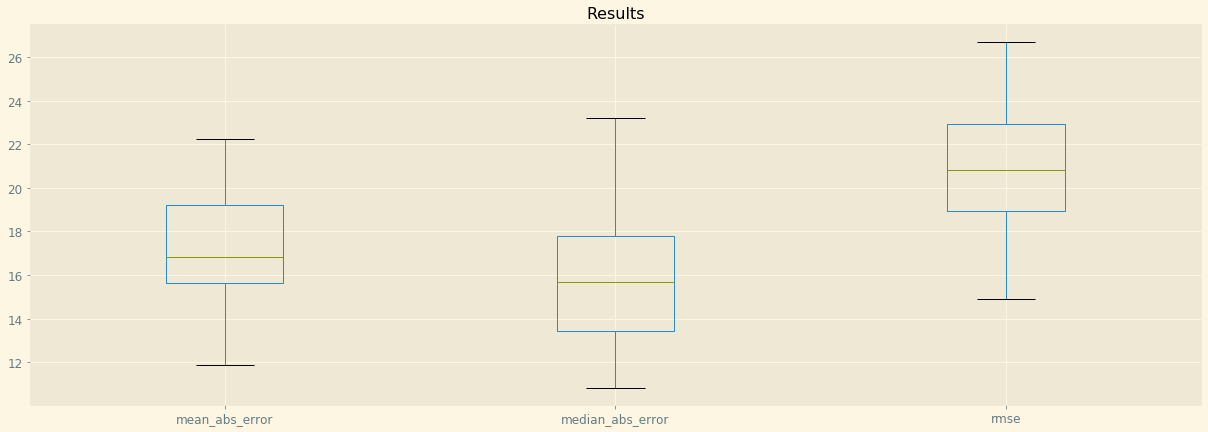

In [6]:
# Plot results statistics

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

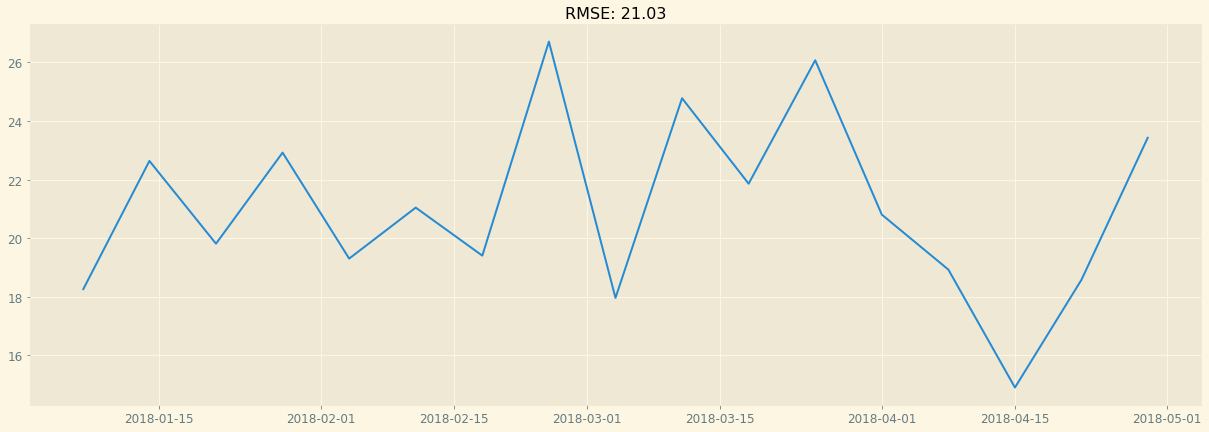

In [7]:
# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

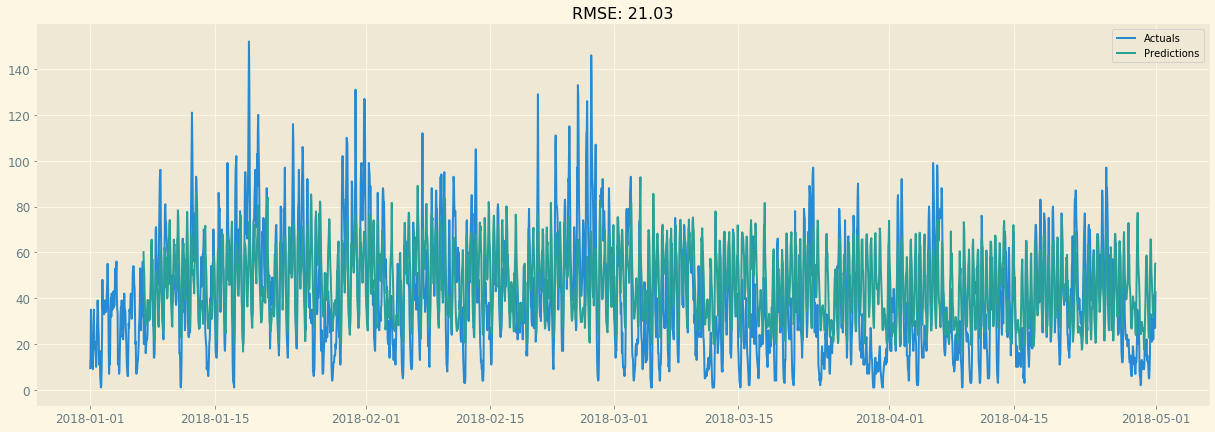

In [8]:
# Plot actuals and predictions overtime

plot_actuals_predictions(oneparticle_onestation[particle_of_interest][min_train_date:], predictions_over_time)

### Rolling autoARIMA: target = bc_particle

In [ ]:
# Generate rolling predictions and results for transformed particle of interest

data = oneparticle_onestation.sort_index().copy()
target = 'bc_particle'

fit_func = fit_autoARIMA
predict_func = predict_autoARIMA

min_train_date = '2018-01-01'

week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    models = train_set.groupby(['weekday', 'hour'])[target].apply(fit_func)
    predictions = test_set.apply(lambda x: predict_func(models.loc[tuple(x[['weekday', 'hour']])], x), axis=1)
    predictions = inv_boxcox(predictions, lamb)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time = pd.DataFrame(results_over_time).drop('models', axis=1).set_index('date').sort_index()
predictions_over_time = pd.concat(predictions_over_time)

2018-01-07 00:00:00
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1407.304, BIC=1429.801, Time=0.239 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1405.891, BIC=1413.390, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1405.731, BIC=1416.979, Time=0.037 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1405.328, BIC=1416.576, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2187.003, BIC=2190.753, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1403.324, BIC=1418.321, Time=0.262 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1405.262, BIC=1424.009, Time=0.355 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1405.264, BIC=1424.011, Time=0.378 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1405.226, BIC=1420.223, Time=0.066 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1115.080, BIC=1133.811, Time=0.387 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1118.196, BIC=1133.181, Time=0.276 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1119.257, BIC=1141.734, Time=0.188 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1117.473, BIC=1136.204, Time=0.197 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1118.954, BIC=1145.178, Time=0.510 seconds
Total fit time: 2.439 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1141.666, BIC=1164.047, Time=0.515 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1155.601, BIC=1163.061, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1141.527, BIC=1152.718, Time=0.083 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1145.231, BIC=1156.421, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1071.177, BIC=1082.416, Time=0.037 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2071.355, BIC=2075.101, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1033.986, BIC=1052.717, Time=0.270 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1057.572, BIC=1072.557, Time=0.069 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1032.887, BIC=1047.872, Time=0.139 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1034.051, BIC=1052.782, Time=0.265 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1037.454, BIC=1052.439, Time=0.139 seconds
Total fit time: 1.391 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1087.885, BIC=1110.343, Time=0.142 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1195.532, BIC=1203.018, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1357.547, BIC=1383.793, Time=0.462 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1359.202, BIC=1374.199, Time=0.362 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1357.888, BIC=1380.384, Time=0.236 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1359.850, BIC=1382.346, Time=0.368 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1359.266, BIC=1389.261, Time=0.647 seconds
Total fit time: 4.570 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1402.462, BIC=1424.958, Time=0.557 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1408.797, BIC=1416.296, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1409.758, BIC=1421.006, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1409.894, BIC=1421.142, Time=0.058 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1162.958, BIC=1177.956, Time=0.409 seconds
Total fit time: 0.980 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1071.561, BIC=1094.057, Time=0.588 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1067.929, BIC=1075.428, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1066.113, BIC=1077.361, Time=0.095 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1066.439, BIC=1077.687, Time=0.062 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2194.662, BIC=2198.411, Time=0.010 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1067.641, BIC=1082.638, Time=0.092 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1067.781, BIC=1082.779, Time=0.382 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1069.629, BIC=1088.376, Time=0.142 seconds
Total fit time: 1.393 seconds
Performing ste

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1074.473, BIC=1096.795, Time=0.427 seconds
Total fit time: 1.986 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1033.764, BIC=1056.222, Time=0.933 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1100.838, BIC=1108.324, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1053.560, BIC=1064.789, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1069.050, BIC=1080.279, Time=0.109 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2109.300, BIC=2113.043, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1033.129, BIC=1051.844, Time=0.593 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1058.286, BIC=1073.258, Time=0.112 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1031.207, BIC=1046.179, Time=0.552 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1303.183, BIC=1321.930, Time=0.730 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1303.188, BIC=1321.935, Time=0.769 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1304.088, BIC=1330.334, Time=0.815 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1303.999, BIC=1330.245, Time=1.186 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1301.208, BIC=1316.205, Time=1.541 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1310.618, BIC=1325.616, Time=0.188 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1307.954, BIC=1322.951, Time=0.175 seconds
Total fit time: 6.414 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1348.005, BIC=1370.483, Time=0.902 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1546.882, BIC=1554.375, Time=0.018 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1381.375, BIC=1400.122, Time=0.564 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1382.558, BIC=1408.804, Time=0.744 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1387.226, BIC=1402.223, Time=0.077 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1382.563, BIC=1405.059, Time=0.128 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1383.415, BIC=1413.410, Time=0.719 seconds
Total fit time: 9.142 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1354.281, BIC=1376.777, Time=0.596 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1357.822, BIC=1365.321, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1358.615, BIC=1369.863, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1358.573, BIC=1369.821, Time=0.054 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1207.411, BIC=1222.344, Time=0.127 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1207.368, BIC=1222.301, Time=0.164 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1209.357, BIC=1228.023, Time=0.553 seconds
Total fit time: 1.314 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1174.603, BIC=1197.023, Time=0.366 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1349.110, BIC=1356.583, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1275.723, BIC=1286.933, Time=0.036 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1172.105, BIC=1183.315, Time=0.254 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1347.114, BIC=1350.850, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1171.669, BIC=1186.615, Time=0.378 seconds
Near non-invertible roots for order (1, 1, 1

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1118.051, BIC=1144.252, Time=0.741 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1118.246, BIC=1144.447, Time=0.668 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1121.041, BIC=1136.013, Time=0.266 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1119.939, BIC=1142.397, Time=0.214 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1121.796, BIC=1144.254, Time=0.241 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1114.525, BIC=1144.469, Time=0.732 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 4.122 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1189.122, BIC=1211.599, Time=0.323 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1258.112, BIC=1265.605, Time

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1386.264, BIC=1404.995, Time=0.427 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1386.679, BIC=1405.410, Time=0.622 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1386.230, BIC=1412.453, Time=0.467 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1386.006, BIC=1412.229, Time=0.381 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1386.262, BIC=1401.247, Time=0.346 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1385.868, BIC=1408.345, Time=0.330 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1385.663, BIC=1408.140, Time=0.304 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1386.762, BIC=1416.732, Time=0.667 seconds
Total fit time: 4.214 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1375.090, BIC=1397.568, Time=0.617 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1243.773, BIC=1266.231, Time=0.577 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1406.461, BIC=1413.947, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1321.129, BIC=1332.358, Time=0.033 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1239.778, BIC=1251.007, Time=0.067 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1404.464, BIC=1408.207, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1240.692, BIC=1255.664, Time=0.165 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1241.043, BIC=1256.015, Time=0.107 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1241.360, BIC=1260.075, Time=0.294 seconds
Total fit time: 1.273 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1218.360, BIC=1240.798, Time=0.516 seconds
F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1081.357, BIC=1103.854, Time=0.742 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1208.416, BIC=1215.915, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1128.435, BIC=1139.683, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1158.208, BIC=1169.456, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2137.980, BIC=2141.730, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1093.100, BIC=1111.847, Time=0.204 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1093.306, BIC=1112.053, Time=0.234 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1094.994, BIC=1121.240, Time=0.601 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1094.793, BIC=1121.039, Time=0.658 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1091.933, BIC=1106.931, Time=0.329 seconds
Fit ARIMA: (1, 0, 3

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1388.933, BIC=1411.429, Time=0.495 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1382.840, BIC=1390.339, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1384.100, BIC=1395.348, Time=0.053 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1384.097, BIC=1395.345, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2221.647, BIC=2225.397, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1386.093, BIC=1401.091, Time=0.056 seconds
Total fit time: 0.688 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1368.851, BIC=1391.347, Time=0.261 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1361.918, BIC=1369.416, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1363.578, BIC=1374.826, Time=0.078 seconds
F

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1173.556, BIC=1192.255, Time=0.314 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1166.417, BIC=1185.116, Time=0.457 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1170.366, BIC=1196.545, Time=0.426 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1171.443, BIC=1197.622, Time=0.567 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1171.098, BIC=1186.057, Time=0.307 seconds
Near non-invertible roots for order 

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1128.375, BIC=1147.106, Time=0.403 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1128.272, BIC=1147.003, Time=0.493 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1127.978, BIC=1154.201, Time=0.803 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1127.345, BIC=1153.569, Time=0.583 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1128.464, BIC=1150.941, Time=0.410 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1123.927, BIC=1153.897, Time=0.708 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1129.810, BIC=1163.526, Time=0.763 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1125.659, BIC=1159.375, Time=0.845 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1127.659, BIC=1157.628, Time=0.693 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1127.772, BIC=1157.742, Time=0.919 seconds
Fit ARIMA: (4, 0, 4)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1293.661, BIC=1316.158, Time=0.625 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1330.705, BIC=1338.204, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1303.227, BIC=1314.476, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1305.097, BIC=1316.345, Time=0.063 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2259.139, BIC=2262.888, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1294.484, BIC=1313.231, Time=0.666 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1295.475, BIC=1314.222, Time=0.482 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1291.941, BIC=1318.186, Time=1.037 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1290.038, BIC=1312.535, Time=0.541 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1295.956, BIC=1314.

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1327.763, BIC=1342.761, Time=0.066 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1326.805, BIC=1341.802, Time=0.335 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1328.422, BIC=1347.169, Time=0.459 seconds
Total fit time: 1.723 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1247.973, BIC=1270.469, Time=0.474 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1246.183, BIC=1253.681, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1244.118, BIC=1255.366, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1244.491, BIC=1255.739, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2032.534, BIC=2036.284, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1245.167, BIC=1260.164, Time=0.056 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1074.101, BIC=1096.598, Time=0.612 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1174.235, BIC=1181.733, Time=0.025 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1100.981, BIC=1112.229, Time=0.064 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1126.896, BIC=1138.144, Time=0.059 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2044.278, BIC=2048.027, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1075.817, BIC=1094.564, Time=0.288 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1075.824, BIC=1094.571, Time=0.330 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1076.103, BIC=1102.349, Time=0.682 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=10

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1320.350, BIC=1342.846, Time=0.419 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1354.261, BIC=1361.760, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1333.346, BIC=1344.594, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1336.681, BIC=1347.930, Time=0.045 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2253.487, BIC=2257.237, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1324.008, BIC=1342.755, Time=0.484 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1324.139, BIC=1342.886, Time=0.501 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1322.168, BIC=1348.414, Time=0.640 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1322.140, BIC=1348.385, Time=0.695 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1322.561, BIC=1337.

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1293.297, BIC=1308.218, Time=0.588 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1295.225, BIC=1313.876, Time=0.553 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1295.221, BIC=1313.871, Time=0.519 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1295.539, BIC=1310.460, Time=0.069 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1295.072, BIC=1309.992, Time=0.120 seconds
Total fit time: 2.590 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1322.026, BIC=1344.522, Time=0.648 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1323.110, BIC=1330.608, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1321.889, BIC=1333.138, Time=0.050 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1322.299, BIC=1333.547, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1175.945, BIC=1194.692, Time=0.407 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1185.922, BIC=1200.919, Time=0.072 seconds
Total fit time: 2.899 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1190.650, BIC=1213.147, Time=0.958 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1231.027, BIC=1238.525, Time=0.022 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1212.012, BIC=1223.261, Time=0.084 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1217.339, BIC=1228.587, Time=0.061 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2038.910, BIC=2042.660, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1189.982, BIC=1208.729, Time=0.472 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1211.773, BIC=1226.771, Time=0.168 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1048.152, BIC=1074.375, Time=0.400 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1045.143, BIC=1060.128, Time=0.308 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1046.484, BIC=1068.961, Time=0.324 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1047.682, BIC=1070.159, Time=0.379 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1032.577, BIC=1062.547, Time=1.648 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 7.272 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1062.517, BIC=1085.013, Time=1.476 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1220.442, BIC=1227.941, Time=0.030 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1127.007, BIC=1138.255, Time

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1353.047, BIC=1364.296, Time=0.100 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2229.359, BIC=2233.108, Time=0.014 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1357.046, BIC=1375.793, Time=0.144 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1350.853, BIC=1369.600, Time=0.469 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1357.299, BIC=1383.545, Time=1.041 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1352.705, BIC=1378.951, Time=0.858 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1350.313, BIC=1365.311, Time=0.263 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1354.710, BIC=1369.708, Time=0.087 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1355.307, BIC=1370.304, Time=0.163 seconds
Total fit time: 4.231 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1094.550, BIC=1109.547, Time=0.295 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1096.528, BIC=1115.275, Time=0.592 seconds
Total fit time: 1.722 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1123.296, BIC=1145.792, Time=0.649 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1133.230, BIC=1140.729, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1121.560, BIC=1132.808, Time=0.112 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1124.328, BIC=1135.577, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2242.008, BIC=2245.757, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1120.373, BIC=1135.371, Time=0.085 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1121.199, BIC=1139.946, Time=0.224 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1030.048, BIC=1048.795, Time=0.389 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1055.603, BIC=1070.601, Time=0.075 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1028.384, BIC=1043.381, Time=0.297 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1030.074, BIC=1048.821, Time=0.404 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1036.396, BIC=1051.393, Time=0.146 seconds
Total fit time: 1.945 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1042.437, BIC=1064.933, Time=0.396 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1135.096, BIC=1142.595, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1051.675, BIC=1062.923, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1077.104, BIC=1088.352, Time=0.043 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1363.166, BIC=1381.929, Time=0.349 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1363.712, BIC=1382.475, Time=0.455 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1360.787, BIC=1387.055, Time=0.563 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1361.100, BIC=1387.368, Time=0.529 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1362.835, BIC=1377.845, Time=0.336 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1361.400, BIC=1383.915, Time=0.178 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1363.365, BIC=1385.880, Time=0.186 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1362.787, BIC=1392.807, Time=0.625 seconds
Total fit time: 3.870 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1406.551, BIC=1429.067, Time=0.447 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1165.641, BIC=1180.651, Time=0.163 seconds
Total fit time: 0.560 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1073.934, BIC=1096.449, Time=0.400 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1070.382, BIC=1077.887, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1068.491, BIC=1079.748, Time=0.063 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1068.821, BIC=1080.078, Time=0.037 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2201.536, BIC=2205.288, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1070.015, BIC=1085.025, Time=0.052 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1070.157, BIC=1085.167, Time=0.279 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1072.003, BIC=1090.766, Time=0.119 seconds
Total fit time: 0.974 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1036.882, BIC=1055.613, Time=0.214 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1063.051, BIC=1078.036, Time=0.063 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1034.926, BIC=1049.911, Time=0.243 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1036.891, BIC=1055.622, Time=0.341 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1046.826, BIC=1061.811, Time=0.051 seconds
Total fit time: 1.459 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1061.029, BIC=1083.526, Time=0.262 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1125.686, BIC=1133.185, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1077.801, BIC=1089.050, Time=0.041 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1093.055, BIC=1104.303, Time=0.038 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1304.387, BIC=1319.397, Time=0.317 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1313.765, BIC=1328.776, Time=0.065 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1311.095, BIC=1326.105, Time=0.059 seconds
Total fit time: 2.611 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1351.499, BIC=1373.995, Time=0.365 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1550.812, BIC=1558.311, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1467.136, BIC=1478.384, Time=0.036 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1351.816, BIC=1363.064, Time=0.095 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1548.813, BIC=1552.562, Time=0.011 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1349.517, BIC=1368.264, Time=0.270 seconds
Near non-invertible roots for order (1, 1, 2

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1385.108, BIC=1407.624, Time=0.280 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1384.159, BIC=1406.674, Time=0.663 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1384.855, BIC=1403.618, Time=0.076 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1385.852, BIC=1412.120, Time=0.928 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1390.781, BIC=1405.791, Time=0.067 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1386.020, BIC=1408.535, Time=0.112 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1386.591, BIC=1416.611, Time=0.715 seconds
Total fit time: 5.141 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1358.204, BIC=1380.720, Time=0.621 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1361.748, BIC=1369.253, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1219.742, BIC=1234.701, Time=0.387 seconds
Total fit time: 1.159 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1210.109, BIC=1232.548, Time=0.696 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1208.319, BIC=1215.799, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1210.301, BIC=1221.521, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1210.303, BIC=1221.522, Time=0.056 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2195.453, BIC=2199.193, Time=0.012 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1212.317, BIC=1227.277, Time=0.113 seconds
Total fit time: 0.966 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1177.561, BIC=1200.000, Time=0.703 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1352.523, BIC=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1124.137, BIC=1142.868, Time=0.374 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1124.579, BIC=1143.310, Time=0.239 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1121.106, BIC=1147.329, Time=0.992 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1120.837, BIC=1147.061, Time=1.093 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1123.781, BIC=1138.766, Time=0.215 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1122.749, BIC=1145.226, Time=0.285 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1124.610, BIC=1147.087, Time=0.347 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1117.463, BIC=1147.433, Time=0.847 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Total fit time: 5.287 seconds
Performing stepwise search t

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1389.710, BIC=1412.206, Time=0.627 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1390.371, BIC=1397.869, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1392.190, BIC=1403.438, Time=0.048 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1392.210, BIC=1403.458, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2124.301, BIC=2128.050, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1390.629, BIC=1409.376, Time=0.328 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1391.058, BIC=1409.805, Time=0.376 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1391.114, BIC=1417.360, Time=0.512 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1390.879, BIC=1417.125, Time=0.496 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1390.740, BIC=1405.738, Time=0.398 seconds
Fit ARIMA: (1, 0, 3

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1203.343, BIC=1222.090, Time=0.374 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1205.597, BIC=1220.595, Time=0.056 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1201.502, BIC=1216.499, Time=0.399 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1203.367, BIC=1222.114, Time=0.437 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1203.300, BIC=1218.297, Time=0.153 seconds
Total fit time: 2.220 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1246.795, BIC=1269.272, Time=0.451 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1410.322, BIC=1417.814, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1324.522, BIC=1335.760, Time=0.038 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1243.060, BIC=1254.299, Time=0.082 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1096.285, BIC=1118.800, Time=0.427 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1097.001, BIC=1119.516, Time=0.285 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1097.370, BIC=1127.390, Time=0.586 seconds
Total fit time: 3.757 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1084.772, BIC=1107.288, Time=0.614 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1211.251, BIC=1218.756, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1131.210, BIC=1142.468, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1160.909, BIC=1172.167, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2144.740, BIC=2148.492, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1095.547, BIC=1114.309, Time=0.228 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1375.498, BIC=1390.508, Time=0.449 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1378.991, BIC=1394.001, Time=0.084 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1378.819, BIC=1393.830, Time=0.100 seconds
Total fit time: 3.797 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1392.064, BIC=1414.579, Time=0.800 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1386.658, BIC=1394.163, Time=0.022 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1387.859, BIC=1399.116, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1387.860, BIC=1399.118, Time=0.054 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2228.346, BIC=2232.098, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1389.848, BIC=1404.858, Time=0.067 seconds
Total fit time: 1.004 seconds
Performing ste

Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1128.294, BIC=1154.562, Time=0.810 seconds
Total fit time: 4.634 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1178.943, BIC=1201.401, Time=0.590 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1366.354, BIC=1373.840, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1257.170, BIC=1268.399, Time=0.050 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1173.670, BIC=1184.899, Time=0.131 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1364.362, BIC=1368.105, Time=0.018 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1175.203, BIC=1190.175, Time=0.232 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1175.312, BIC=1190.284, Time=0.292 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1177.373, BIC=1196.088, Time=0.354 seconds
Total fit time: 1.692 seconds
Performing ste

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1129.974, BIC=1144.972, Time=0.349 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1139.546, BIC=1154.544, Time=0.092 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1133.034, BIC=1148.032, Time=0.082 seconds
Total fit time: 3.664 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1095.750, BIC=1118.246, Time=0.438 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1143.520, BIC=1151.019, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1113.285, BIC=1124.533, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1124.003, BIC=1135.252, Time=0.057 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2128.189, BIC=2131.938, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1094.274, BIC=1113.021, Time=0.422 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1293.129, BIC=1315.645, Time=0.603 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1299.119, BIC=1317.882, Time=0.218 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1295.084, BIC=1321.352, Time=0.846 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1308.323, BIC=1323.333, Time=0.078 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1297.092, BIC=1319.608, Time=0.235 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1297.071, BIC=1327.092, Time=0.662 seconds
Total fit time: 4.950 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1338.493, BIC=1361.008, Time=0.541 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1340.307, BIC=1347.812, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1337.550, BIC=1348.807, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1247.514, BIC=1262.524, Time=0.280 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1249.476, BIC=1268.238, Time=0.300 seconds
Total fit time: 1.316 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1185.293, BIC=1207.808, Time=0.530 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1182.050, BIC=1189.556, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1181.928, BIC=1193.186, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1182.239, BIC=1193.496, Time=0.054 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2067.098, BIC=2070.850, Time=0.015 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1181.587, BIC=1196.598, Time=0.066 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1183.097, BIC=1201.859, Time=0.107 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1072.101, BIC=1098.369, Time=0.611 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1080.807, BIC=1103.323, Time=0.253 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1082.777, BIC=1112.798, Time=0.759 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1078.981, BIC=1109.002, Time=0.801 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1081.363, BIC=1107.631, Time=0.328 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1083.853, BIC=1117.626, Time=0.837 seconds
Total fit time: 5.247 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1075.877, BIC=1098.392, Time=0.566 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1191.135, BIC=1198.641, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1103.719, BIC=1114.977, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1275.018, BIC=1297.534, Time=0.437 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1275.376, BIC=1297.892, Time=0.394 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1266.237, BIC=1296.257, Time=0.935 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 4.247 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1323.574, BIC=1346.089, Time=0.571 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1357.597, BIC=1365.102, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1336.589, BIC=1347.846, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1339.931, BIC=1351.189, Time=0.048 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2260.514, BIC=2264.266, Tim

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1300.669, BIC=1323.069, Time=0.658 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1298.410, BIC=1305.877, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1298.438, BIC=1309.638, Time=0.041 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1298.694, BIC=1309.894, Time=0.039 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2104.087, BIC=2107.820, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1296.829, BIC=1311.762, Time=0.504 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1298.747, BIC=1317.414, Time=0.496 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1298.750, BIC=1317.417, Time=0.488 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1299.168, BIC=1314.102, Time=0.065 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1298.690, BIC=1313.624, Time=0.068 seconds
Total fit time: 2.3

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1179.212, BIC=1197.975, Time=0.409 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1194.974, BIC=1209.984, Time=0.065 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1177.274, BIC=1192.284, Time=0.243 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1179.220, BIC=1197.983, Time=0.352 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1188.949, BIC=1203.959, Time=0.072 seconds
Total fit time: 1.737 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1194.057, BIC=1216.572, Time=0.395 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1233.963, BIC=1241.468, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1214.927, BIC=1226.185, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1220.250, BIC=1231.508, Time=0.045 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1049.483, BIC=1068.230, Time=0.276 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1049.613, BIC=1068.360, Time=0.235 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1039.817, BIC=1066.063, Time=0.608 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1051.132, BIC=1077.378, Time=0.446 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1048.196, BIC=1063.193, Time=0.153 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1049.521, BIC=1072.018, Time=0.234 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1050.696, BIC=1073.192, Time=0.315 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1035.207, BIC=1065.202, Time=0.777 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 3.774 seconds
Performing stepwise search t

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1314.533, BIC=1344.554, Time=0.506 seconds
Total fit time: 5.151 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1353.996, BIC=1376.511, Time=0.773 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1364.927, BIC=1372.432, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1357.112, BIC=1368.370, Time=0.050 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1356.388, BIC=1367.646, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2236.329, BIC=2240.082, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1360.387, BIC=1379.150, Time=0.143 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1354.128, BIC=1372.891, Time=0.412 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1360.616, BIC=1386.884, Time=0.627 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1097.571, BIC=1112.581, Time=0.071 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1097.408, BIC=1112.418, Time=0.243 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1099.541, BIC=1118.304, Time=0.174 seconds
Total fit time: 1.334 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1125.849, BIC=1148.365, Time=0.520 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1135.850, BIC=1143.355, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1124.179, BIC=1135.437, Time=0.097 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1126.966, BIC=1138.224, Time=0.043 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2249.060, BIC=2252.812, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1122.919, BIC=1137.929, Time=0.072 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1032.294, BIC=1051.057, Time=0.284 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1057.937, BIC=1072.948, Time=0.080 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1030.643, BIC=1045.653, Time=0.200 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1032.320, BIC=1051.083, Time=0.387 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1038.740, BIC=1053.750, Time=0.155 seconds
Total fit time: 1.809 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1044.767, BIC=1067.282, Time=0.717 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1137.901, BIC=1145.406, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1054.020, BIC=1065.278, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1079.560, BIC=1090.818, Time=0.045 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1363.744, BIC=1386.279, Time=0.495 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1369.150, BIC=1376.662, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1368.184, BIC=1379.452, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1368.638, BIC=1379.906, Time=0.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2255.956, BIC=2259.712, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1366.462, BIC=1385.240, Time=0.365 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1367.008, BIC=1385.787, Time=0.280 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1364.079, BIC=1390.370, Time=0.441 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1364.387, BIC=1390.677, Time=0.555 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1366.142, BIC=1381.164, Time=0.364 seconds
Fit ARIMA: (1, 0, 3

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1281.849, BIC=1296.872, Time=0.428 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1283.736, BIC=1302.515, Time=0.420 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1286.641, BIC=1301.663, Time=0.067 seconds
Total fit time: 1.965 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1172.528, BIC=1195.062, Time=0.429 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1166.581, BIC=1174.093, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1166.931, BIC=1178.198, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1166.848, BIC=1178.115, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2078.938, BIC=2082.694, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1168.628, BIC=1183.651, Time=0.182 seconds
Total fit time: 0.720 seconds
Performing ste

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1076.844, BIC=1091.752, Time=0.108 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1078.798, BIC=1097.432, Time=0.179 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1078.786, BIC=1097.420, Time=0.228 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1076.793, BIC=1091.700, Time=0.160 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1078.785, BIC=1097.419, Time=0.134 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1080.040, BIC=1102.401, Time=0.292 seconds
Total fit time: 1.563 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1040.734, BIC=1063.230, Time=0.513 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1109.464, BIC=1116.963, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1061.110, BIC=1072.358, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1251.240, BIC=1270.019, Time=0.275 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1259.424, BIC=1274.447, Time=0.133 seconds
Total fit time: 1.343 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1308.953, BIC=1331.488, Time=0.492 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1323.197, BIC=1330.709, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1315.063, BIC=1326.330, Time=0.050 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1316.524, BIC=1327.791, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2284.085, BIC=2287.841, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1309.552, BIC=1328.331, Time=0.527 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1309.560, BIC=1328.338, Time=0.448 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1401.018, BIC=1427.286, Time=0.651 seconds
Total fit time: 2.736 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1391.497, BIC=1414.031, Time=0.530 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1399.174, BIC=1406.686, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1396.969, BIC=1408.236, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1397.017, BIC=1408.284, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2079.105, BIC=2082.861, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1393.924, BIC=1412.703, Time=0.461 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1396.482, BIC=1415.261, Time=0.472 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1392.861, BIC=1419.151, Time=0.542 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1153.838, BIC=1172.601, Time=0.474 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1154.636, BIC=1169.647, Time=0.072 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1152.612, BIC=1167.622, Time=0.371 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1153.842, BIC=1172.605, Time=0.538 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1153.219, BIC=1168.229, Time=0.222 seconds
Total fit time: 2.369 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1193.578, BIC=1216.075, Time=0.655 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1197.743, BIC=1205.242, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1195.501, BIC=1206.749, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1195.990, BIC=1207.238, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1052.360, BIC=1067.357, Time=0.248 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1054.223, BIC=1072.970, Time=0.256 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1061.347, BIC=1076.344, Time=0.061 seconds
Total fit time: 1.578 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1086.232, BIC=1108.728, Time=0.292 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1190.991, BIC=1198.490, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1107.124, BIC=1118.372, Time=0.075 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1133.256, BIC=1144.504, Time=0.049 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2149.496, BIC=2153.246, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1088.235, BIC=1106.982, Time=0.216 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1367.988, BIC=1386.750, Time=0.432 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1368.668, BIC=1387.431, Time=0.398 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1370.692, BIC=1396.960, Time=0.682 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1370.696, BIC=1396.964, Time=0.762 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1370.026, BIC=1385.036, Time=0.339 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1369.252, BIC=1391.768, Time=0.144 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1368.752, BIC=1391.268, Time=0.484 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1372.726, BIC=1402.747, Time=0.730 seconds
Total fit time: 4.710 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1359.843, BIC=1382.358, Time=0.619 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1173.585, BIC=1188.595, Time=0.279 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1175.311, BIC=1194.074, Time=0.315 seconds
Total fit time: 1.454 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1092.760, BIC=1115.275, Time=0.518 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1089.635, BIC=1097.140, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1090.729, BIC=1101.987, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1090.836, BIC=1102.094, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2196.756, BIC=2200.508, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1091.261, BIC=1106.271, Time=0.461 seconds
Total fit time: 1.091 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1116.144, BIC=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1130.764, BIC=1149.511, Time=0.353 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1147.074, BIC=1162.071, Time=0.067 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1129.944, BIC=1144.941, Time=0.227 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1131.095, BIC=1149.842, Time=0.393 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1141.445, BIC=1156.442, Time=0.199 seconds
Total fit time: 2.053 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1106.373, BIC=1128.908, Time=0.304 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1164.962, BIC=1172.474, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1123.632, BIC=1134.899, Time=0.087 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1135.926, BIC=1147.193, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1358.767, BIC=1377.546, Time=0.547 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1362.417, BIC=1377.440, Time=0.092 seconds
Total fit time: 2.340 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1381.219, BIC=1403.753, Time=0.621 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1382.871, BIC=1390.382, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1382.006, BIC=1393.273, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1382.293, BIC=1393.560, Time=0.056 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2272.652, BIC=2276.407, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1381.818, BIC=1400.597, Time=0.564 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1382.256, BIC=1401.034, Time=0.537 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1128.138, BIC=1143.161, Time=0.436 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1127.599, BIC=1146.377, Time=0.516 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1127.779, BIC=1142.802, Time=0.066 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1129.012, BIC=1151.546, Time=0.177 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1127.382, BIC=1146.161, Time=0.515 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1128.317, BIC=1143.340, Time=0.056 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1129.297, BIC=1151.831, Time=0.481 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1127.378, BIC=1146.157, Time=0.065 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1129.362, BIC=1151.896, Time=0.116 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1131.314, BIC=1157.604, Time=0.160 seconds
Total fit time: 3.25

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1137.244, BIC=1156.006, Time=0.332 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1137.180, BIC=1155.943, Time=0.411 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1137.048, BIC=1163.316, Time=0.482 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1136.447, BIC=1162.715, Time=0.413 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1137.691, BIC=1160.206, Time=0.497 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1132.494, BIC=1162.515, Time=0.625 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1138.657, BIC=1172.430, Time=0.758 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1135.780, BIC=1169.553, Time=0.863 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1136.456, BIC=1166.476, Time=0.604 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1136.810, BIC=1166.830, Time=0.712 seconds
Fit ARIMA: (4, 0, 4)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1301.112, BIC=1323.646, Time=0.520 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1339.071, BIC=1346.582, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1311.272, BIC=1322.539, Time=0.050 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1313.084, BIC=1324.351, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2274.302, BIC=2278.058, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1301.954, BIC=1320.733, Time=0.370 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1302.981, BIC=1321.760, Time=0.362 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1299.063, BIC=1325.353, Time=0.558 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1297.203, BIC=1319.738, Time=0.449 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1303.780, BIC=1322.

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1335.821, BIC=1358.356, Time=0.525 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1335.734, BIC=1343.245, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1333.417, BIC=1344.684, Time=0.041 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1333.552, BIC=1344.819, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2037.947, BIC=2041.703, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1335.296, BIC=1350.319, Time=0.055 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1334.295, BIC=1349.318, Time=0.361 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1335.664, BIC=1354.443, Time=0.491 seconds
Total fit time: 1.538 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1254.566, BIC=1277.101, Time=0.496 seconds
F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1098.594, BIC=1117.372, Time=0.245 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1121.420, BIC=1136.442, Time=0.065 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1097.975, BIC=1112.998, Time=0.250 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1098.716, BIC=1117.495, Time=0.375 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1108.439, BIC=1123.462, Time=0.083 seconds
Total fit time: 1.571 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1080.131, BIC=1102.665, Time=0.475 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1182.798, BIC=1190.309, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1106.990, BIC=1118.258, Time=0.052 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1133.685, BIC=1144.952, Time=0.043 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1278.523, BIC=1301.057, Time=0.239 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1278.878, BIC=1301.413, Time=0.378 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1267.959, BIC=1298.005, Time=0.750 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Total fit time: 3.402 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1327.345, BIC=1349.880, Time=0.365 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1361.479, BIC=1368.990, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1340.527, BIC=1351.794, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1343.831, BIC=1355.099, Time=0.054 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2268.014, BIC=2271.769, Tim

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1329.152, BIC=1347.931, Time=0.497 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1331.016, BIC=1346.039, Time=0.217 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1327.157, BIC=1342.180, Time=0.418 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1329.225, BIC=1348.003, Time=0.417 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1330.263, BIC=1345.286, Time=0.057 seconds
Total fit time: 2.318 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1307.687, BIC=1330.221, Time=0.482 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1316.232, BIC=1323.744, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1314.031, BIC=1325.299, Time=0.118 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1314.507, BIC=1325.774, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1196.645, BIC=1215.424, Time=0.299 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1210.142, BIC=1225.165, Time=0.058 seconds
Total fit time: 1.443 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1147.682, BIC=1170.217, Time=0.371 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1211.507, BIC=1219.018, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1176.834, BIC=1188.101, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1186.500, BIC=1197.768, Time=0.043 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2051.886, BIC=2055.642, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1148.065, BIC=1166.843, Time=0.265 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1148.157, BIC=1166.935, Time=0.278 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1054.490, BIC=1077.005, Time=0.285 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1038.914, BIC=1068.935, Time=0.629 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 3.361 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1069.001, BIC=1091.536, Time=0.546 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1227.784, BIC=1235.295, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1135.639, BIC=1146.906, Time=0.101 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1174.836, BIC=1186.103, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1988.729, BIC=1992.484, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1088.939, BIC=1107.718, Tim

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1357.425, BIC=1376.203, Time=0.304 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1364.284, BIC=1390.574, Time=0.523 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1359.294, BIC=1385.584, Time=0.574 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1356.897, BIC=1371.920, Time=0.188 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1361.329, BIC=1376.352, Time=0.055 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1361.930, BIC=1376.953, Time=0.079 seconds
Total fit time: 2.376 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1418.076, BIC=1440.629, Time=0.237 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1416.658, BIC=1424.176, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1416.617, BIC=1427.894, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1125.487, BIC=1140.510, Time=0.072 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1126.314, BIC=1145.093, Time=0.175 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1125.351, BIC=1144.129, Time=0.359 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1126.836, BIC=1141.859, Time=0.188 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1128.316, BIC=1150.850, Time=0.186 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1126.429, BIC=1145.207, Time=0.272 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1128.986, BIC=1155.277, Time=0.555 seconds
Total fit time: 2.423 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1150.673, BIC=1173.112, Time=0.473 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1163.973, BIC=1171.453, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1048.417, BIC=1070.951, Time=0.480 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1142.903, BIC=1150.415, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1058.668, BIC=1069.935, Time=0.109 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1085.156, BIC=1096.423, Time=0.045 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2092.611, BIC=2096.366, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1046.677, BIC=1065.455, Time=0.223 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1070.648, BIC=1085.671, Time=0.071 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1045.575, BIC=1060.598, Time=0.157 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1046.687, BIC=1065.466, Time=0.263 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1050.554, BIC=1065.577, Time=0.143 seconds
Total fit time: 1.5

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1369.857, BIC=1399.929, Time=0.592 seconds
Total fit time: 3.343 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1413.567, BIC=1436.120, Time=0.441 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1419.433, BIC=1426.950, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1420.462, BIC=1431.739, Time=0.030 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1420.588, BIC=1431.865, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2225.811, BIC=2229.570, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1419.184, BIC=1437.979, Time=0.313 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1419.781, BIC=1438.576, Time=0.311 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1418.158, BIC=1444.471, Time=0.230 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1078.676, BIC=1101.230, Time=0.332 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1075.148, BIC=1082.666, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1073.231, BIC=1084.508, Time=0.076 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1073.564, BIC=1084.840, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2215.426, BIC=2219.184, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1074.757, BIC=1089.792, Time=0.064 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1074.897, BIC=1089.932, Time=0.264 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1076.745, BIC=1095.539, Time=0.092 seconds
Total fit time: 0.891 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1113.567, BIC=1136.101, Time=0.471 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1042.527, BIC=1061.290, Time=0.339 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1069.065, BIC=1084.075, Time=0.080 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1040.535, BIC=1055.545, Time=0.291 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1042.529, BIC=1061.292, Time=0.280 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1052.656, BIC=1067.666, Time=0.057 seconds
Total fit time: 1.719 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1067.266, BIC=1089.801, Time=0.297 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1134.437, BIC=1141.949, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1084.228, BIC=1095.495, Time=0.036 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1100.345, BIC=1111.613, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1359.250, BIC=1381.785, Time=0.358 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1559.794, BIC=1567.305, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1475.436, BIC=1486.703, Time=0.037 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1359.683, BIC=1370.950, Time=0.143 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1557.794, BIC=1561.549, Time=0.014 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1357.266, BIC=1376.045, Time=0.324 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1361.516, BIC=1376.539, Time=0.128 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1361.516, BIC=1376.539, Time=0.133 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1359.251, BIC=1381.786, Time=0.473 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1363.514, BIC=1382.

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1396.493, BIC=1422.805, Time=0.386 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1402.396, BIC=1417.431, Time=0.194 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1395.304, BIC=1417.857, Time=0.323 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1394.896, BIC=1417.449, Time=0.378 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1394.924, BIC=1413.719, Time=0.095 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1396.704, BIC=1423.017, Time=0.528 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1402.289, BIC=1417.325, Time=0.063 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1396.178, BIC=1418.731, Time=0.108 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1397.539, BIC=1427.610, Time=0.567 seconds
Total fit time: 4.440 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1196.487, BIC=1219.003, Time=0.466 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1200.812, BIC=1208.317, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1198.444, BIC=1209.701, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1198.939, BIC=1210.197, Time=0.033 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2278.235, BIC=2281.988, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1195.865, BIC=1214.628, Time=0.393 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1199.985, BIC=1214.995, Time=0.057 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1194.064, BIC=1209.074, Time=0.321 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1195.901, BIC=1214.664, Time=0.417 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1198.874, BIC=1213.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1091.338, BIC=1110.100, Time=0.295 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1091.356, BIC=1110.119, Time=0.251 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1089.936, BIC=1116.204, Time=0.512 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1089.717, BIC=1115.985, Time=0.345 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1089.397, BIC=1104.408, Time=0.236 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1089.255, BIC=1111.771, Time=0.223 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1090.691, BIC=1113.206, Time=0.276 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1089.861, BIC=1119.882, Time=0.662 seconds
Total fit time: 3.183 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1122.218, BIC=1144.734, Time=0.558 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1372.484, BIC=1398.774, Time=0.445 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1372.348, BIC=1398.638, Time=0.577 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1374.872, BIC=1389.895, Time=0.384 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1370.373, BIC=1392.907, Time=0.313 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1370.605, BIC=1393.139, Time=0.392 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1374.204, BIC=1404.250, Time=1.098 seconds
Total fit time: 4.552 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1396.872, BIC=1419.406, Time=0.708 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1397.593, BIC=1405.104, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1399.412, BIC=1410.679, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1117.836, BIC=1136.615, Time=0.408 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1119.953, BIC=1134.976, Time=0.084 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1117.246, BIC=1132.269, Time=0.430 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1117.996, BIC=1136.775, Time=0.452 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1117.740, BIC=1132.763, Time=0.066 seconds
Total fit time: 2.193 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1211.819, BIC=1234.353, Time=0.598 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1220.684, BIC=1228.195, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1211.848, BIC=1223.116, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1213.821, BIC=1225.088, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1103.804, BIC=1126.357, Time=1.348 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1199.876, BIC=1207.393, Time=0.039 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1142.098, BIC=1153.375, Time=0.162 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1162.019, BIC=1173.296, Time=0.073 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2118.335, BIC=2122.094, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1108.225, BIC=1127.020, Time=0.562 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1108.591, BIC=1127.385, Time=0.449 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1107.905, BIC=1134.218, Time=0.703 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1108.794, BIC=1135.106, Time=1.031 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1107.448, BIC=1122.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1386.777, BIC=1405.572, Time=1.064 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1386.757, BIC=1405.551, Time=0.627 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1388.066, BIC=1414.379, Time=0.695 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1388.293, BIC=1414.606, Time=0.741 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1384.375, BIC=1399.411, Time=0.487 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1387.984, BIC=1403.020, Time=0.090 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1387.800, BIC=1402.836, Time=0.111 second

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1130.851, BIC=1145.886, Time=0.521 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1130.313, BIC=1149.108, Time=0.550 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1130.407, BIC=1145.442, Time=0.140 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1131.781, BIC=1154.334, Time=0.274 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1130.115, BIC=1148.910, Time=1.269 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1130.944, BIC=1145.979, Time=0.103 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1132.087, BIC=1154.640, Time=0.146 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1130.149, BIC=1148.944, Time=0.099 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1133.147, BIC=1159.460, Time=0.741 seconds
Total fit time: 4.739 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2194.999, BIC=2198.755, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1145.440, BIC=1164.218, Time=0.587 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1145.411, BIC=1164.190, Time=0.453 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1145.971, BIC=1172.261, Time=0.624 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1145.736, BIC=1172.026, Time=0.433 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1143.946, BIC=1158.969, Time=0.411 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1149.254, BIC=1164.277, Time=0.077 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1145.925, BIC=1160.948, Time=0.222 seconds
Total fit time: 3.661 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1140.384, BIC=1162.918, Time=0.456 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1230.819, BIC=1257.131, Time=0.840 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1248.507, BIC=1278.578, Time=0.331 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1247.659, BIC=1277.731, Time=0.288 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1245.480, BIC=1271.792, Time=0.461 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1231.235, BIC=1257.547, Time=0.851 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1234.667, BIC=1268.497, Time=0.969 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 5.426 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1304.372, BIC=1326.926, Time=0.566 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1342.303, BIC=1349.821, Time

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1357.947, BIC=1372.982, Time=0.429 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1359.927, BIC=1378.721, Time=1.151 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1360.081, BIC=1378.876, Time=0.490 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1360.461, BIC=1375.497, Time=0.059 seconds
Total fit time: 3.038 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1341.379, BIC=1363.933, Time=0.650 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1340.869, BIC=1348.386, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1338.898, BIC=1350.175, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1339.017, BIC=1350.293, Time=0.064 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2043.628, BIC=2047.387, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1138.730, BIC=1150.006, Time=0.075 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2082.808, BIC=2086.567, Time=0.013 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1102.711, BIC=1121.505, Time=0.591 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1124.989, BIC=1140.025, Time=0.117 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1102.005, BIC=1117.041, Time=0.223 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1102.841, BIC=1121.636, Time=0.589 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1112.446, BIC=1127.481, Time=0.164 seconds
Total fit time: 2.669 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1083.868, BIC=1106.421, Time=0.899 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1185.540, BIC=1193.058, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1194.204, BIC=1216.757, Time=0.582 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1196.966, BIC=1227.037, Time=1.064 seconds
Total fit time: 5.406 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1278.546, BIC=1301.100, Time=0.419 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1362.550, BIC=1370.068, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1308.179, BIC=1319.456, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1324.754, BIC=1336.031, Time=0.062 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2223.302, BIC=2227.061, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1282.046, BIC=1300.841, Time=0.361 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1282.046, BIC=1300.841, Time=0.467 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2116.864, BIC=2120.604, Time=0.161 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1308.587, BIC=1323.546, Time=0.062 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1306.623, BIC=1321.583, Time=0.384 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1308.530, BIC=1327.229, Time=0.530 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1308.525, BIC=1327.224, Time=3.520 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1309.079, BIC=1324.038, Time=0.262 seconds
Total fit time: 5.598 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1333.723, BIC=1356.276, Time=0.802 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1335.016, BIC=1342.534, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1334.002, BIC=1345.279, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1200.117, BIC=1218.912, Time=0.476 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1221.745, BIC=1236.781, Time=0.088 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1198.475, BIC=1213.511, Time=0.300 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1200.168, BIC=1218.963, Time=0.498 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1214.280, BIC=1229.316, Time=0.079 seconds
Total fit time: 2.103 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1150.920, BIC=1173.474, Time=0.563 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1215.553, BIC=1223.071, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1180.855, BIC=1192.132, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1190.618, BIC=1201.895, Time=0.068 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1091.672, BIC=1110.467, Time=0.171 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1091.910, BIC=1110.705, Time=0.317 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1080.436, BIC=1106.748, Time=0.780 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1094.962, BIC=1121.274, Time=0.740 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1091.924, BIC=1106.959, Time=0.183 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1093.106, BIC=1115.659, Time=0.285 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1093.682, BIC=1116.236, Time=0.294 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1074.302, BIC=1104.373, Time=0.861 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 4.396 seconds
Performing stepwise search t

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2214.634, BIC=2218.396, Time=0.202 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1418.365, BIC=1433.413, Time=0.332 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1420.329, BIC=1439.139, Time=0.381 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1420.329, BIC=1439.139, Time=0.380 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1420.456, BIC=1435.504, Time=0.071 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1421.077, BIC=1436.126, Time=0.076 seconds
Total fit time: 1.822 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1433.699, BIC=1456.271, Time=0.347 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1430.893, BIC=1438.417, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1431.471, BIC=1442.757, Time=0.120 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1132.640, BIC=1158.952, Time=0.573 seconds
Total fit time: 2.789 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1155.117, BIC=1177.575, Time=0.648 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1168.561, BIC=1176.047, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1154.626, BIC=1165.855, Time=0.083 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1158.204, BIC=1169.433, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2238.765, BIC=2242.508, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1151.735, BIC=1166.707, Time=0.071 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1153.723, BIC=1172.438, Time=0.092 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1153.718, BIC=1172.434, Time=0.374 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2099.691, BIC=2103.450, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1049.144, BIC=1067.939, Time=0.319 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1073.510, BIC=1088.545, Time=0.081 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1048.065, BIC=1063.101, Time=0.291 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1049.156, BIC=1067.951, Time=0.300 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1053.020, BIC=1068.056, Time=0.088 seconds
Total fit time: 2.032 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1101.793, BIC=1124.328, Time=0.218 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1211.169, BIC=1218.681, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1121.163, BIC=1132.431, Time=0.145 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1373.136, BIC=1395.709, Time=0.218 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1375.116, BIC=1397.688, Time=0.209 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1374.674, BIC=1404.770, Time=0.649 seconds
Total fit time: 3.854 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1417.274, BIC=1439.846, Time=0.529 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1423.814, BIC=1431.338, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1424.816, BIC=1436.102, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1424.946, BIC=1436.232, Time=0.054 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2233.333, BIC=2237.096, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1423.553, BIC=1442.363, Time=0.378 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1174.551, BIC=1189.599, Time=0.215 seconds
Total fit time: 1.183 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1081.302, BIC=1103.875, Time=0.553 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1077.772, BIC=1085.296, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1075.842, BIC=1087.128, Time=0.107 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1076.176, BIC=1087.462, Time=0.058 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2222.226, BIC=2225.988, Time=0.034 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1077.365, BIC=1092.413, Time=0.097 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1077.501, BIC=1092.549, Time=0.366 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1079.234, BIC=1098.045, Time=0.637 seconds
Total fit time: 1.875 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1044.983, BIC=1063.762, Time=0.366 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1072.083, BIC=1087.106, Time=0.078 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1042.991, BIC=1058.014, Time=0.346 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1044.985, BIC=1063.763, Time=0.323 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1055.229, BIC=1070.252, Time=0.061 seconds
Total fit time: 1.882 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1069.679, BIC=1092.233, Time=0.346 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1138.017, BIC=1145.534, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1086.893, BIC=1098.170, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1103.340, BIC=1114.617, Time=0.047 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1315.409, BIC=1330.457, Time=0.368 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1324.852, BIC=1339.900, Time=0.075 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1322.192, BIC=1337.240, Time=0.073 seconds
Total fit time: 3.414 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1362.618, BIC=1385.172, Time=0.452 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1563.728, BIC=1571.246, Time=0.016 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1479.516, BIC=1490.793, Time=0.048 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1363.079, BIC=1374.356, Time=0.172 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1561.728, BIC=1565.487, Time=0.012 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1360.633, BIC=1379.428, Time=0.316 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1400.985, BIC=1419.795, Time=0.641 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1407.916, BIC=1426.726, Time=0.122 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1399.661, BIC=1425.996, Time=0.542 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1400.046, BIC=1426.380, Time=0.570 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1405.881, BIC=1420.929, Time=0.283 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1398.781, BIC=1421.354, Time=0.376 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1398.392, BIC=1420.964, Time=0.390 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1401.733, BIC=1431.829, Time=0.673 seconds
Total fit time: 4.297 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1370.838, BIC=1393.410, Time=0.580 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1196.836, BIC=1211.859, Time=0.385 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1198.739, BIC=1217.518, Time=0.438 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1201.661, BIC=1216.684, Time=0.074 seconds
Total fit time: 2.163 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1234.270, BIC=1256.767, Time=0.651 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1230.650, BIC=1238.148, Time=0.021 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1232.483, BIC=1243.731, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1232.487, BIC=1243.735, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2246.595, BIC=2250.345, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1231.248, BIC=1246.246, Time=0.421 seconds
Total fit time: 1.199 seconds
Performing ste

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1094.504, BIC=1120.794, Time=0.395 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1093.575, BIC=1108.598, Time=0.233 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1130.098, BIC=1145.121, Time=0.078 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1103.922, BIC=1118.945, Time=0.112 seconds
Total fit time: 2.481 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1125.852, BIC=1148.387, Time=0.609 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1233.661, BIC=1241.173, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1165.797, BIC=1177.064, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1190.532, BIC=1201.800, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2213.500, BIC=2217.256, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1377.456, BIC=1396.251, Time=0.423 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1378.215, BIC=1397.010, Time=0.390 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1376.335, BIC=1402.647, Time=0.695 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1376.189, BIC=1402.502, Time=0.725 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1378.459, BIC=1393.495, Time=0.396 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1374.190, BIC=1396.743, Time=0.356 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1374.056, BIC=1392.850, Time=0.078 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1379.015, BIC=1394.051, Time=0.068 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1374.940, BIC=1397.494, Time=0.120 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1376.189, BIC=1402.502, Time=0.400 seconds
Total fit time: 4.48

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1122.315, BIC=1141.109, Time=0.290 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1124.207, BIC=1139.242, Time=0.064 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1121.819, BIC=1136.855, Time=0.342 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1122.492, BIC=1141.287, Time=0.500 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1122.042, BIC=1137.077, Time=0.064 seconds
Total fit time: 1.895 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1215.304, BIC=1237.857, Time=0.526 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1224.562, BIC=1232.080, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1215.516, BIC=1226.793, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1217.559, BIC=1228.836, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1109.763, BIC=1132.335, Time=0.595 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1203.711, BIC=1211.235, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1145.581, BIC=1156.867, Time=0.117 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1166.000, BIC=1177.286, Time=0.047 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2125.485, BIC=2129.247, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1111.137, BIC=1129.947, Time=0.226 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1111.504, BIC=1130.314, Time=0.355 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1111.341, BIC=1137.676, Time=0.390 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1112.115, BIC=1138.449, Time=0.456 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1110.419, BIC=1125.

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1405.032, BIC=1427.604, Time=0.553 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1399.065, BIC=1406.589, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1400.242, BIC=1411.528, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1400.241, BIC=1411.527, Time=0.045 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2248.753, BIC=2252.515, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1402.235, BIC=1417.283, Time=0.059 seconds
Total fit time: 0.732 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1385.433, BIC=1408.006, Time=0.297 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1378.511, BIC=1386.035, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1380.237, BIC=1391.523, Time=0.206 seconds
F

Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1182.879, BIC=1209.147, Time=0.957 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1183.423, BIC=1198.433, Time=0.282 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1180.206, BIC=1202.721, Time=0.824 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1180.468, BIC=1202.984, Time=0.747 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1183.945, BIC=1213.965, Time=0.999 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 6.640 seconds
Perfor

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1106.106, BIC=1128.660, Time=0.358 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1154.513, BIC=1162.031, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1122.714, BIC=1133.991, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1133.724, BIC=1145.000, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2149.149, BIC=2152.908, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1104.592, BIC=1123.386, Time=0.366 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1118.461, BIC=1133.497, Time=0.063 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1102.699, BIC=1117.735, Time=0.233 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1104.581, BIC=1123.376, Time=0.362 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1108.865, BIC=1123.

Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1307.514, BIC=1330.087, Time=0.229 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1307.393, BIC=1337.489, Time=0.800 seconds
Total fit time: 4.906 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1349.585, BIC=1372.158, Time=0.507 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1351.704, BIC=1359.228, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1348.863, BIC=1360.149, Time=0.041 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1347.887, BIC=1359.173, Time=0.048 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2317.431, BIC=2321.193, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1347.742, BIC=1362.791, Time=0.206 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1349.421, BIC=1368.231, Time=0.405 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1262.095, BIC=1280.906, Time=0.391 seconds
Total fit time: 1.350 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1197.925, BIC=1220.497, Time=0.223 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1194.256, BIC=1201.780, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1194.536, BIC=1205.822, Time=0.050 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1194.782, BIC=1206.068, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2087.618, BIC=2091.380, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1194.679, BIC=1209.727, Time=0.402 seconds
Total fit time: 0.741 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1184.611, BIC=1207.183, Time=0.563 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1180.103, BIC=

Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1087.502, BIC=1117.598, Time=0.804 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1089.632, BIC=1115.967, Time=0.320 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1089.772, BIC=1123.631, Time=0.840 seconds
Total fit time: 5.209 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1085.427, BIC=1107.999, Time=0.427 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1200.632, BIC=1208.156, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1111.834, BIC=1123.120, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1143.718, BIC=1155.004, Time=0.048 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2022.414, BIC=2026.176, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1085.399, BIC=1104.210, Time=0.213 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1338.904, BIC=1369.001, Time=0.691 seconds
Total fit time: 4.578 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1345.543, BIC=1368.116, Time=0.517 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1362.909, BIC=1370.433, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1351.083, BIC=1362.369, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1350.817, BIC=1362.103, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2311.663, BIC=2315.425, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1350.709, BIC=1369.520, Time=0.464 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1355.080, BIC=1373.891, Time=0.110 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1347.430, BIC=1373.764, Time=0.592 seconds
Near non-invertible roots for order (3, 0, 2

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1325.517, BIC=1351.852, Time=0.768 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1325.631, BIC=1351.965, Time=0.673 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1319.882, BIC=1334.931, Time=0.366 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1323.845, BIC=1346.417, Time=0.545 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1323.726, BIC=1346.298, Time=0.626 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1325.950, BIC=1356.046, Time=0.673 seconds
Total fit time: 5.648 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1295.729, BIC=1318.282, Time=0.357 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1482.984, BIC=1490.501, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1393.510, BIC=1404.787, Time=0.040 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1096.807, BIC=1119.379, Time=0.902 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1186.763, BIC=1194.287, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1142.690, BIC=1153.976, Time=0.102 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1159.325, BIC=1170.611, Time=0.082 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2055.525, BIC=2059.287, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1104.540, BIC=1123.351, Time=0.314 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1104.717, BIC=1123.527, Time=0.403 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1104.203, BIC=1130.538, Time=0.699 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1107.656, BIC=1133.990, Time=0.304 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1104.329, BIC=1119.

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1148.903, BIC=1163.951, Time=0.385 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1149.589, BIC=1168.399, Time=0.211 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1158.190, BIC=1173.238, Time=0.088 seconds
Total fit time: 1.468 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1193.178, BIC=1215.751, Time=0.325 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1341.375, BIC=1348.899, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1218.977, BIC=1230.263, Time=0.101 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1266.273, BIC=1277.559, Time=0.078 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2140.949, BIC=2144.711, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1191.287, BIC=1210.097, Time=0.329 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1443.304, BIC=1465.895, Time=0.195 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1440.430, BIC=1447.961, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1439.472, BIC=1450.768, Time=0.223 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1438.991, BIC=1450.287, Time=0.059 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2122.271, BIC=2126.036, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1439.304, BIC=1454.365, Time=0.169 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1439.538, BIC=1454.599, Time=0.064 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1441.188, BIC=1460.014, Time=0.268 seconds
Total fit time: 1.005 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1433.088, BIC=1455.680, Time=0.235 seconds
F

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1185.159, BIC=1200.131, Time=0.185 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1184.891, BIC=1199.863, Time=0.255 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1186.820, BIC=1205.535, Time=0.344 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1186.789, BIC=1205.504, Time=0.257 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1186.386, BIC=1201.358, Time=0.061 seconds
Total fit time: 1.502 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1142.901, BIC=1165.243, Time=0.490 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1151.279, BIC=1158.726, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1142.846, BIC=1154.017, Time=0.053 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1144.537, BIC=1155.708, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1161.966, BIC=1184.538, Time=0.479 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1283.340, BIC=1290.864, Time=0.026 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1198.938, BIC=1210.224, Time=0.076 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1235.184, BIC=1246.471, Time=0.068 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2210.378, BIC=2214.140, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1159.980, BIC=1178.790, Time=0.433 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1201.438, BIC=1216.486, Time=0.086 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1160.958, BIC=1176.007, Time=0.252 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1161.971, BIC=1184.543, Time=0.329 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1189.257, BIC=1208.068, Time=0.313 seconds
Fit ARIMA: (2, 0, 1

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1420.757, BIC=1443.348, Time=0.542 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1417.694, BIC=1425.225, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1416.551, BIC=1427.846, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1416.811, BIC=1428.106, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2184.225, BIC=2187.990, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1417.883, BIC=1432.944, Time=0.068 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1416.760, BIC=1431.821, Time=0.441 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1418.759, BIC=1437.585, Time=0.435 seconds
Total fit time: 1.597 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1433.874, BIC=1456.465, Time=0.587 seconds
F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1116.931, BIC=1135.742, Time=0.329 seconds
Total fit time: 1.402 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1181.518, BIC=1204.052, Time=0.268 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1191.252, BIC=1198.763, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1177.457, BIC=1188.725, Time=0.061 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1178.894, BIC=1190.161, Time=0.052 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2281.747, BIC=2285.503, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1178.904, BIC=1193.927, Time=0.458 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1178.075, BIC=1193.098, Time=0.586 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1179.497, BIC=1198.276, Time=0.602 seconds
Total fit time: 2.052 seconds
Performing ste

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1070.236, BIC=1089.046, Time=0.320 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1078.330, BIC=1093.379, Time=0.121 seconds
Total fit time: 1.623 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1081.630, BIC=1104.222, Time=0.371 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1175.669, BIC=1183.199, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1104.496, BIC=1115.791, Time=0.082 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1131.264, BIC=1142.559, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2132.862, BIC=2136.627, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1080.808, BIC=1099.634, Time=0.260 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1109.548, BIC=1124.609, Time=0.095 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1372.980, BIC=1399.315, Time=0.682 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1369.873, BIC=1384.921, Time=0.172 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1367.558, BIC=1390.131, Time=0.672 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1371.397, BIC=1393.969, Time=0.521 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1374.331, BIC=1404.428, Time=0.515 seconds
Total fit time: 4.305 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1400.084, BIC=1422.657, Time=0.344 seconds
Fit ARIMA: (0, 1, 0)x(0

Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1403.543, BIC=1429.900, Time=0.745 seconds
Total fit time: 4.190 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1374.134, BIC=1396.725, Time=0.530 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1379.343, BIC=1386.873, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1379.878, BIC=1391.173, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1379.825, BIC=1391.120, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2049.706, BIC=2053.471, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1380.825, BIC=1399.651, Time=0.479 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1383.873, BIC=1402.699, Time=0.122 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1377.588, BIC=1403.944, Time=0.363 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1201.479, BIC=1216.514, Time=0.378 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1203.351, BIC=1222.146, Time=0.484 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1206.328, BIC=1221.363, Time=0.077 seconds
Total fit time: 2.216 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1239.604, BIC=1262.100, Time=0.403 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1440.455, BIC=1447.954, Time=0.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1353.828, BIC=1365.076, Time=0.050 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1234.607, BIC=1245.856, Time=0.168 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1438.455, BIC=1442.205, Time=0.011 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1236.604, BIC=1251.601, Time=0.253 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1099.580, BIC=1118.375, Time=0.213 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1099.600, BIC=1118.394, Time=0.249 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1099.161, BIC=1125.473, Time=0.515 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1098.944, BIC=1125.256, Time=0.588 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1097.643, BIC=1112.679, Time=0.174 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1133.590, BIC=1148.626, Time=0.075 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1108.050, BIC=1123.085, Time=0.110 seconds
Total fit time: 2.417 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1128.983, BIC=1151.536, Time=0.652 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1236.589, BIC=1244.106, Time=0.022 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1384.702, BIC=1395.988, Time=0.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2204.090, BIC=2207.852, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1382.434, BIC=1401.244, Time=0.342 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1383.133, BIC=1401.943, Time=0.387 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1381.646, BIC=1407.980, Time=0.465 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1381.682, BIC=1408.016, Time=0.754 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1383.308, BIC=1398.356, Time=0.643 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1379.707, BIC=1402.279, Time=0.525 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1379.701, BIC=1402.273, Time=0.308 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1383.486, BIC=1413.582, Time=0.693 seconds
Total fit time: 4.9

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1124.898, BIC=1143.708, Time=0.350 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1126.788, BIC=1141.836, Time=0.069 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1124.406, BIC=1139.454, Time=0.393 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1125.071, BIC=1143.881, Time=0.511 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1124.637, BIC=1139.685, Time=0.065 seconds
Total fit time: 2.138 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1218.277, BIC=1240.850, Time=0.739 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1227.494, BIC=1235.018, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1218.340, BIC=1229.627, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1220.401, BIC=1231.687, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1104.978, BIC=1127.570, Time=0.585 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1207.012, BIC=1214.542, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1148.269, BIC=1159.564, Time=0.100 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1168.830, BIC=1180.125, Time=0.048 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2132.468, BIC=2136.233, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1113.645, BIC=1132.471, Time=0.215 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1114.015, BIC=1132.841, Time=0.240 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1113.797, BIC=1140.153, Time=0.388 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1114.594, BIC=1140.950, Time=0.448 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1112.928, BIC=1127.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1395.801, BIC=1414.627, Time=0.458 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1396.177, BIC=1415.003, Time=0.427 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1397.806, BIC=1424.162, Time=0.566 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1397.553, BIC=1423.910, Time=0.636 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1393.815, BIC=1408.876, Time=0.392 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1397.420, BIC=1412.481, Time=0.074 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1397.239, BIC=1412.299, Time=0.091 second

Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1183.324, BIC=1205.859, Time=0.609 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1380.322, BIC=1387.834, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1269.600, BIC=1280.867, Time=0.041 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1184.789, BIC=1196.056, Time=0.132 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1378.326, BIC=1382.082, Time=0.012 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1188.480, BIC=1207.258, Time=0.314 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1181.924, BIC=1200.703, Time=0.505 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1185.008, BIC=1211.298, Time=0.614 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1150.231, BIC=1172.803, Time=0.630 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1187.979, BIC=1195.503, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1169.132, BIC=1180.418, Time=0.063 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1176.028, BIC=1187.314, Time=0.876 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2178.128, BIC=2181.890, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1150.405, BIC=1169.215, Time=2.623 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1150.355, BIC=1169.165, Time=0.482 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1151.185, BIC=1177.519, Time=0.599 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1150.728, BIC=1177.062, Time=0.545 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1148.699, BIC=1163.

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1311.119, BIC=1333.710, Time=0.436 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1349.563, BIC=1357.093, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1321.688, BIC=1332.984, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1323.430, BIC=1334.726, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2296.178, BIC=2299.943, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1312.098, BIC=1330.923, Time=0.344 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1313.122, BIC=1331.948, Time=0.350 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1308.918, BIC=1335.275, Time=0.443 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1307.020, BIC=1329.611, Time=0.388 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1313.656, BIC=1332.

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1348.073, BIC=1363.134, Time=0.327 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1349.814, BIC=1368.640, Time=0.387 seconds
Total fit time: 1.418 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1266.816, BIC=1289.407, Time=0.435 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1264.427, BIC=1271.958, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1262.957, BIC=1274.253, Time=0.034 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1263.280, BIC=1274.576, Time=0.038 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2065.214, BIC=2068.979, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1263.976, BIC=1279.036, Time=0.052 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1263.343, BIC=1278.403, Time=0.282 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1090.210, BIC=1109.036, Time=0.203 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1090.229, BIC=1109.055, Time=0.212 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1090.701, BIC=1117.057, Time=0.493 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1084.859, BIC=1111.215, Time=0.577 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1091.880, BIC=1114.472, Time=0.352 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1095.889, BIC=1126.011, Time=0.467 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1090.391, BIC=1120.513, Time=0.705 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1092.016, BIC=1118.373, Time=0.254 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=109

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1342.829, BIC=1361.655, Time=0.284 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1342.962, BIC=1361.788, Time=0.486 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1340.637, BIC=1366.993, Time=0.512 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1340.596, BIC=1366.952, Time=0.388 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1341.363, BIC=1356.423, Time=0.315 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1341.804, BIC=1364.395, Time=0.342 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1342.006, BIC=1364.597, Time=0.438 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1342.439, BIC=1372.560, Time=0.597 seconds
Total fit time: 3.903 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1349.427, BIC=1372.019, Time=0.426 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1323.796, BIC=1346.368, Time=0.575 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1508.425, BIC=1515.949, Time=0.011 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1424.357, BIC=1435.643, Time=0.033 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1324.979, BIC=1336.265, Time=0.078 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1506.429, BIC=1510.191, Time=0.012 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1322.035, BIC=1340.845, Time=0.478 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1327.499, BIC=1346.310, Time=0.396 seconds
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1324.409, BIC=1350.744, Time=0.576 seconds
Near non-inver

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1159.220, BIC=1178.046, Time=0.235 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1159.341, BIC=1178.167, Time=0.246 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1158.148, BIC=1184.504, Time=0.441 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1158.367, BIC=1180.958, Time=0.359 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1150.814, BIC=1180.936, Time=0.649 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1160.051, BIC=1186.407, Time=0.507 seconds
Fit ARIMA: (5, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1157.714, BIC=1191.601, Time=0.553 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1160.003, BIC=1193.890, Time=0.689 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1152.712, BIC=1182.834, Time=0.685 seconds
Fit ARIMA: (5, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1156.647, BIC=1186.769, Time=0.508 seconds
Fit ARIMA: (5, 0, 3)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1153.766, BIC=1176.357, Time=0.249 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1293.136, BIC=1300.667, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1193.773, BIC=1205.068, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1236.873, BIC=1248.168, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2080.905, BIC=2084.671, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1152.218, BIC=1171.044, Time=0.206 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1201.121, BIC=1216.181, Time=0.077 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1151.640, BIC=1166.700, Time=0.143 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1152.271, BIC=1171.097, Time=0.188 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1160.902, BIC=1175.

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1443.416, BIC=1466.026, Time=0.496 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1440.938, BIC=1448.475, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1441.309, BIC=1452.614, Time=0.053 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1441.063, BIC=1452.368, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2177.114, BIC=2180.882, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1439.675, BIC=1454.748, Time=0.258 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1441.620, BIC=1460.462, Time=0.381 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1441.617, BIC=1460.459, Time=0.408 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1441.606, BIC=1456.680, Time=0.057 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1442.065, BIC=1457.138, Time=0.065 seconds
Total fit time: 1.7

Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1159.381, BIC=1178.128, Time=0.091 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1159.388, BIC=1178.135, Time=0.099 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1158.275, BIC=1173.273, Time=0.261 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1161.379, BIC=1183.875, Time=0.124 seconds
Total fit time: 1.238 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1191.655, BIC=1214.133, Time=0.282 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1198.125, BIC=1205.617, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1187.718, BIC=1198.957, Time=0.054 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1189.476, BIC=1200.715, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2220.424, BIC=2224.170, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1104.799, BIC=1123.609, Time=0.201 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1137.407, BIC=1152.455, Time=0.072 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1102.803, BIC=1117.851, Time=0.225 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1104.799, BIC=1123.609, Time=0.233 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1109.555, BIC=1124.603, Time=0.071 seconds
Total fit time: 1.153 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1164.581, BIC=1187.173, Time=0.282 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1286.674, BIC=1294.204, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1202.043, BIC=1213.339, Time=0.110 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1238.497, BIC=1249.793, Time=0.043 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1431.338, BIC=1457.716, Time=0.375 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1432.032, BIC=1447.105, Time=0.360 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1430.468, BIC=1453.078, Time=0.311 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1431.882, BIC=1454.492, Time=0.462 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1432.267, BIC=1462.414, Time=0.652 seconds
Total fit time: 3.472 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1425.557, BIC=1448.167, Time=0.491 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1422.338, BIC=1429.875, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1421.428, BIC=1432.733, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1421.676, BIC=1432.981, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1119.419, BIC=1134.479, Time=0.195 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1119.209, BIC=1134.270, Time=0.220 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1121.165, BIC=1139.990, Time=0.346 seconds
Total fit time: 1.217 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1185.413, BIC=1207.966, Time=0.455 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1195.690, BIC=1203.208, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1181.847, BIC=1193.123, Time=0.053 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1183.261, BIC=1194.537, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2289.437, BIC=2293.195, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1183.337, BIC=1198.373, Time=0.195 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1072.591, BIC=1091.417, Time=0.296 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1097.219, BIC=1112.280, Time=0.105 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1070.602, BIC=1085.663, Time=0.196 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1072.593, BIC=1091.418, Time=0.356 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1080.699, BIC=1095.760, Time=0.101 seconds
Total fit time: 1.608 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1084.014, BIC=1106.624, Time=0.194 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1178.765, BIC=1186.302, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1107.464, BIC=1118.769, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1134.397, BIC=1145.702, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1374.893, BIC=1397.484, Time=0.494 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1379.212, BIC=1398.037, Time=0.267 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1379.223, BIC=1398.049, Time=0.271 seconds
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1380.916, BIC=1407.272, Time=0.846 seconds
Total fit time: 3.374 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1407.378, BIC=1429.969, Time=0.499 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1622.717, BIC=1630.248, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1538.957, BIC=1550.252, Time=0.033 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1408.691, BIC=1419.986, Time=0.218 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit 

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1387.299, BIC=1406.141, Time=0.613 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1387.577, BIC=1406.419, Time=0.453 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1384.065, BIC=1410.443, Time=0.616 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1383.570, BIC=1409.948, Time=0.174 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1388.544, BIC=1403.617, Time=0.115 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1381.705, BIC=1404.315, Time=0.203 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1382.094, BIC=1404.704, Time=0.325 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1385.523, BIC=1415.670, Time=0.506 seconds
Total fit time: 3.824 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1370.448, BIC=1393.058, Time=0.349 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1238.916, BIC=1253.939, Time=0.389 seconds
Total fit time: 0.941 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1232.215, BIC=1254.731, Time=0.439 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1441.951, BIC=1449.456, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1342.845, BIC=1354.103, Time=0.046 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1227.024, BIC=1238.282, Time=0.127 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1439.952, BIC=1443.704, Time=0.011 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1228.483, BIC=1243.493, Time=0.123 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1228.471, BIC=1243.481, Time=0.187 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1230.469, BIC=1249.232, Time=0.400 seconds
Total fit time: 1.352 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1142.132, BIC=1160.942, Time=0.291 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1142.417, BIC=1161.227, Time=0.215 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1141.336, BIC=1167.670, Time=0.604 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1138.752, BIC=1165.087, Time=0.618 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1141.263, BIC=1156.311, Time=0.170 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1141.099, BIC=1163.672, Time=0.292 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1142.662, BIC=1165.234, Time=0.404 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1131.606, BIC=1161.703, Time=0.701 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 3.984 seconds
Performing stepwise search t

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1409.483, BIC=1428.309, Time=0.439 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1409.839, BIC=1428.665, Time=0.432 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1410.041, BIC=1436.397, Time=0.588 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1409.851, BIC=1436.207, Time=0.497 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1409.305, BIC=1424.366, Time=0.376 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1409.367, BIC=1431.958, Time=0.445 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1409.191, BIC=1431.782, Time=0.384 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1410.373, BIC=1440.495, Time=0.692 seconds
Total fit time: 4.533 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1397.548, BIC=1420.139, Time=0.608 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1220.066, BIC=1238.892, Time=0.524 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1218.130, BIC=1233.191, Time=0.296 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1220.056, BIC=1238.882, Time=0.438 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1222.019, BIC=1237.079, Time=0.052 seconds
Total fit time: 2.262 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1264.377, BIC=1286.949, Time=0.432 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1429.946, BIC=1437.470, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1344.755, BIC=1356.041, Time=0.038 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1260.465, BIC=1271.751, Time=0.071 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1427.947, BIC=1431.709, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1113.704, BIC=1136.314, Time=0.241 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1114.110, BIC=1136.720, Time=0.319 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1115.817, BIC=1145.964, Time=0.719 seconds
Total fit time: 3.823 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1106.981, BIC=1129.591, Time=0.520 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1251.542, BIC=1259.078, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1158.884, BIC=1170.189, Time=0.066 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1195.875, BIC=1207.180, Time=0.048 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2230.648, BIC=2234.416, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1117.056, BIC=1135.897, Time=0.267 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1389.820, BIC=1404.893, Time=0.223 seconds
Total fit time: 0.712 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1403.273, BIC=1425.883, Time=0.588 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1397.322, BIC=1404.858, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1398.882, BIC=1410.187, Time=0.091 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1398.886, BIC=1410.191, Time=0.039 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2180.133, BIC=2183.901, Time=0.012 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1400.897, BIC=1415.970, Time=0.084 seconds
Total fit time: 0.830 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1391.605, BIC=1414.215, Time=0.511 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1391.317, BIC=

Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1207.719, BIC=1226.498, Time=0.432 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1211.214, BIC=1237.505, Time=0.295 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1210.102, BIC=1236.392, Time=0.427 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1209.877, BIC=1224.900, Time=0.354 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1089.206, BIC=1104.279, Time=0.191 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1091.158, BIC=1109.999, Time=0.267 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1096.189, BIC=1111.262, Time=0.156 seconds
Total fit time: 1.210 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1108.734, BIC=1131.306, Time=0.478 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1202.973, BIC=1210.497, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1120.949, BIC=1132.236, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1149.635, BIC=1160.921, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2132.330, BIC=2136.092, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1106.908, BIC=1125.719, Time=0.291 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1386.234, BIC=1401.307, Time=0.325 seconds
Total fit time: 0.947 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1402.912, BIC=1425.522, Time=0.501 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1400.668, BIC=1408.204, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1401.969, BIC=1413.274, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1402.019, BIC=1413.324, Time=0.037 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2268.499, BIC=2272.267, Time=0.006 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1400.291, BIC=1415.364, Time=0.388 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1401.727, BIC=1420.568, Time=0.444 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1401.928, BIC=1420.769, Time=0.445 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1210.239, BIC=1225.312, Time=0.351 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1211.835, BIC=1230.676, Time=0.526 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1211.837, BIC=1230.679, Time=0.409 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1213.276, BIC=1228.349, Time=0.084 seconds
Total fit time: 2.055 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1224.764, BIC=1247.374, Time=0.489 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1241.316, BIC=1248.853, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1229.339, BIC=1240.644, Time=0.046 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1230.900, BIC=1242.205, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2157.243, BIC=2161.011, Time=0.010 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1112.708, BIC=1131.534, Time=0.197 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1112.708, BIC=1131.534, Time=0.201 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1113.240, BIC=1139.596, Time=0.468 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1102.492, BIC=1128.848, Time=0.677 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1110.706, BIC=1133.297, Time=0.318 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1095.998, BIC=1126.120, Time=0.748 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1108.171, BIC=1138.292, Time=0.662 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1112.595, BIC=1138.951, Time=0.264 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=110

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1357.829, BIC=1380.439, Time=0.437 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1355.249, BIC=1385.395, Time=0.583 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Total fit time: 4.409 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1382.926, BIC=1405.536, Time=0.478 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1390.946, BIC=1398.482, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1389.070, BIC=1400.375, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1389.003, BIC=1400.308, Time=0.049 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2315.431, BIC=2319.200, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1389.322, BIC=1408.163, Tim

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1250.121, BIC=1268.962, Time=0.538 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1253.547, BIC=1268.620, Time=0.064 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1249.606, BIC=1264.679, Time=0.390 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1250.410, BIC=1269.252, Time=0.433 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1253.094, BIC=1268.167, Time=0.059 seconds
Total fit time: 2.842 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1231.756, BIC=1254.366, Time=0.570 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1230.712, BIC=1238.249, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1231.079, BIC=1242.384, Time=0.033 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1231.295, BIC=1242.600, Time=0.031 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1058.208, BIC=1080.818, Time=0.539 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1186.526, BIC=1194.063, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1115.656, BIC=1126.961, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1143.441, BIC=1154.746, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2062.754, BIC=2066.523, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1072.556, BIC=1091.398, Time=0.183 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1072.727, BIC=1091.569, Time=0.211 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1058.025, BIC=1084.404, Time=0.624 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1074.178, BIC=1096.788, Time=0.376 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1073.755, BIC=1103.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1244.118, BIC=1262.960, Time=0.159 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1285.599, BIC=1300.672, Time=0.070 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1242.139, BIC=1257.213, Time=0.153 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1244.121, BIC=1262.962, Time=0.256 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1252.770, BIC=1267.843, Time=0.091 seconds
Total fit time: 1.227 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1276.620, BIC=1299.230, Time=0.315 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1338.821, BIC=1346.358, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1294.810, BIC=1306.115, Time=0.148 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1305.797, BIC=1317.102, Time=0.057 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1429.357, BIC=1451.986, Time=0.533 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1424.273, BIC=1431.816, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1423.963, BIC=1435.277, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1423.894, BIC=1435.209, Time=0.039 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2016.414, BIC=2020.186, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1425.850, BIC=1440.936, Time=0.186 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1425.855, BIC=1440.940, Time=0.056 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1427.893, BIC=1446.750, Time=0.077 seconds
Total fit time: 0.984 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1390.327, BIC=1412.956, Time=0.489 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1071.780, BIC=1094.062, Time=0.448 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1096.914, BIC=1104.342, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1083.618, BIC=1094.759, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1087.459, BIC=1098.600, Time=0.038 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2090.486, BIC=2094.200, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1069.664, BIC=1088.233, Time=0.366 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1082.569, BIC=1097.423, Time=0.056 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1067.846, BIC=1082.701, Time=0.390 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1069.663, BIC=1088.231, Time=0.391 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1075.969, BIC=1090.

Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1169.841, BIC=1196.219, Time=0.299 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1172.668, BIC=1206.583, Time=0.759 seconds
Total fit time: 5.970 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1218.379, BIC=1241.008, Time=0.473 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1325.714, BIC=1333.257, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1245.449, BIC=1256.764, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1276.652, BIC=1287.966, Time=0.047 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2275.050, BIC=2278.821, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1216.494, BIC=1235.351, Time=0.335 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1252.075, BIC=1267.161, Time=0.068 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1440.355, BIC=1459.212, Time=0.469 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1438.728, BIC=1453.814, Time=0.594 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1440.349, BIC=1459.206, Time=0.641 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1440.145, BIC=1455.231, Time=0.056 seconds
Total fit time: 2.761 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1443.234, BIC=1465.863, Time=0.404 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1439.455, BIC=1446.998, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1439.297, BIC=1450.611, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1439.524, BIC=1450.838, Time=0.038 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2092.916, BIC=2096.687, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1210.634, BIC=1225.669, Time=0.058 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1208.387, BIC=1223.423, Time=0.428 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1209.493, BIC=1228.287, Time=0.386 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1208.722, BIC=1227.517, Time=0.466 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1211.086, BIC=1226.122, Time=0.059 seconds
Total fit time: 2.066 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1191.621, BIC=1214.175, Time=0.402 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1205.029, BIC=1212.547, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1193.499, BIC=1204.776, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1195.072, BIC=1206.349, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1086.008, BIC=1104.865, Time=0.320 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1092.626, BIC=1107.712, Time=0.076 seconds
Total fit time: 1.122 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1103.398, BIC=1126.027, Time=0.214 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1228.353, BIC=1235.896, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1132.996, BIC=1144.310, Time=0.111 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1172.420, BIC=1183.734, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2187.144, BIC=2190.915, Time=0.005 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1102.160, BIC=1121.017, Time=0.276 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1142.881, BIC=1157.967, Time=0.070 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1415.741, BIC=1434.583, Time=0.391 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1412.461, BIC=1438.839, Time=0.505 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1413.111, BIC=1439.489, Time=0.629 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1414.178, BIC=1429.251, Time=0.271 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1373.984, BIC=1396.612, Time=0.333 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1376.049, BIC=1383.592, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1375.825, BIC=1387.140, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1375.785, BIC=1387.099, Time=0.035 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2017.353, BIC=2021.124, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1376.068, BIC=1394.925, Time=0.528 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1377.386, BIC=1396.244, Time=0.406 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1372.751, BIC=1399.151, Time=0.339 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1370.950, BIC=1393.579, Time=0.350 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1369.375, BIC=1388.232, Time=0.159 seconds
Fit ARIMA: (2, 0, 0

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1234.434, BIC=1253.212, Time=0.324 seconds
Total fit time: 1.201 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1198.589, BIC=1221.142, Time=0.509 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1375.601, BIC=1383.119, Time=0.012 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1301.837, BIC=1313.113, Time=0.033 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1196.436, BIC=1207.712, Time=0.269 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1373.606, BIC=1377.365, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1195.364, BIC=1210.400, Time=0.379 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1195.481, BIC=1210.516, Tim

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1216.384, BIC=1238.994, Time=0.417 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1284.580, BIC=1292.117, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1235.162, BIC=1246.467, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1247.955, BIC=1259.260, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2283.009, BIC=2286.777, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1216.135, BIC=1234.977, Time=0.248 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1243.792, BIC=1258.865, Time=0.077 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1214.146, BIC=1229.219, Time=0.224 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1216.139, BIC=1234.981, Time=0.275 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1227.279, BIC=1242.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1407.220, BIC=1426.062, Time=0.380 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1407.361, BIC=1426.202, Time=0.469 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1409.850, BIC=1436.228, Time=0.640 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1409.807, BIC=1436.185, Time=0.293 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1405.908, BIC=1420.981, Time=0.318 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1407.809, BIC=1430.419, Time=0.097 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1408.016, BIC=1430.626, Time=0.132 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1411.152, BIC=1441.298, Time=0.618 seconds
Total fit time: 3.564 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1415.192, BIC=1437.801, Time=0.484 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1248.237, BIC=1267.047, Time=0.110 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1244.879, BIC=1263.689, Time=0.373 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1245.395, BIC=1271.729, Time=0.532 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1242.104, BIC=1268.439, Time=0.636 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1246.197, BIC=1261.245, Time=0.116 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (c

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1119.514, BIC=1138.371, Time=0.190 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1119.754, BIC=1138.611, Time=0.219 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1108.158, BIC=1134.558, Time=0.612 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1120.523, BIC=1143.152, Time=0.384 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1122.905, BIC=1153.076, Time=0.865 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1095.283, BIC=1125.455, Time=0.816 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1105.774, BIC=1132.174, Time=0.673 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1097.342, BIC=1131.285, Time=0.874 seconds
Near non-invertible roots for order (4, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=110

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1395.866, BIC=1418.494, Time=0.588 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1395.361, BIC=1402.903, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1396.949, BIC=1408.264, Time=0.084 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1396.982, BIC=1408.296, Time=0.036 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2139.199, BIC=2142.970, Time=0.163 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1398.844, BIC=1413.929, Time=0.223 seconds
Total fit time: 1.116 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1393.173, BIC=1415.802, Time=0.561 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1392.169, BIC=1399.711, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1393.881, BIC=1405.195, Time=0.099 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1213.308, BIC=1228.344, Time=0.431 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1211.430, BIC=1233.984, Time=0.546 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1212.655, BIC=1235.209, Time=0.480 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1211.783, BIC=1241.854, Time=0.854 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1109.465, BIC=1128.291, Time=0.201 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1129.860, BIC=1144.921, Time=0.063 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1108.464, BIC=1123.525, Time=0.214 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1109.318, BIC=1128.144, Time=0.297 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1113.207, BIC=1128.268, Time=0.104 seconds
Total fit time: 1.485 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1132.834, BIC=1155.425, Time=0.380 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1246.753, BIC=1254.283, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1146.938, BIC=1158.233, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1180.602, BIC=1191.897, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1405.052, BIC=1420.137, Time=0.312 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1406.552, BIC=1425.409, Time=0.394 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1406.527, BIC=1425.384, Time=0.396 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1408.484, BIC=1423.570, Time=0.060 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1408.328, BIC=1423.414, Time=0.064 seconds
Total fit time: 1.846 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1398.381, BIC=1421.009, Time=0.508 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1394.349, BIC=1401.892, Time=0.008 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1395.908, BIC=1407.222, Time=0.095 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1395.953, BIC=1407.267, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1228.339, BIC=1250.967, Time=0.563 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1245.305, BIC=1252.848, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1233.238, BIC=1244.552, Time=0.047 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1234.928, BIC=1246.242, Time=0.039 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2164.476, BIC=2168.247, Time=0.014 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1227.182, BIC=1246.039, Time=0.529 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1235.696, BIC=1250.781, Time=0.047 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1225.587, BIC=1240.673, Time=0.467 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1227.270, BIC=1246.127, Time=0.393 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1233.709, BIC=1248.

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1101.709, BIC=1128.087, Time=0.638 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1113.159, BIC=1135.769, Time=0.203 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1099.199, BIC=1129.345, Time=0.667 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1110.197, BIC=1140.343, Time=0.620 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1115.051, BIC=1141.430, Time=0.253 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1110.598, BIC=1144.513, Time=0.809 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Total fit time: 4.438 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1363.589, BIC=1386.218, Time=0.523 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1364.433, BIC=1387.062, Time=0.488 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1361.963, BIC=1392.134, Time=0.640 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 4.146 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1388.515, BIC=1411.143, Time=0.504 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1396.316, BIC=1403.858, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1394.739, BIC=1406.053, Time=0.040 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1394.710, BIC=1406.024, Time=0.038 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2323.371, BIC=2327.142, Tim

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1253.466, BIC=1272.324, Time=0.491 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1256.637, BIC=1271.722, Time=0.056 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1252.785, BIC=1267.870, Time=0.344 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1253.718, BIC=1272.575, Time=0.380 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1256.174, BIC=1271.260, Time=0.062 seconds
Total fit time: 2.111 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1234.567, BIC=1257.195, Time=0.467 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1233.544, BIC=1241.087, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1233.913, BIC=1245.227, Time=0.027 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1234.128, BIC=1245.443, Time=0.034 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1108.824, BIC=1138.996, Time=0.703 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Total fit time: 3.516 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1057.849, BIC=1080.478, Time=0.493 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1189.500, BIC=1197.043, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1118.226, BIC=1129.540, Time=0.054 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1146.307, BIC=1157.622, Time=0.045 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2069.408, BIC=2073.179, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1074.895, BIC=1093.752, Time=0.195 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1075.064, BIC=1093.921, Tim

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1247.285, BIC=1266.142, Time=0.184 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1289.061, BIC=1304.147, Time=0.068 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1245.302, BIC=1260.388, Time=0.210 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1247.287, BIC=1266.144, Time=0.196 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1256.107, BIC=1271.192, Time=0.113 seconds
Total fit time: 1.233 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1279.661, BIC=1302.290, Time=0.383 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1342.164, BIC=1349.707, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1297.842, BIC=1309.156, Time=0.150 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1308.885, BIC=1320.199, Time=0.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1446.567, BIC=1465.440, Time=0.329 seconds
Total fit time: 1.132 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1434.357, BIC=1457.004, Time=0.558 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1429.393, BIC=1436.942, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1429.137, BIC=1440.460, Time=0.064 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1429.045, BIC=1440.368, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2023.747, BIC=2027.522, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1430.969, BIC=1446.068, Time=0.211 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1430.967, BIC=1446.065, Time=0.050 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1432.963, BIC=1451.836, Time=0.201 seconds
Total fit time: 1.150 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1152.024, BIC=1170.691, Time=0.487 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1156.054, BIC=1170.987, Time=0.058 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1150.071, BIC=1165.004, Time=0.371 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1152.021, BIC=1170.688, Time=0.442 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1153.642, BIC=1168.575, Time=0.116 seconds
Total fit time: 2.094 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1077.023, BIC=1099.326, Time=0.564 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1103.135, BIC=1110.569, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1089.611, BIC=1100.762, Time=0.061 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1093.542, BIC=1104.694, Time=0.054 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1168.312, BIC=1194.712, Time=0.761 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1169.193, BIC=1199.365, Time=1.039 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1174.047, BIC=1204.219, Time=0.722 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1168.170, BIC=1194.570, Time=0.737 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1169.548, BIC=1199.720, Time=1.061 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1172.526, BIC=1198.926, Time=0.373 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1176.127, BIC=1210.070, Time=0.826 seconds
Total fit time: 8.544 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1221.902, BIC=1244.549, Time=0.624 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1329.486, BIC=1337.035, Time=0.035 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1444.064, BIC=1459.162, Time=0.159 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1445.578, BIC=1464.451, Time=0.201 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1445.115, BIC=1463.988, Time=0.457 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1443.437, BIC=1458.535, Time=0.293 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1445.103, BIC=1463.976, Time=0.325 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1444.997, BIC=1460.095, Time=0.462 seconds
Total fit time: 3.011 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1448.716, BIC=1471.363, Time=0.516 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1444.859, BIC=1452.408, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1444.788, BIC=1456.112, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1213.831, BIC=1228.880, Time=0.075 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1211.469, BIC=1226.517, Time=0.395 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1212.467, BIC=1231.277, Time=0.484 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1211.971, BIC=1230.781, Time=0.522 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1214.366, BIC=1229.414, Time=0.077 seconds
Total fit time: 2.642 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1195.172, BIC=1217.744, Time=0.551 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1209.053, BIC=1216.577, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1197.351, BIC=1208.638, Time=0.054 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1198.996, BIC=1210.282, Time=0.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1109.454, BIC=1132.101, Time=0.629 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1233.744, BIC=1241.294, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1140.304, BIC=1151.628, Time=0.112 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1179.058, BIC=1190.381, Time=0.055 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2194.732, BIC=2198.506, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1108.234, BIC=1127.106, Time=0.268 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1149.477, BIC=1164.576, Time=0.098 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1107.053, BIC=1122.151, Time=0.226 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1108.300, BIC=1127.173, Time=0.306 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1114.553, BIC=1129.

Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1415.923, BIC=1442.323, Time=0.365 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1416.462, BIC=1442.862, Time=0.902 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1417.558, BIC=1432.644, Time=0.449 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1414.238, BIC=1436.866, Time=0.780 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1380.482, BIC=1399.355, Time=0.693 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1383.986, BIC=1402.859, Time=0.129 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1376.679, BIC=1403.101, Time=0.595 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1374.919, BIC=1397.566, Time=0.557 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1373.355, BIC=1392.228, Time=0.209 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1381.652, BIC=1396.750, Time=0.078 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1374.833, BIC=1397.480, Time=0.167 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1376.816, BIC=1403.238, Time=0.569 seconds
Total fit time: 3.535 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1323.783, BIC=1346.430, Time=0.646 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1198.296, BIC=1213.345, Time=0.517 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1198.404, BIC=1213.452, Time=0.469 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1196.532, BIC=1215.343, Time=0.709 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 2.528 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1137.489, BIC=1160.080, Time=0.595 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1165.8

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1219.026, BIC=1237.884, Time=0.672 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1246.776, BIC=1261.861, Time=0.118 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1217.038, BIC=1232.124, Time=0.302 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1219.030, BIC=1237.888, Time=0.508 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1230.121, BIC=1245.207, Time=0.367 seconds
Total fit time: 2.864 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1287.000, BIC=1309.610, Time=0.551 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1314.956, BIC=1322.492, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1298.177, BIC=1309.482, Time=0.060 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1301.952, BIC=1313.257, Time=0.061 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1410.795, BIC=1429.653, Time=0.378 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1410.939, BIC=1429.797, Time=0.363 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1413.390, BIC=1439.790, Time=0.537 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1413.356, BIC=1439.756, Time=0.422 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1409.492, BIC=1424.578, Time=0.372 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1411.358, BIC=1433.986, Time=0.116 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1411.563, BIC=1434.192, Time=0.669 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1414.709, BIC=1444.880, Time=0.631 seconds
Total fit time: 4.187 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1420.433, BIC=1443.062, Time=0.351 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1251.392, BIC=1270.218, Time=0.117 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1247.864, BIC=1266.690, Time=0.429 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1248.723, BIC=1275.080, Time=0.582 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1245.075, BIC=1271.431, Time=0.706 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1249.354, BIC=1264.415, Time=0.109 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (c

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1122.503, BIC=1141.375, Time=0.229 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1122.745, BIC=1141.617, Time=0.225 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1112.362, BIC=1138.784, Time=0.675 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1105.721, BIC=1132.143, Time=0.651 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1122.695, BIC=1145.342, Time=0.269 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1099.053, BIC=1129.250, Time=0.825 seconds
Fit ARIMA: (4, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1126.185, BIC=1160.156, Time=0.396 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1100.549, BIC=1134.520, Time=0.937 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=111

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1404.924, BIC=1420.022, Time=0.207 seconds
Total fit time: 0.925 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1399.303, BIC=1421.951, Time=0.570 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1398.335, BIC=1405.884, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1400.068, BIC=1411.392, Time=0.070 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1400.094, BIC=1411.418, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2104.335, BIC=2108.110, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1401.848, BIC=1416.946, Time=0.230 seconds
Total fit time: 0.937 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1387.811, BIC=1410.459, Time=0.685 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1382.821, BIC=

Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1216.014, BIC=1242.349, Time=0.596 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1216.102, BIC=1231.150, Time=0.311 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1214.275, BIC=1236.847, Time=0.685 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1215.468, BIC=1238.041, Time=0.553 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1114.179, BIC=1133.021, Time=0.317 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1134.843, BIC=1149.916, Time=0.077 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1113.144, BIC=1128.218, Time=0.174 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1114.006, BIC=1132.847, Time=0.445 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1117.712, BIC=1132.786, Time=0.200 seconds
Total fit time: 1.960 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1136.388, BIC=1158.998, Time=0.364 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1251.297, BIC=1258.834, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1150.599, BIC=1161.904, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1184.725, BIC=1196.030, Time=0.067 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1412.336, BIC=1434.983, Time=0.712 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1410.284, BIC=1417.833, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1411.699, BIC=1423.023, Time=0.057 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1411.739, BIC=1423.063, Time=0.052 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2282.749, BIC=2286.523, Time=0.010 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1410.034, BIC=1425.132, Time=0.472 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1411.456, BIC=1430.328, Time=0.454 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1411.441, BIC=1430.313, Time=0.500 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1413.369, BIC=1428.467, Time=0.076 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1413.226, BIC=1428.324, Time=0.082 seconds
Total fit time: 2.4

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1220.720, BIC=1235.818, Time=0.462 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1218.039, BIC=1233.137, Time=0.442 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1219.675, BIC=1238.548, Time=1.497 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1219.472, BIC=1238.345, Time=0.524 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1220.936, BIC=1236.035, Time=0.079 seconds
Total fit time: 4.002 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1233.358, BIC=1256.005, Time=0.639 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1249.286, BIC=1256.835, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1237.750, BIC=1249.074, Time=0.044 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1239.385, BIC=1250.709, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1117.972, BIC=1136.829, Time=0.221 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1117.972, BIC=1136.830, Time=0.229 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1118.315, BIC=1144.715, Time=0.410 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1107.806, BIC=1134.206, Time=0.719 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1115.739, BIC=1138.368, Time=0.220 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1109.473, BIC=1139.644, Time=0.839 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1114.119, BIC=1144.290, Time=0.902 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1117.616, BIC=1144.016, Time=0.324 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1110.378, BIC=1144.321, Time=1.112 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close t

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1363.434, BIC=1389.856, Time=0.672 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1370.264, BIC=1385.362, Time=0.091 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1366.880, BIC=1389.527, Time=0.683 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1367.600, BIC=1390.247, Time=0.572 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1365.258, BIC=1395.454, Time=0.753 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 4.770 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1392.369, BIC=1415.016, Time=0.750 seconds
Fit ARIMA: (0, 0, 0)x(0

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1308.965, BIC=1327.838, Time=1.712 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1311.256, BIC=1326.354, Time=0.071 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1306.772, BIC=1321.870, Time=0.418 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1309.039, BIC=1327.912, Time=0.529 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1310.493, BIC=1325.591, Time=0.130 seconds
Total fit time: 3.651 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1257.614, BIC=1280.261, Time=1.057 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1257.807, BIC=1265.356, Time=0.021 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1259.169, BIC=1270.493, Time=0.052 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1259.241, BIC=1270.564, Time=0.064 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1121.268, BIC=1140.141, Time=0.292 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1123.565, BIC=1149.987, Time=0.770 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1123.954, BIC=1150.376, Time=0.422 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1121.032, BIC=1136.130, Time=0.301 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1122.589, BIC=1145.236, Time=0.355 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1122.960, BIC=1145.607, Time=0.404 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1121.544, BIC=1151.740, Time=0.665 seconds
Total fit time: 4.314 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1065.735, BIC=1088.382, Time=0.643 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1196.534, BIC=1204.083, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1204.688, BIC=1223.561, Time=0.201 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1252.386, BIC=1267.485, Time=0.095 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1202.825, BIC=1217.923, Time=0.191 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1204.708, BIC=1223.581, Time=0.241 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1215.099, BIC=1230.198, Time=0.105 seconds
Total fit time: 1.381 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1254.688, BIC=1277.335, Time=0.689 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1381.409, BIC=1388.958, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1279.905, BIC=1291.229, Time=0.066 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1317.389, BIC=1328.712, Time=0.059 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1455.378, BIC=1478.044, Time=0.251 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1451.414, BIC=1458.969, Time=0.019 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1450.497, BIC=1461.830, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1450.217, BIC=1461.550, Time=0.081 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2083.335, BIC=2087.112, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1451.457, BIC=1466.568, Time=0.165 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1451.659, BIC=1466.770, Time=0.069 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1453.450, BIC=1472.338, Time=0.235 seconds
Total fit time: 0.912 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1443.544, BIC=1466.209, Time=0.552 seconds
F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1156.703, BIC=1179.123, Time=0.364 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1166.760, BIC=1174.234, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1157.508, BIC=1168.718, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1159.389, BIC=1170.599, Time=0.082 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2162.583, BIC=2166.319, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1154.735, BIC=1173.418, Time=0.500 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1158.770, BIC=1173.717, Time=0.080 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1152.772, BIC=1167.718, Time=0.565 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1154.725, BIC=1173.408, Time=0.484 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1156.348, BIC=1171.

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1174.534, BIC=1197.181, Time=0.339 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1201.938, BIC=1220.810, Time=0.102 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1172.537, BIC=1191.410, Time=0.197 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1176.754, BIC=1191.852, Time=0.111 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1174.528, BIC=1197.175, Time=0.340 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1173.476, BIC=1192.349, Time=0.106 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1172.027, BIC=1198.449, Time=0.677 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1173.124, BIC=1203.320, Time=0.759 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1178.320, BIC=1208.516, Time=0.686 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1171.869, BIC=1198.291, Time=0.603 seconds
Fit ARIMA: (2, 0, 4)

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1435.207, BIC=1450.317, Time=0.403 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1437.206, BIC=1456.094, Time=0.423 seconds
Total fit time: 1.552 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1452.312, BIC=1474.978, Time=0.584 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1452.791, BIC=1460.346, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1450.306, BIC=1461.639, Time=0.117 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1451.053, BIC=1462.386, Time=0.052 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2151.942, BIC=2155.719, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1449.248, BIC=1464.359, Time=0.076 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1450.881, BIC=1469.769, Time=0.139 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1193.590, BIC=1208.663, Time=0.351 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1194.826, BIC=1213.668, Time=0.484 seconds
Total fit time: 2.069 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1215.496, BIC=1238.087, Time=0.571 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1226.797, BIC=1234.327, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1214.776, BIC=1226.072, Time=0.087 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1215.268, BIC=1226.563, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2283.129, BIC=2286.894, Time=0.014 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1216.629, BIC=1231.690, Time=0.068 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1214.256, BIC=1229.317, Time=0.390 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1098.815, BIC=1117.704, Time=0.347 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1128.067, BIC=1143.178, Time=0.105 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1096.939, BIC=1112.049, Time=0.403 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1098.818, BIC=1117.706, Time=0.258 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1105.795, BIC=1120.905, Time=0.100 seconds
Total fit time: 1.605 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1114.081, BIC=1136.747, Time=0.396 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1237.115, BIC=1244.671, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1146.067, BIC=1157.400, Time=0.210 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1183.873, BIC=1195.206, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1417.601, BIC=1436.474, Time=0.451 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1423.148, BIC=1442.021, Time=0.408 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1419.710, BIC=1446.132, Time=0.590 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1421.914, BIC=1448.336, Time=0.681 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1392.434, BIC=1415.099, Time=0.213 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1390.659, BIC=1409.547, Time=0.078 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1399.913, BIC=1415.024, Time=0.059 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1392.384, BIC=1415.050, Time=0.109 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1394.039, BIC=1420.483, Time=0.517 seconds
Total fit time: 3.310 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1382.173, BIC=1404.839, Time=0.396 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1384.570, BIC=1392.126, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1384.293, BIC=1395.626, Time=0.046 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1384.223, BIC=1395.556, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1237.557, BIC=1248.843, Time=0.160 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1452.352, BIC=1456.114, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1239.149, BIC=1254.197, Time=0.134 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1239.153, BIC=1254.201, Time=0.193 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1241.149, BIC=1259.959, Time=0.286 seconds
Total fit time: 1.217 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1206.778, BIC=1229.369, Time=0.633 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1385.378, BIC=1392.908, Time=0.021 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1309.924, BIC=1321.220, Time=0.067 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1204.268, BIC=1215.563, Time=0.161 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1149.442, BIC=1164.528, Time=0.254 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1149.597, BIC=1172.226, Time=0.310 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1150.999, BIC=1173.628, Time=0.370 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1139.140, BIC=1169.311, Time=0.771 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 4.409 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1222.381, BIC=1245.028, Time=0.277 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1290.963, BIC=1298.512, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1241.261, BIC=1252.584, Time=0.065 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1254.100, BIC=1265.424, Time

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1420.729, BIC=1439.602, Time=0.482 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1421.055, BIC=1439.928, Time=0.536 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1421.328, BIC=1447.750, Time=0.443 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1421.210, BIC=1447.632, Time=0.570 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1420.468, BIC=1435.567, Time=0.405 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1420.809, BIC=1443.456, Time=0.382 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1420.502, BIC=1443.150, Time=0.146 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1421.695, BIC=1451.892, Time=0.727 seconds
Total fit time: 4.485 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1408.585, BIC=1431.232, Time=0.618 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1228.700, BIC=1243.798, Time=0.418 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1230.605, BIC=1249.478, Time=0.454 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1230.599, BIC=1245.697, Time=0.111 seconds
Total fit time: 2.211 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1273.514, BIC=1296.143, Time=0.522 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1442.948, BIC=1450.491, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1355.232, BIC=1366.546, Time=0.039 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1270.054, BIC=1281.368, Time=0.085 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1440.948, BIC=1444.719, Time=0.013 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1270.969, BIC=1286.055, Time=0.192 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1123.166, BIC=1145.832, Time=0.307 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1123.121, BIC=1153.342, Time=0.709 seconds
Total fit time: 4.272 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1112.846, BIC=1135.512, Time=0.667 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1237.937, BIC=1245.493, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1158.568, BIC=1169.901, Time=0.069 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1187.737, BIC=1199.070, Time=0.058 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2200.116, BIC=2203.894, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1121.919, BIC=1140.807, Time=0.419 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1122.089, BIC=1140.977, Time=0.246 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1427.370, BIC=1450.036, Time=0.847 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1421.308, BIC=1428.864, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1422.615, BIC=1433.948, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1422.606, BIC=1433.939, Time=0.060 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2283.664, BIC=2287.442, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1424.619, BIC=1439.729, Time=0.078 seconds
Total fit time: 1.070 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1407.012, BIC=1429.678, Time=0.438 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1400.377, BIC=1407.933, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1401.946, BIC=1413.279, Time=0.100 seconds
F

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1220.329, BIC=1231.625, Time=0.499 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1397.824, BIC=1401.589, Time=0.017 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1224.019, BIC=1242.845, Time=0.372 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1216.528, BIC=1235.354, Time=0.504 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1220.036, BIC=1246.392, Time=0.390 seconds
Near non-invertible roots for order

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1100.896, BIC=1119.784, Time=0.267 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1123.604, BIC=1138.715, Time=0.073 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1098.976, BIC=1114.087, Time=0.182 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1100.899, BIC=1119.787, Time=0.431 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1106.003, BIC=1121.114, Time=0.094 seconds
Total fit time: 1.452 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1118.410, BIC=1141.038, Time=0.570 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1215.701, BIC=1223.243, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1131.066, BIC=1142.380, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1160.874, BIC=1172.188, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1401.145, BIC=1423.811, Time=0.570 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1396.878, BIC=1404.434, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1398.111, BIC=1409.444, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1397.971, BIC=1409.303, Time=0.043 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2334.964, BIC=2338.741, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1398.912, BIC=1414.023, Time=0.211 seconds
Total fit time: 0.898 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1416.256, BIC=1438.922, Time=0.542 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1413.765, BIC=1421.320, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1415.146, BIC=1426.479, Time=0.046 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1201.537, BIC=1216.647, Time=0.402 seconds
Total fit time: 1.139 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1225.610, BIC=1248.276, Time=0.721 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1228.293, BIC=1235.848, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1222.020, BIC=1233.353, Time=0.073 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1222.216, BIC=1233.549, Time=0.044 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2178.984, BIC=2182.762, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1223.970, BIC=1239.080, Time=0.099 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1221.871, BIC=1236.981, Time=0.381 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1223.440, BIC=1242.328, Time=0.476 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1098.955, BIC=1117.843, Time=0.249 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1098.975, BIC=1117.863, Time=0.251 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1100.896, BIC=1127.339, Time=0.617 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1089.402, BIC=1115.846, Time=0.726 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1100.410, BIC=1123.076, Time=0.254 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1099.112, BIC=1129.333, Time=0.850 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1092.091, BIC=1122.312, Time=1.053 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1101.802, BIC=1128.246, Time=0.356 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1095.838, BIC=1129.837, Time=0.909 seconds
Total fit time: 5.953 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1371.044, BIC=1389.932, Time=0.479 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1372.536, BIC=1391.424, Time=0.492 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1367.869, BIC=1394.313, Time=0.613 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1366.663, BIC=1393.107, Time=0.603 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1373.494, BIC=1388.605, Time=0.097 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1370.444, BIC=1393.110, Time=0.598 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1371.090, BIC=1393.756, Time=0.679 second

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1346.193, BIC=1376.414, Time=0.744 seconds
Total fit time: 5.548 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1317.684, BIC=1340.332, Time=0.245 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1507.553, BIC=1515.102, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1418.119, BIC=1429.443, Time=0.042 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1311.994, BIC=1323.317, Time=0.101 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1505.559, BIC=1509.334, Time=0.011 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1313.685, BIC=1328.784, Time=0.153 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1313.706, BIC=1328.805, Time=0.141 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1314.444, BIC=1333.316, Time=0.251 seconds
Near non-invertible roots for order (1, 1, 2

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1125.803, BIC=1144.691, Time=0.267 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1125.997, BIC=1144.886, Time=0.286 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1127.882, BIC=1154.325, Time=0.686 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1128.705, BIC=1155.149, Time=0.402 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1126.065, BIC=1141.176, Time=0.289 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1127.388, BIC=1150.054, Time=0.371 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1127.764, BIC=1150.430, Time=0.677 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1130.772, BIC=1160.993, Time=0.381 seconds
Total fit time: 4.089 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1071.579, BIC=1094.245, Time=0.717 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1208.031, BIC=1226.919, Time=0.201 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1256.019, BIC=1271.130, Time=0.090 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1206.159, BIC=1221.270, Time=0.161 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1208.051, BIC=1226.939, Time=0.201 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1218.606, BIC=1233.717, Time=0.184 seconds
Total fit time: 1.322 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1257.874, BIC=1280.540, Time=0.473 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1384.705, BIC=1392.260, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1283.569, BIC=1294.902, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1320.646, BIC=1331.979, Time=0.059 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1472.356, BIC=1491.259, Time=0.284 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1472.419, BIC=1491.322, Time=0.219 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1470.717, BIC=1485.840, Time=0.068 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1471.257, BIC=1486.380, Time=0.066 seconds
Total fit time: 1.212 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1463.084, BIC=1485.768, Time=0.577 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1460.954, BIC=1468.516, Time=0.020 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1459.259, BIC=1470.602, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1458.819, BIC=1470.161, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2088.777, BIC=2092.558, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1207.243, BIC=1222.279, Time=0.251 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1206.860, BIC=1221.896, Time=0.353 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1208.855, BIC=1227.649, Time=0.489 seconds
Total fit time: 1.541 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1160.946, BIC=1183.385, Time=0.604 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1170.230, BIC=1177.710, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1161.100, BIC=1172.319, Time=0.048 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1162.876, BIC=1174.095, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2169.208, BIC=2172.948, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1158.918, BIC=1177.617, Time=0.459 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1176.446, BIC=1195.334, Time=0.275 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1217.707, BIC=1232.818, Time=0.109 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1177.757, BIC=1192.867, Time=0.292 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1178.442, BIC=1201.108, Time=0.284 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1205.633, BIC=1224.521, Time=0.105 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1176.480, BIC=1195.368, Time=0.298 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1176.091, BIC=1202.535, Time=0.680 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1182.097, BIC=1212.318, Time=0.690 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1177.306, BIC=1207.528, Time=0.796 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1180.340, BIC=1206.784, Time=0.465 seconds
Fit ARIMA: (3, 0, 2)

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1440.140, BIC=1455.263, Time=0.209 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1439.057, BIC=1454.180, Time=0.440 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1441.057, BIC=1459.961, Time=0.469 seconds
Total fit time: 1.811 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1456.455, BIC=1479.139, Time=0.521 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1457.341, BIC=1464.903, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1454.539, BIC=1465.881, Time=0.072 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1455.354, BIC=1466.696, Time=0.053 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2157.948, BIC=2161.729, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1453.333, BIC=1468.456, Time=0.079 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1196.946, BIC=1212.031, Time=0.389 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1196.299, BIC=1211.385, Time=0.864 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1197.591, BIC=1216.448, Time=0.474 seconds
Total fit time: 2.540 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1218.401, BIC=1241.011, Time=0.635 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1229.636, BIC=1237.173, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1217.586, BIC=1228.891, Time=0.137 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1218.071, BIC=1229.376, Time=0.076 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2290.211, BIC=2293.980, Time=0.012 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1219.444, BIC=1234.518, Time=0.100 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1153.093, BIC=1164.435, Time=0.141 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2167.292, BIC=2171.073, Time=0.012 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1101.874, BIC=1120.778, Time=0.397 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1130.796, BIC=1145.919, Time=0.105 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1099.947, BIC=1115.070, Time=0.199 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1101.877, BIC=1120.780, Time=0.421 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1108.992, BIC=1124.115, Time=0.123 seconds
Total fit time: 3.153 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1116.617, BIC=1139.302, Time=0.331 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1239.941, BIC=1247.503, Time=0.021 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1422.995, BIC=1434.328, Time=0.260 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1640.546, BIC=1644.323, Time=0.013 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1420.954, BIC=1439.842, Time=0.792 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1426.527, BIC=1445.415, Time=1.593 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1423.041, BIC=1449.484, Time=0.665 seconds
Near non-invertible roots for order

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1402.501, BIC=1421.404, Time=0.276 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1398.697, BIC=1425.162, Time=0.446 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1398.116, BIC=1424.581, Time=0.413 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1403.798, BIC=1418.921, Time=0.172 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1396.332, BIC=1419.017, Time=0.183 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1394.628, BIC=1413.531, Time=0.068 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1403.768, BIC=1418.891, Time=0.049 seconds
Fit ARIMA: (0, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1396.260, BIC=1418.944, Time=0.108 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1397.851, BIC=1424.316, Time=0.462 seconds
Total fit time: 3.113 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1251.305, BIC=1266.379, Time=0.315 seconds
Total fit time: 0.845 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1245.854, BIC=1268.446, Time=0.297 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1458.441, BIC=1465.971, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1357.247, BIC=1368.542, Time=0.041 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1240.430, BIC=1251.725, Time=0.114 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1456.441, BIC=1460.206, Time=0.008 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1242.015, BIC=1257.075, Time=0.162 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1242.019, BIC=1257.080, Time=0.236 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1244.015, BIC=1262.841, Time=0.283 seconds
Total fit time: 1.158 seconds
Performing ste

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1153.236, BIC=1172.108, Time=0.188 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1153.524, BIC=1172.397, Time=0.201 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1150.280, BIC=1176.702, Time=0.502 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1150.132, BIC=1176.554, Time=0.564 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1152.405, BIC=1167.503, Time=0.221 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1152.387, BIC=1175.035, Time=0.206 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1153.874, BIC=1176.521, Time=0.327 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1145.572, BIC=1175.769, Time=0.609 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 3.457 seconds
Performing stepwise search t

Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1427.310, BIC=1453.754, Time=0.409 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1427.086, BIC=1442.196, Time=0.313 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1427.005, BIC=1449.671, Time=0.309 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1426.805, BIC=1449.471, Time=0.376 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1428.191, BIC=1458.413, Time=0.601 seconds
Total fit time: 3.662 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1417.018, BIC=1439.683, Time=0.438 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1420.349, BIC=1427.904, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1421.147, BIC=1432.480, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1421.281, BIC=1432.614, Time=0.034 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1278.055, BIC=1300.703, Time=0.418 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1447.065, BIC=1454.614, Time=0.012 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1358.982, BIC=1370.306, Time=0.035 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1274.192, BIC=1285.516, Time=0.068 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1445.066, BIC=1448.841, Time=0.009 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1274.928, BIC=1290.026, Time=0.169 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1275.357, BIC=1290.455, Time=0.125 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1275.674, BIC=1294.547, Time=0.248 seconds
Total fit time: 1.089 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1252.848, BIC=1275.476, Time=0.440 seconds
F

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1114.744, BIC=1137.429, Time=0.508 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1241.932, BIC=1249.494, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1162.868, BIC=1174.210, Time=0.057 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1192.010, BIC=1203.352, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2206.455, BIC=2210.235, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1126.244, BIC=1145.147, Time=0.185 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1126.429, BIC=1145.332, Time=0.227 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1127.999, BIC=1154.465, Time=0.568 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1127.706, BIC=1154.171, Time=0.547 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1125.007, BIC=1140.

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1411.995, BIC=1434.680, Time=0.535 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1406.501, BIC=1414.063, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1407.995, BIC=1419.338, Time=0.172 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1407.990, BIC=1419.332, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2252.551, BIC=2256.331, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1409.990, BIC=1425.113, Time=0.049 seconds
Total fit time: 0.819 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1420.032, BIC=1442.717, Time=0.920 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1417.726, BIC=1425.288, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1419.177, BIC=1430.519, Time=0.091 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1157.624, BIC=1184.089, Time=0.610 seconds
Total fit time: 2.794 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1207.775, BIC=1230.404, Time=0.525 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1401.372, BIC=1408.915, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1289.794, BIC=1301.108, Time=0.030 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1203.178, BIC=1214.492, Time=0.121 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1399.373, BIC=1403.144, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1204.564, BIC=1219.650, Time=0.299 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1204.801, BIC=1219.886, Tim

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1165.343, BIC=1180.453, Time=0.258 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1178.041, BIC=1193.152, Time=0.069 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1171.002, BIC=1186.112, Time=0.049 seconds
Total fit time: 2.644 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1125.270, BIC=1147.936, Time=0.435 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1177.713, BIC=1185.268, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1143.598, BIC=1154.931, Time=0.052 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1155.369, BIC=1166.701, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2192.207, BIC=2195.984, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1123.671, BIC=1142.559, Time=0.387 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1329.611, BIC=1348.514, Time=0.358 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1330.659, BIC=1349.563, Time=0.427 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1326.351, BIC=1352.816, Time=0.540 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1324.440, BIC=1347.124, Time=0.486 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1331.040, BIC=1349.944, Time=0.124 seconds
Fit ARIMA: (4, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1326.394, BIC=1352.859, Time=0.610 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1340.895, BIC=1356.018, Time=0.077 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1328.703, BIC=1351.387, Time=0.207 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1328.398, BIC=1358.644, Time=1.626 seconds
Total fit time: 5.020 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1288.944, BIC=1311.628, Time=0.157 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1287.211, BIC=1294.773, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1285.303, BIC=1296.645, Time=0.048 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1285.692, BIC=1297.034, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2095.947, BIC=2099.728, Time=0.007 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1286.178, BIC=1301.301, Time=0.054 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1285.641, BIC=1300.764, Time=0.272 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1287.544, BIC=1306.447, Time=0.281 seconds
Total fit time: 0.878 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1220.588, BIC=1243.272, Time=0.444 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1105.697, BIC=1124.601, Time=0.191 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1105.707, BIC=1124.611, Time=0.254 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1105.227, BIC=1131.692, Time=0.521 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1099.802, BIC=1126.267, Time=0.573 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1107.425, BIC=1130.110, Time=0.310 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1108.842, BIC=1139.088, Time=0.631 seconds
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1105.586, BIC=1135.832, Time=0.718 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1107.435, BIC=1133.900, Time=0.294 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=110

Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1333.404, BIC=1367.430, Time=0.653 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1305.622, BIC=1335.868, Time=0.448 seconds
Fit ARIMA: (4, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1305.786, BIC=1336.032, Time=0.539 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1307.947, BIC=1345.755, Time=0.892 seconds
Near non-invertible roots for order (4, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 6.308 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1356.150, BIC=1378.835, Time=0.465 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1390.533, BIC=1398.095, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1366.899, BIC=1389.584, Time=0.552 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1368.100, BIC=1375.662, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1367.341, BIC=1378.683, Time=0.048 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1367.698, BIC=1379.040, Time=0.041 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2158.498, BIC=2162.278, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1366.061, BIC=1384.965, Time=0.423 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1368.145, BIC=1383.268, Time=0.058 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1364.085, BIC=1379.208, Time=0.372 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1366.159, BIC=1385.062, Time=0.425 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1367.457, BIC=1382.

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1231.913, BIC=1250.816, Time=0.357 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1231.950, BIC=1250.854, Time=0.358 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1231.773, BIC=1258.238, Time=0.328 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1231.765, BIC=1258.231, Time=0.373 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1230.177, BIC=1245.300, Time=0.323 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1252.465, BIC=1267.588, Time=0.060 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1245.510, BIC=1260.633, Time=0.056 seconds
Total fit time: 2.359 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1184.502, BIC=1207.186, Time=0.338 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1246.446, BIC=1254.008, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1095.380, BIC=1118.064, Time=0.501 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1255.867, BIC=1263.428, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1163.584, BIC=1174.926, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1202.624, BIC=1213.966, Time=0.043 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2039.360, BIC=2043.141, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1116.333, BIC=1135.237, Time=0.225 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1116.650, BIC=1135.554, Time=0.155 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1101.156, BIC=1127.621, Time=0.605 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1103.392, BIC=1129.858, Time=0.576 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1116.786, BIC=1131.

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1393.895, BIC=1409.018, Time=0.206 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1399.058, BIC=1414.181, Time=0.059 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1399.836, BIC=1414.959, Time=0.100 seconds
Total fit time: 2.862 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1457.003, BIC=1479.706, Time=0.348 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1456.669, BIC=1464.236, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1455.957, BIC=1467.308, Time=0.063 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1455.421, BIC=1466.773, Time=0.067 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2260.661, BIC=2264.444, Time=0.015 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1453.062, BIC=1468.197, Time=0.371 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1130.764, BIC=1145.887, Time=0.078 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1130.662, BIC=1145.785, Time=0.404 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1132.615, BIC=1151.519, Time=0.473 seconds
Total fit time: 1.490 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1158.228, BIC=1180.913, Time=0.457 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1167.905, BIC=1175.466, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1155.981, BIC=1167.323, Time=0.095 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1158.671, BIC=1170.013, Time=0.064 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2314.425, BIC=2318.206, Time=0.009 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1155.070, BIC=1170.193, Time=0.118 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1064.182, BIC=1083.086, Time=0.345 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1089.045, BIC=1104.168, Time=0.087 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1062.655, BIC=1077.777, Time=0.221 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1064.198, BIC=1083.102, Time=0.444 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1069.772, BIC=1084.895, Time=0.179 seconds
Total fit time: 2.139 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1072.821, BIC=1095.506, Time=0.491 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1169.697, BIC=1177.258, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1081.951, BIC=1093.294, Time=0.145 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1109.525, BIC=1120.867, Time=0.058 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1405.601, BIC=1424.520, Time=0.345 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1406.331, BIC=1425.250, Time=0.355 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1403.806, BIC=1430.293, Time=0.398 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1403.939, BIC=1430.426, Time=1.102 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1405.969, BIC=1421.105, Time=0.660 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1404.214, BIC=1426.917, Time=0.814 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1406.448, BIC=1429.151, Time=0.533 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1405.804, BIC=1436.075, Time=1.016 seconds
Total fit time: 6.322 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1448.694, BIC=1471.397, Time=2.846 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1317.317, BIC=1332.452, Time=0.692 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1319.188, BIC=1338.107, Time=1.177 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1322.167, BIC=1337.303, Time=0.216 seconds
Total fit time: 5.129 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1205.820, BIC=1228.523, Time=0.699 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1199.805, BIC=1207.372, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1200.346, BIC=1211.697, Time=0.050 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1200.255, BIC=1211.607, Time=0.075 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2136.923, BIC=2140.707, Time=0.016 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1201.889, BIC=1217.024, Time=0.597 seconds
Total fit time: 1.456 seconds
Performing ste

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1111.869, BIC=1134.403, Time=0.516 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1240.615, BIC=1248.127, Time=0.016 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1177.535, BIC=1188.802, Time=0.053 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1108.336, BIC=1119.603, Time=0.109 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1238.622, BIC=1242.378, Time=0.016 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1108.554, BIC=1123.577, Time=0.177 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1108.482, BIC=1123.505, Time=0.133 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1110.461, BIC=1129.240, Time=0.385 seconds
Total fit time: 1.416 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1069.577, BIC=1092.243, Time=0.818 seconds
F

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1289.115, BIC=1308.034, Time=0.472 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1312.174, BIC=1327.309, Time=0.097 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1287.117, BIC=1302.252, Time=0.234 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1289.116, BIC=1308.035, Time=0.498 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1297.251, BIC=1312.386, Time=0.146 seconds
Total fit time: 2.377 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1345.472, BIC=1368.175, Time=0.704 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1359.476, BIC=1367.043, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1350.840, BIC=1362.191, Time=0.062 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1352.191, BIC=1363.543, Time=0.066 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1444.674, BIC=1467.359, Time=2.101 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1442.809, BIC=1473.055, Time=2.435 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 26.670 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1442.976, BIC=1465.661, Time=1.965 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1445.246, BIC=1452.807, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1445.377, BIC=1456.719, Time=0.048 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1445.502, BIC=1456.845, Time=0.082 seconds
Fit ARIMA: (0, 0, 0)x(

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1223.333, BIC=1242.252, Time=6.171 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1223.910, BIC=1242.829, Time=5.723 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1221.021, BIC=1247.507, Time=7.818 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1218.861, BIC=1245.348, Time=7.912 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1223.132, BIC=1238.267, Time=1.072 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1222.692, BIC=1245.395, Time=6.065 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1222.453, BIC=1245.156, Time=7.049 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1222.797, BIC=1253.068, Time=9.964 seconds
Total fit time: 59.220 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1142.967, BIC=1165.652, Time=6.569 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1097.728, BIC=1120.375, Time=5.469 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1156.041, BIC=1163.591, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1110.995, BIC=1122.318, Time=0.114 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1123.476, BIC=1134.799, Time=0.457 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2182.387, BIC=2186.161, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1095.810, BIC=1114.683, Time=3.504 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1113.869, BIC=1128.967, Time=0.642 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1094.762, BIC=1109.860, Time=3.066 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1095.939, BIC=1114.812, Time=5.000 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1106.108, BIC=1121.

Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1365.501, BIC=1376.843, Time=0.503 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2352.187, BIC=2355.967, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1362.581, BIC=1377.704, Time=4.516 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1363.870, BIC=1382.774, Time=4.923 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1363.614, BIC=1382.518, Time=5.159 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1366.834, BIC=1381.957, Time=0.604 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1366.318, BIC=1381.441, Time=0.944 seconds
Total fit time: 22.277 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1400.863, BIC=1423.548, Time=6.522 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1402.753, BIC=1410.314, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1406.525, BIC=1429.209, Time=5.347 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1407.722, BIC=1415.284, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1406.197, BIC=1417.540, Time=0.079 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1406.653, BIC=1417.995, Time=0.806 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2037.815, BIC=2041.595, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1406.178, BIC=1421.301, Time=0.848 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1405.643, BIC=1424.547, Time=1.191 seconds
Fit ARIMA: (4, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1407.137, BIC=1429.821, Time=2.444 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1406.977, BIC=1429.661, Time=4.494 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1407.147, BIC=1426.050, Time=2.642 seconds
Fit ARIMA: (4, 0, 1

Fit ARIMA: (3, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1261.539, BIC=1291.736, Time=0.745 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Total fit time: 20.737 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1226.306, BIC=1248.972, Time=0.162 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1390.714, BIC=1398.269, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1297.946, BIC=1309.279, Time=0.036 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1220.397, BIC=1231.730, Time=0.077 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1388.714, BIC=1392.492, Time=0.012 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1222.393, BIC=1237.504, Time=0.126 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1222.393, BIC=1237.504, Ti

Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1125.753, BIC=1159.807, Time=1.008 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1120.418, BIC=1150.689, Time=1.412 seconds
Fit ARIMA: (4, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1132.718, BIC=1170.557, Time=1.387 seconds
Near non-invertible roots for order (4, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 11.241 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1251.484, BIC=1274.187, Time=0.472 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1339.614, BIC=1347.182, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1276.509, BIC=1287.860, Time=0.205 seconds
Fit ARIMA: (0, 0, 1)x(

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1417.794, BIC=1440.497, Time=0.627 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1416.275, BIC=1423.842, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1417.537, BIC=1428.888, Time=0.055 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1417.625, BIC=1428.976, Time=0.047 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2124.161, BIC=2127.945, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1419.057, BIC=1434.193, Time=0.302 seconds
Total fit time: 1.056 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1404.740, BIC=1427.443, Time=0.585 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1400.444, BIC=1408.011, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1402.172, BIC=1413.523, Time=0.134 seconds
F

Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1212.454, BIC=1235.102, Time=0.729 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1383.012, BIC=1390.561, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1288.654, BIC=1299.978, Time=0.036 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1222.082, BIC=1233.405, Time=0.075 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1381.014, BIC=1384.789, Time=0.012 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1223.771, BIC=1242.644, Time=0.174 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1213.588, BIC=1232.460, Time=0.401 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1214.275, BIC=1240.697, Time=0.702 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0)

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1146.262, BIC=1161.373, Time=0.266 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1147.739, BIC=1170.405, Time=0.294 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1166.815, BIC=1185.703, Time=0.095 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1145.897, BIC=1164.785, Time=0.318 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1149.618, BIC=1176.061, Time=0.595 seconds
Total fit time: 2.412 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1205.599, BIC=1228.302, Time=0.363 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1327.904, BIC=1335.472, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1221.920, BIC=1233.271, Time=0.076 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1257.736, BIC=1269.088, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1416.569, BIC=1431.704, Time=0.359 seconds
Total fit time: 1.422 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1400.418, BIC=1423.121, Time=0.534 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1397.911, BIC=1405.479, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1398.473, BIC=1409.824, Time=0.049 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1398.587, BIC=1409.938, Time=0.049 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2234.654, BIC=2238.438, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1399.082, BIC=1414.218, Time=0.372 seconds
Total fit time: 1.026 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1413.678, BIC=1436.381, Time=0.577 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1411.266, BIC=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1244.284, BIC=1263.203, Time=0.494 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1251.920, BIC=1267.055, Time=0.074 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1242.641, BIC=1257.776, Time=0.484 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1244.348, BIC=1263.267, Time=0.469 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1249.885, BIC=1265.020, Time=0.067 seconds
Total fit time: 2.249 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1203.859, BIC=1226.562, Time=0.558 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1246.228, BIC=1253.796, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1216.110, BIC=1227.461, Time=0.061 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1222.115, BIC=1233.467, Time=0.047 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1124.407, BIC=1147.091, Time=0.278 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1110.932, BIC=1141.178, Time=0.961 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (2, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1121.331, BIC=1151.577, Time=0.965 seconds
Fit ARIMA: (1, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1126.281, BIC=1152.746, Time=0.458 seconds
Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1121.502, BIC=1155.529, Time=1.058 seconds
Near non-invertible roots for order (3, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Total fit time: 5.863 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1140.893, BIC=1163.596, Time=0.378 seconds
Fit ARIMA: (0, 0, 0)x(0

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1404.572, BIC=1427.274, Time=0.632 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1412.624, BIC=1420.191, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1410.927, BIC=1422.278, Time=0.039 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1410.909, BIC=1422.260, Time=0.047 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2351.150, BIC=2354.933, Time=0.009 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1411.070, BIC=1429.989, Time=0.486 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1411.384, BIC=1430.303, Time=0.473 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1406.486, BIC=1432.972, Time=0.681 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1406.692, BIC=1433.178, Time=0.624 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score t

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1274.039, BIC=1296.742, Time=0.586 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1272.586, BIC=1280.153, Time=0.015 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1273.641, BIC=1284.992, Time=0.053 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1273.741, BIC=1285.093, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2081.286, BIC=2085.069, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1270.852, BIC=1285.987, Time=0.374 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1272.265, BIC=1291.185, Time=0.445 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1272.171, BIC=1291.090, Time=0.495 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1274.786, BIC=1289.921, Time=0.068 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1274.271, BIC=1289.406, Time=0.067 seconds
Total fit time: 2.1

Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1136.208, BIC=1166.478, Time=0.600 seconds
Total fit time: 3.423 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1077.091, BIC=1099.794, Time=0.529 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1209.048, BIC=1216.616, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1140.183, BIC=1151.535, Time=0.103 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1166.187, BIC=1177.539, Time=0.040 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2094.893, BIC=2098.677, Time=0.008 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1099.809, BIC=1118.728, Time=0.198 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1099.937, BIC=1118.856, Time=0.232 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1091.448, BIC=1117.935, Time=0.563 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1226.283, BIC=1241.418, Time=0.081 seconds
Total fit time: 1.077 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1266.901, BIC=1289.604, Time=0.390 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1392.624, BIC=1400.192, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1291.538, BIC=1302.890, Time=0.063 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1327.951, BIC=1339.303, Time=0.051 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2245.303, BIC=2249.087, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1265.963, BIC=1284.883, Time=0.176 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1307.067, BIC=1322.203, Time=0.090 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1264.102, BIC=1279.237, Time=0.146 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1470.195, BIC=1485.342, Time=0.119 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1470.236, BIC=1485.383, Time=0.066 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1472.150, BIC=1491.085, Time=0.238 seconds
Total fit time: 0.769 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1460.523, BIC=1483.244, Time=0.494 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1456.192, BIC=1463.765, Time=0.010 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1455.555, BIC=1466.915, Time=0.067 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1455.384, BIC=1466.744, Time=0.038 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2047.274, BIC=2051.061, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1457.232, BIC=1472.379, Time=0.170 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1163.169, BIC=1178.154, Time=0.406 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1165.089, BIC=1183.820, Time=0.398 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1166.486, BIC=1181.470, Time=0.123 seconds
Total fit time: 1.972 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1089.588, BIC=1111.969, Time=0.504 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1114.780, BIC=1122.240, Time=0.014 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1101.070, BIC=1112.261, Time=0.058 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1104.918, BIC=1116.109, Time=0.122 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2125.234, BIC=2128.964, Time=0.011 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1087.528, BIC=1106.179, Time=0.559 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (3, 0, 4)x(0, 0, 0, 0) (constant=True); AIC=1189.032, BIC=1223.086, Time=0.724 seconds
Total fit time: 4.411 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1236.031, BIC=1258.752, Time=0.507 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1343.981, BIC=1351.555, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1262.917, BIC=1274.277, Time=0.078 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1294.333, BIC=1305.693, Time=0.050 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2309.596, BIC=2313.383, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1234.141, BIC=1253.076, Time=0.208 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1269.347, BIC=1284.495, Time=0.071 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1232.482, BIC=1247.630, Time=0.156 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1464.110, BIC=1483.044, Time=0.373 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1464.009, BIC=1479.156, Time=0.055 seconds
Total fit time: 1.763 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1469.097, BIC=1491.818, Time=0.343 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1466.845, BIC=1474.418, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1465.575, BIC=1476.935, Time=0.038 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1465.950, BIC=1477.311, Time=0.036 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2121.807, BIC=2125.594, Time=0.008 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1466.201, BIC=1481.349, Time=0.147 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1465.110, BIC=1480.258, Time=0.240 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=

Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1224.761, BIC=1243.634, Time=0.402 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1224.038, BIC=1242.911, Time=0.472 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1226.215, BIC=1241.313, Time=0.067 seconds
Total fit time: 2.122 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1206.531, BIC=1229.178, Time=0.328 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1220.367, BIC=1227.916, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1208.461, BIC=1219.785, Time=0.037 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1210.110, BIC=1221.433, Time=0.037 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2273.563, BIC=2277.338, Time=0.005 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1204.313, BIC=1223.185, Time=0.442 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1122.638, BIC=1141.573, Time=0.185 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1163.158, BIC=1178.306, Time=0.083 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1121.872, BIC=1137.020, Time=0.153 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1122.724, BIC=1141.659, Time=0.308 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1128.108, BIC=1143.256, Time=0.092 seconds
Total fit time: 1.267 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1159.871, BIC=1182.592, Time=0.314 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1284.998, BIC=1292.572, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1191.831, BIC=1203.191, Time=0.054 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1230.592, BIC=1241.952, Time=0.046 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1436.103, BIC=1455.022, Time=0.373 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1432.519, BIC=1459.006, Time=0.546 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1433.334, BIC=1459.821, Time=0.666 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1434.458, BIC=1449.594, Time=0.252 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1397.259, BIC=1419.981, Time=0.334 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1399.228, BIC=1406.802, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1398.917, BIC=1410.277, Time=0.043 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1398.874, BIC=1410.234, Time=0.035 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2047.589, BIC=2051.376, Time=0.006 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1399.140, BIC=1418.075, Time=0.573 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1402.916, BIC=1421.851, Time=0.106 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1396.304, BIC=1422.813, Time=0.496 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1394.401, BIC=1417.122, Time=0.233 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1392.813, BIC=1411.747, Time=0.171 seconds
Fit ARIMA: (2, 0, 0

Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1251.435, BIC=1270.292, Time=0.290 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1249.446, BIC=1264.532, Time=0.202 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=1251.060, BIC=1269.917, Time=0.444 seconds
Near non-invertible roots for order (0, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1249.436, BIC=1264.522, Time=0.130 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1251.094, BIC=1269.951, Time=0.440 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1319.628, BIC=1334.714, Time=0.066 seconds
Total fit time: 2.235 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1161.212, BIC=1180.116, Time=0.198 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1161.505, BIC=1180.409, Time=0.232 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1156.708, BIC=1183.174, Time=0.564 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1157.348, BIC=1183.813, Time=0.622 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1160.409, BIC=1175.532, Time=0.171 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1160.326, BIC=1183.011, Time=0.448 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1161.908, BIC=1184.593, Time=0.306 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1148.391, BIC=1178.637, Time=0.660 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Total fit time: 3.790 seconds
Performing stepwise search t

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1435.594, BIC=1454.514, Time=0.399 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1435.973, BIC=1454.892, Time=0.440 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1436.187, BIC=1462.673, Time=0.522 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1435.995, BIC=1462.482, Time=0.449 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1435.644, BIC=1450.779, Time=0.306 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1435.757, BIC=1458.460, Time=0.247 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1435.591, BIC=1458.294, Time=0.385 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1436.496, BIC=1466.767, Time=0.642 seconds
Total fit time: 3.975 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1424.945, BIC=1447.648, Time=0.464 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1244.017, BIC=1262.937, Time=0.382 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1246.179, BIC=1261.315, Time=0.064 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1242.246, BIC=1257.381, Time=0.313 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1244.049, BIC=1262.968, Time=0.468 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1243.889, BIC=1259.025, Time=0.127 seconds
Total fit time: 2.016 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1292.002, BIC=1314.687, Time=0.435 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1460.037, BIC=1467.599, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1370.273, BIC=1381.615, Time=0.037 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1288.290, BIC=1299.632, Time=0.068 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=F

Fit ARIMA: (3, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1139.892, BIC=1166.400, Time=0.304 seconds
Fit ARIMA: (2, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1140.732, BIC=1167.240, Time=0.396 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1139.290, BIC=1154.438, Time=0.152 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1138.758, BIC=1161.479, Time=0.243 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1139.430, BIC=1162.151, Time=0.360 seconds
Fit ARIMA: (3, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1140.021, BIC=1170.316, Time=0.443 seconds
Total fit time: 3.005 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1117.020, BIC=1139.741, Time=0.548 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1253.072, BIC=1260.646, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1172.645, BIC=1184.005, Time=0.064 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=T

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1444.131, BIC=1466.852, Time=0.518 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1438.313, BIC=1445.887, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1439.956, BIC=1451.316, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1439.966, BIC=1451.327, Time=0.039 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2303.875, BIC=2307.662, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1440.283, BIC=1455.431, Time=0.367 seconds
Total fit time: 0.989 seconds
Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1421.234, BIC=1443.955, Time=0.511 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1417.289, BIC=1424.863, Time=0.013 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1418.440, BIC=1429.801, Time=0.070 seconds
F

Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1172.245, BIC=1194.967, Time=0.472 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1172.555, BIC=1180.129, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1174.318, BIC=1185.679, Time=0.046 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1174.368, BIC=1185.729, Time=0.042 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2343.157, BIC=2346.944, Time=0.007 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1170.220, BIC=1189.154, Time=0.314 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1170.824, BIC=1185.972, Time=0.054 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1172.178, BIC=1187.325, Time=0.337 seconds
Fit ARIMA: (1, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1172.178, BIC=1194.899, Time=0.088 seconds
Fit ARIMA: (0, 0, 3)x(0, 0, 0, 0) (constant=True); AIC=1170.144, BIC=1189.079, Time=0.059 seconds
Fit ARIMA: (0, 0, 4

In [14]:
# Print results statistics

results_over_time.describe()

r2_score  mean_abs_error  median_abs_error          mse       rmse
count   17.000000       17.000000         17.000000    17.000000  17.000000
mean  -365.004020       35.319943         34.500413  1434.856600  37.760896
std     95.098009        3.136730          4.834977   229.859709   3.087401
min   -545.673387       30.490073         26.736959  1069.990668  32.710712
25%   -461.154806       32.076300         30.049016  1196.068863  34.584229
50%   -343.807640       36.110410         35.716067  1467.239675  38.304565
75%   -275.448214       38.159658         38.864265  1630.359598  40.377712
max   -250.671876       39.024259         40.457364  1740.686106  41.721530

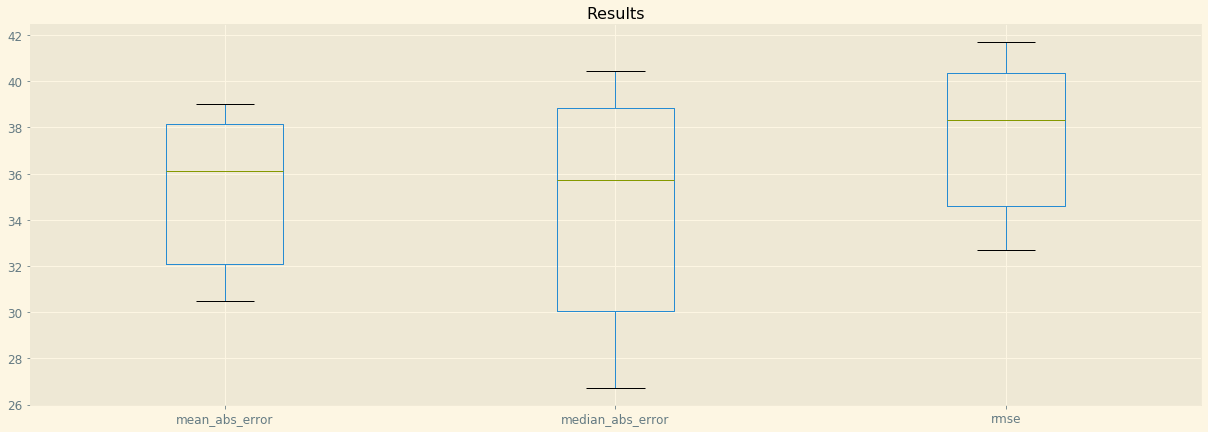

In [15]:
# Plot results statistics

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

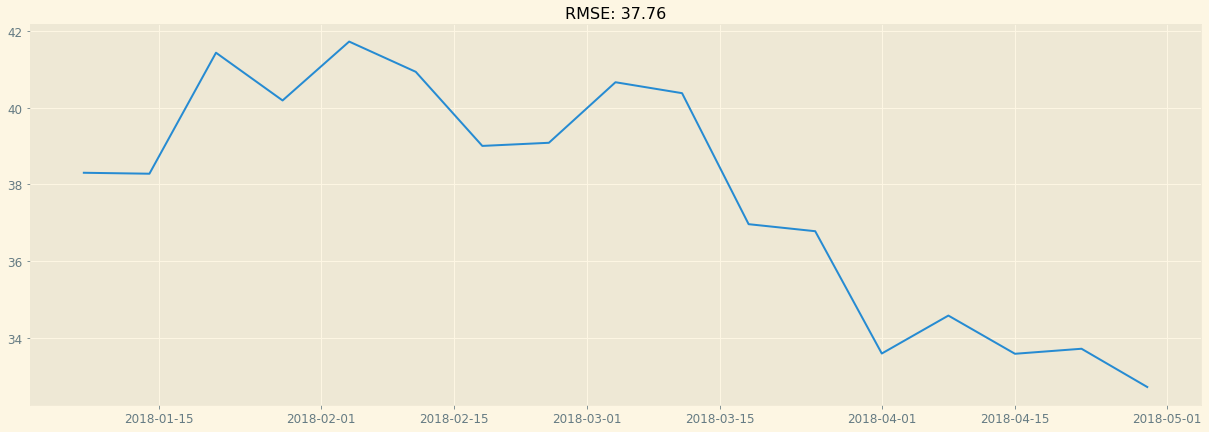

In [16]:
# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

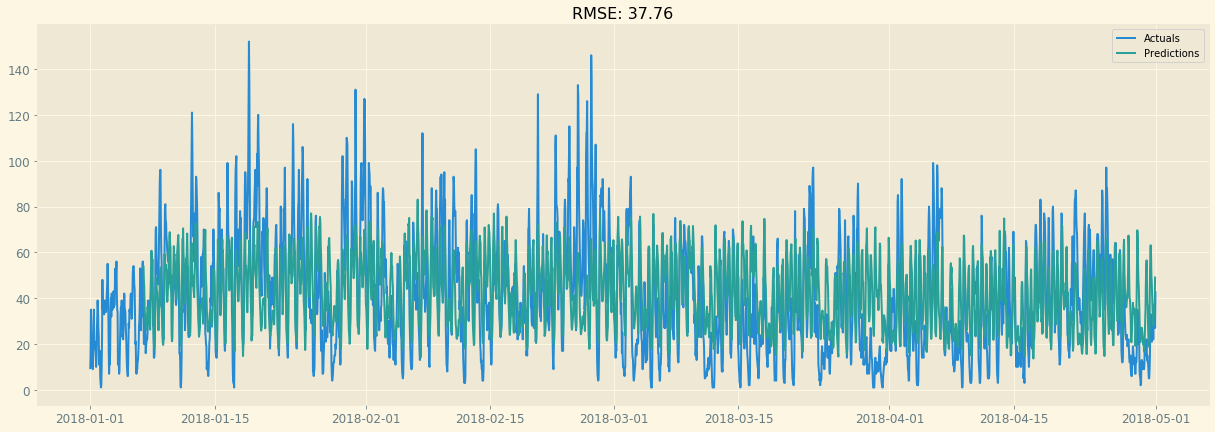

In [17]:
# Plot actuals and predictions overtime

plot_actuals_predictions(oneparticle_onestation[particle_of_interest][min_train_date:], predictions_over_time)